In [1]:
library(dplyr)
library(stringr)
library(Seurat) 
library(ggplot2)
library(RColorBrewer)
library(viridis)
library(ggrepel)
library(reshape2)
library(stringdist)
library(ggbeeswarm)
library(ggpubr)
library(shazam)
library(alakazam)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: SeuratObject

Loading required package: sp

‘SeuratObject’ was built under R 4.3.1 but the current version is
4.3.2; it is recomended that you reinstall ‘SeuratObject’ as the ABI
for R may have changed

‘SeuratObject’ was built with package ‘Matrix’ 1.6.3 but the current
version is 1.6.5; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for ‘Matrix’ may have changed


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect


Loading required package: viridisLite



To cite the SHazaM package in publications, please use:

  Gupta N, Vander Heiden J, Uduman M, Gadala-Maria D, Yaari G,
  Kleinstein S (2015). “Change-O: a toolkit for analyzing large-scale B
  cell immunoglobulin repertoire sequencing data.” 

# Functions

In [2]:
jz.checkgene = function(srat,gene){
    genes = rownames(srat)
    genes[startsWith(genes,gene)]
}

In [3]:
jz.trim.masked.primer <- function(data) {
  # Vectorize the operations on the SEQUENCE_INPUT column
  data$SEQUENCE_TRIM = str_sub(data$SEQUENCE_INPUT, data$V_SEQ_START, str_length(data$SEQUENCE_INPUT))
  data$SEQUENCE_TRIM = str_sub(data$SEQUENCE_TRIM, 1, data$J_SEQ_START - data$V_SEQ_START + data$J_SEQ_LENGTH)

  # Count the number of 'N' characters in each row
  data$N_count = str_count(data$SEQUENCE_TRIM, 'N')

  # Calculate the fraction of 'N' characters in each row
  data$N_frac = data$N_count / str_length(data$SEQUENCE_TRIM)

  return(data)
}

In [4]:
jz.save.umap.coord <- function(object) {
    # saves the UMAP embedding to the metadata 
    umapCoord <- as.data.frame(Embeddings(object = object[["umap"]]))
    object@meta.data$UMAP1 = umapCoord$UMAP_1
    object@meta.data$UMAP2 = umapCoord$UMAP_2
    return(object)
}

# Read in files

In [5]:
hc1 = read.csv('bcr_output/md39_hc_combined_results_20230415.tab',sep='\t')
hc2 = read.csv('bcr_output/md39_hc_gc_20230606.tab',sep='\t') %>% mutate(SAMPLE = paste0(SAMPLE,'H'))
hc3 = read.csv('bcr_output/md39_hc_fastq_combined_results_230628.tab',sep='\t') %>% mutate(SAMPLE = paste0(SAMPLE,'H'))

In [6]:
# separate AG1 and AG2 
ag1 = hc1 %>% filter(SAMPLE =='AG1-2H')
ag1$SAMPLE = 'AG1H'

hc1[hc1$SAMPLE=='AG1-2H','SAMPLE'] ='AG2H'
hc1 = rbind(hc1,ag1)

In [ ]:
table(hc1$SAMPLE)
table(hc2$SAMPLE)
table(hc3$SAMPLE)


In [8]:
hc5 = read.csv('bcr_output/241125Lov_P1-P8_6985T_heavy.tab',sep='\t')
hc5 = rbind(hc5, read.csv('bcr_output/241125Lov_P1-P8_6996T_heavy.tab',sep='\t'))
hc5 = hc5 %>% filter(FUNCTIONAL,IN_FRAME,
       R1CONSCOUNT>=10,R2CONSCOUNT>=10,
       R2_CLUSTER_FRACTION>=0.5,R1_CLUSTER_FRACTION>=0.5)

In [9]:
hc = rbind(hc1, hc2, hc3, hc5)
head(hc,1)

SEQUENCE_ID         
1 CATTTGGGAGAGGCGCCGAC
  SEQUENCE_INPUT                                                                                                                                                                                                                                                                                                                                                                        
1 NNNNNNNNNNNNNNNNNNNNNNNAGCTGAGCTGATGAAGCCTGGGGCCTCAGTGAAGATATCCTGCAAGGCTACTGGCTACACATTCAGTAGCTACTGGATAGAGTGGGTAAAGCAGAGGCCTGGACATGGCCTTGAGTGGATTGGAGAGATTTTACCTGGAAGTGGTAGTACTAACTACAAATGAGAAGTTCAAGGGCAAGGCCACATTCACTGCAGATACATCCTCCAACACAGCCTACATGCAACTCAGCAGCCTGACATCTGAGGACTCTGCCGTCTATTACTGTGCAAGAGGAGAACTATAGGTACCGTTTTTGGTTTGCTTACTGGGGCCAAGGGACTCTGGTCACTGTCTCTGCAGNNNNNNNNNNN
  FUNCTIONAL IN_FRAME STOP MUTATED_INVARIANT INDELS LOCUS V_CALL    
1 FALSE      FALSE    TRUE NA                TRUE   IGH   IGHV1-9*01
  D_CALL      ⋯ VPRIMER VPRIMER_FREQ R2CONSCOUNT R2_CLUSTER_FRACTION ERROR
1 IGHD2-14*01 ⋯ mVH14   0.2429557    40139       0.9459829           0    
  LENGTH OVERLAP PVAL       SAMPLE ID                         
1 374    86      1.1102e-16 AG2H   AG1-2H_CATTTGGGAGAGGCGCCGAC

In [10]:
lc1 = read.csv('bcr_output/241118LovA_P1-P8_light.tab',sep='\t')
lc2 = read.csv('bcr_output/230105LovA_AG_AQ_GC_light.csv', row.names=1) %>% mutate(SAMPLE = paste0(SAMPLE,'L'))
lc = rbind(lc1, lc2)
head(lc,1)

SEQUENCE_ID         
1 GGAATAGTTGATCTCTAGGA
  SEQUENCE_INPUT                                                                                                                                                                                                                                                                                                                                            
1 NNNNNNNNNNNNNNNNNNNNNNNNGCTTCTTTGGCTGTGTCTCTAGGGCAGAGGGCCACCATCTCCTGCAAGGCCAGCCAAAGTGTTGATTATGATGGTGATAGTTATATGAACTGGTACCAACAGAAACCAGGACAGCCACCCAAACTCCTCATCTATGCTGCATCCAATCTAGAATCTGGGATCCCAGCCAGGTTTAGTGGCAGTGGGTCTGGGACAGACTTCACCCTCAACATCCATCCTGTGGAGGAGGAGGATGCTGCAACCTATTACTGTCAGCAAAGTAATGAGGATCCTNGGACGTTCGGTGGAGGCACCAAGCTGGAAATCAAACNNNNNNNNNNNN
  FUNCTIONAL IN_FRAME STOP  MUTATED_INVARIANT INDELS LOCUS V_CALL     D_CALL ⋯
1 TRUE       TRUE     FALSE NA                FALSE  IGK   IGKV3-4*01        ⋯
  VPRIMER VPRIMER_FREQ R2CONSCOUNT R2_CLUSTER_FRACTION ERROR LENGTH OVERLAP
1 mVK02   0.5          6           0.1463415           0     346    114    
  PVAL       SAMPLE ID                      
1 1.1102e-16 P1L    P1L_GGAATAGTTGATCTCTAGGA

In [11]:
bcr = rbind(hc, lc)
bcr = jz.trim.masked.primer(bcr)
# remove H behind Sample 
bcr$Sample = str_sub(bcr$SAMPLE,0,-2)
bcr$BC = substr(bcr$SEQUENCE_ID,0,12)
bcr$UMI = substr(bcr$SEQUENCE_ID,13,20)
bcr$LANE_ID = paste(bcr$Sample, bcr$BC, sep='_')

In [20]:
colnames(bcr)

[1] "SEQUENCE_ID"         "SEQUENCE_INPUT"      "FUNCTIONAL"         
 [4] "IN_FRAME"            "STOP"                "MUTATED_INVARIANT"  
 [7] "INDELS"              "LOCUS"               "V_CALL"             
[10] "D_CALL"              "J_CALL"              "SEQUENCE_VDJ"       
[13] "SEQUENCE_IMGT"       "V_SEQ_START"         "V_SEQ_LENGTH"       
[16] "V_GERM_START_VDJ"    "V_GERM_LENGTH_VDJ"   "V_GERM_START_IMGT"  
[19] "V_GERM_LENGTH_IMGT"  "NP1_LENGTH"          "D_SEQ_START"        
[22] "D_SEQ_LENGTH"        "D_GERM_START"        "D_GERM_LENGTH"      
[25] "NP2_LENGTH"          "J_SEQ_START"         "J_SEQ_LENGTH"       
[28] "J_GERM_START"        "J_GERM_LENGTH"       "JUNCTION"           
[31] "JUNCTION_LENGTH"     "GERMLINE_IMGT"       "V_SCORE"            
[34] "V_IDENTITY"          "V_EVALUE"            "V_CIGAR"            
[37] "D_SCORE"             "D_IDENTITY"          "D_EVALUE"           
[40] "D_CIGAR"             "J_SCORE"             "J_IDENTITY"         
[43] "J_EVALUE"            "J_CIGAR"             "FWR1_IMGT"          
[46] "FWR2_IMGT"           "FWR3_IMGT"           "FWR4_IMGT"          
[49] "CDR1_IMGT"           "CDR2_IMGT"           "CDR3_IMGT"          
[52] "ISOTYPE"             "ISOTYPE_FREQ"        "R1CONSCOUNT"        
[55] "R1_CLUSTER_FRACTION" "VPRIMER"             "VPRIMER_FREQ"       
[58] "R2CONSCOUNT"         "R2_CLUSTER_FRACTION" "ERROR"              
[61] "LENGTH"              "OVERLAP"             "PVAL"               
[64] "SAMPLE"              "ID"                  "SEQUENCE_TRIM"      
[67] "N_count"             "N_frac"              "Sample"             
[70] "BC"                  "UMI"                 "LANE_ID"

In [48]:
srat = readRDS('seurat_object/00_harmony_integrated.RDS')
srat$id = rownames(srat@meta.data)
colnames(srat@meta.data)

[1] "orig.ident"                "nCount_RNA"               
 [3] "nFeature_RNA"              "cell_id"                  
 [5] "nCount_HTO"                "nFeature_HTO"             
 [7] "HTO_maxID"                 "HTO_secondID"             
 [9] "HTO_margin"                "HTO_classification"       
[11] "HTO_classification.global" "hash.ID"                  
[13] "percent.mt"                "batch"                    
[15] "RNA_snn_res.0.1"           "RNA_snn_res.0.3"          
[17] "RNA_snn_res.0.5"           "seurat_clusters"          
[19] "group"                     "mouse.id"                 
[21] "id"

In [49]:
metadata=srat@meta.data
matched = bcr %>% filter(LANE_ID %in% metadata$id) %>% 
filter(FUNCTIONAL,IN_FRAME,N_count<5,
       R1CONSCOUNT>=3,R2CONSCOUNT>=3,
       R2_CLUSTER_FRACTION>=0.5,R1_CLUSTER_FRACTION>=0.5)


table(matched$Sample, matched$LOCUS)

     
       IGH  IGK  IGL
  AG2   45   12    0
  AG3 4439 1396   32
  AQ1 3542 5456   67
  AQ2  250  141    0
  AQ3 7404 9451   45
  AQ4 3748 7831   25
  P1   611 2505  369
  P2   286 1152  331
  P3     6   53    6
  P4    61  219    4

In [50]:
metadata=srat@meta.data
metadata$IGH_recovery = as.numeric(metadata$id %in% matched$LANE_ID[matched$LOCUS=='IGH'])
metadata$IGL_recovery = as.numeric(metadata$id %in% matched$LANE_ID[matched$LOCUS!='IGH'])
metadata$recovery = metadata$IGH_recovery*2 + metadata$IGL_recovery

df4gg = metadata %>% group_by(orig.ident, recovery) %>% 
summarize(n=n()) %>% mutate(frac = n/sum(n))
df4gg %>% filter(recovery>1)

`summarise()` has grouped output by 'orig.ident'. You can override using the
`.groups` argument.


orig.ident recovery n    frac      
1  AG2        2           6 0.23076923
2  AG2        3           8 0.30769231
3  AG3        2         693 0.25072359
4  AG3        3         404 0.14616498
5  AQ1        2         285 0.09396637
6  AQ1        3         802 0.26442466
7  AQ2        2          29 0.15934066
8  AQ2        3          28 0.15384615
9  AQ3        2         267 0.08022837
10 AQ3        3        1394 0.41887019
11 AQ4        2         239 0.06104725
12 AQ4        3         909 0.23218391
13 P1         2         120 0.06322445
14 P1         3         275 0.14488936
15 P2         2          50 0.04655493
16 P2         3         147 0.13687151
17 P3         2           1 0.02941176
18 P3         3           3 0.08823529
19 P4         2          19 0.04896907
20 P4         3          22 0.05670103

In [ ]:
options(repr.plot.width=4, repr.plot.height=3, repr.plot.res=300 )
metadata=srat@meta.data
metadata$IGH_recovery = as.numeric(metadata$id %in% matched$LANE_ID[matched$LOCUS=='IGH'])
metadata$IGL_recovery = as.numeric(metadata$id %in% matched$LANE_ID[matched$LOCUS!='IGH'])
metadata$recovery = metadata$IGH_recovery*2 + metadata$IGL_recovery # 1 = LC, 2 = HC, 3 = both

metadata %>% #filter(startsWith(orig.ident, 'P')) %>%
ggplot(aes(x=orig.ident,fill=factor(recovery)))+
geom_bar(position='fill') + 
theme_classic()+
theme(axis.text.x=element_text(angle=60,hjust=1))

In [55]:
saveRDS(matched,'bcr_output/01_GEX_matched_bcr.RDS')

In [56]:
matched = readRDS('bcr_output/01_GEX_matched_bcr.RDS')
hc.match = matched %>% filter(LOCUS=='IGH') 
lc.match = matched %>% filter(LOCUS!='IGH') 


In [113]:
# write.csv(hc.match,'bcr_output/01_GEX_matched_heavy.csv')
# write.csv(lc.match,'bcr_output/01_GEX_matched_light.csv')


In [57]:
write.table(hc.match, 'bcr_output/01_GEX_matched_heavy.tab', sep= '\t', quote = FALSE, row.names = FALSE)

write.table(lc.match, 'bcr_output/01_GEX_matched_light.tab', sep= '\t', quote = FALSE, row.names = FALSE)


In bcr_output/ folder run: 

python call_seq_consensus.py 01_GEX_matched_heavy.tab 02_hc_concensus.tab

python call_seq_consensus.py 01_GEX_matched_light.tab 02_lc_consensus.tab

In [58]:
cell_consensus_hc = read.table('bcr_output/02_hc_concensus.tab', 
                               stringsAsFactors = FALSE, sep = '\t', header = TRUE) %>% 
group_by(LANE_ID, Sample, BC) %>% filter(ERRORDIST < 10) %>% 
mutate(IgM = sum(ISOTYPE == 'IGHM'), IgD = sum(ISOTYPE %in% c('IGHD1','IGHD2')), 
       IgG = sum(ISOTYPE %in% c('IGHG1','IGHG2','IGHG3')), IgA = sum(ISOTYPE == 'IGHA') ) %>%
arrange(ERRORDIST, desc(R2CONSCOUNT)) %>% slice(1)
dim(cell_consensus_hc)

[1] 4705   80

In [59]:
head(cell_consensus_hc$CONSENSUS_SEQUENCE)

[1] ".......................ACCT...GAGCTGGTGAAGCGTGGAGCTTCAATGAAGATATCCTGCAAGGCTTCTGGTTACTCATTC............ACTGGCTACACCATGAACTGGGTGAAGCAGAGCCATGGAAAGAACCTTGAGTGGATTGGACTTATTAATCCTTAC......AATGGTGGTACTAGCTACAACCAGAAGTTCAAG...GGCAAGGCCACATTAACTGTAGACAAGTCATCCAGCACAGCCTACATGGAGCTCCTCAGTCTGACATCTGAGGACTCTGCAGTCTATTACTGTGCAAGATTAGGAAAGGGGGCTATGGACTACTGGGGTCAAGGAACCTCAGTCACCGTCTCCTCAG"      
[2] ".......................GGCT...GAACTGGCAAGACCTGGGGCCTCAGTGAAGATGTCCTGCAAGGCTTCTGGCTACACCTTT............ACTAGGTTCACGATGCACTGGGTAAAACAGAGGCCTGGACAGGGTCTTGAATGGATTGGATACATTAATCCTAGC......AGTGGTTATACTAATTACAATCAGAACTTCAAG...GACAAGGCCACATTGACTGCAGACAAATCCTCCAGCACAGCCTACATGCAACTGAGCAGCCTGACATCTGAGGACTCTGCAGTCTATTACTGTGCAAGAGACTATGGCCTTGCTTACTGGGGCCAAGGGACTCTGGTCACTGTCTCTGCAG"            
[3] ".......................GGCT...GACCTGGTGAGGCCTGGGGCTTCAGTGAAGCTGTCCTGCAAGGCTTTGGGCTACACATTT............ACTGACTATGAAATGCACTGGGTGAAGCAGACACCTGTGCATGGCCTGGAATGGATTGGAGCTATTCATCCAGGA......AGTGGTGGTACTGCCTACAATCAGAAGTTCAAG...GGCAAGGCCACACTGACTGCAGACAAATCCTCCAGCACAGCCTACATGGAACTCAGCAGCCTGACATCTGAGGACTCTGCTGTCTATTACTGTTCAATCTTACCTCACTGGGGCCAAGGCACCACTCTCACAGTCTCCTCAG"                     
[4] ".......................GGGA...GGCTTAGTGAAGCCTGGAGGGTCCCTGAAACTCTCCTGTGCAGCCTCTGGATTCGCTTTC............AGTAGCTATGACATGTCTTGGGTTCGCCAGACTCCGGAGAAGAGGCTGGAGTGGGTCGCATACATTAGTAGTGGT......GGTGGTAGCACCTACTATCCAGACACTGTGAAG...GGCCGATTCACCATCTCCAGAGACAATGCCAAGAACACCCTGTACCTGCAAATGAGCAGTCTGAAGTCTGAGGACACAGCCATGTATTACTGTGCAAGACATAGGTACGACAGGGCCTGGTTTGCTTACTGGGGCCAAGGGACTCTGGTCACTGTCTCTGCAG"
[5] ".......................AGCT...NAGCTGATGAAGCNTGGGGCCTCAGAGAGGAAATACTGCAAGGCTTCTNGCTACACATTC............ACTAGCTACTGGATAGAGTGGGTAAAGCAGAGGCCTGGACATGGCCTTGAGTGGATTGGAGAGATTTTACCTGGA......AGTGATAGTACTGACTACAATGAGAAGTTCAAG...GGCAAGGCCACATTCACTGCAGATACATCCTCCACCACAGCCTACATGCAACTCAGCAGCCTGACATCTGAGGACTCTGCCGTCTATTACTGTGCAAGAATGATTACCGCCTGGTTTGCTGACTGGGGCCAAGGGACTCTGGTCACTGTCTCTGCAG"      
[6] ".......................GGCT...GAACTGGCAAGACCTGGGGCCTCAGTGAAGATGTCCTGCAAGGCTTCTGGCTACACCTTT............ACTAGGTTCACGATGCACTGGGTAAAACAGAGGCCTGGACAGGGTCTTGAATGGATTGGATACATTAATCCTAGC......AGTGGTTATACTAATTACAATCAGAACTTCAAG...GACAAGGCCACATTGACTGCAGACAAATCCTCCAGCACAGCCTACATGCAACTGAGCAGCCTGACATCTGAGGACTCTGCAGTCTATTACTGTGCAAGAGACTATGGCCTTGCTTACTGGGGCCAAGGGACTCTGGTCACTGTCTCTGCAG"

In [60]:
table(cell_consensus_hc$Sample)


 AG2  AG3  AQ1  AQ2  AQ3  AQ4   P1   P2   P3   P4 
  12  846  868   51 1353  948  387  195    4   41 

In [61]:
table(cell_consensus_hc$ISOTYPE)


IGHD1 IGHG1 IGHG2 IGHG3  IGHM 
  204  2609   307    48  1537 

In [62]:
library(alakazam)
library(stringr)
cell_consensus_hc[,c('FWR1nuc', 'CDR1nuc', 'FWR2nuc', 'CDR2nuc', 'FWR3nuc')]= extractVRegion(cell_consensus_hc$CONSENSUS_SEQUENCE, region = c('fwr1', 'cdr1', 'fwr2', 'cdr2', 'fwr3')) %>% as.data.frame()
cell_consensus_hc$JUNCTION_START = NA
cell_consensus_hc$CDR3nuc = NA
dim(cell_consensus_hc)

cell_consensus_hc = cell_consensus_hc %>% filter(FWR3nuc != '')
dim(cell_consensus_hc)
for (i in 1:nrow(cell_consensus_hc)) {    
    # The JUNCTION column includes one codon from FWR3 and FWR4, hence subtract 3 to match with JUNCTION column
    cell_consensus_hc$JUNCTION_START[i] = as.numeric(gregexpr(cell_consensus_hc$CONSENSUS_SEQUENCE[i], pattern = cell_consensus_hc$FWR3nuc[i])) + str_length(cell_consensus_hc$FWR3nuc[i])-3 
    # CDR3nuc is different from CDR3_IMGT in that this is the equivalent JUNCTION column based on CONSENSUS_SEQUENCE
    cell_consensus_hc$CDR3nuc[i] = substring(cell_consensus_hc$CONSENSUS_SEQUENCE[i], cell_consensus_hc$JUNCTION_START[i], cell_consensus_hc$JUNCTION_START[i] + str_length(cell_consensus_hc$JUNCTION[i]) -1)
}

[1] 4705   87

[1] 4692   87

In [63]:
library(alakazam)
cell_consensus_hc = cell_consensus_hc %>% filter(ISOTYPE!='')
dim(cell_consensus_hc)

cell_consensus_hc$CDR1 = translateDNA(cell_consensus_hc$CDR1nuc)
cell_consensus_hc$CDR2 = translateDNA(cell_consensus_hc$CDR2nuc)
cell_consensus_hc$CDR3 = translateDNA(cell_consensus_hc$CDR3nuc)

[1] 4692   87

In [64]:
write.table(cell_consensus_hc, 'bcr_output/03_hc_translated.tab', sep= '\t', quote = FALSE, row.names = FALSE)


In [65]:
cell_consensus_lc = read.table('bcr_output/02_lc_consensus.tab', 
                               stringsAsFactors = FALSE, sep = '\t', header = TRUE) %>% 
group_by(LANE_ID, Sample, BC) %>% filter(ERRORDIST < 10) %>% 
mutate(IgK = sum(ISOTYPE == 'IGKC'), IgL = sum(ISOTYPE == 'IGLC')) %>%
arrange(ERRORDIST, desc(R2CONSCOUNT)) %>% slice(1) 
dim(cell_consensus_lc)

[1] 8720   78

In [66]:
table(cell_consensus_lc$Sample)


 AG2  AG3  AQ1  AQ2  AQ3  AQ4   P1   P2   P3   P4 
   8  701 1689   57 2320 2352  991  498   16   88 

In [67]:
table(cell_consensus_lc$ISOTYPE)


 IGKC IGLC1 IGLC2 
 8526   188     6 

In [68]:
cell_consensus_lc[,c('FWR1nuc', 'CDR1nuc', 'FWR2nuc', 'CDR2nuc', 'FWR3nuc')]= extractVRegion(cell_consensus_lc$CONSENSUS_SEQUENCE, region = c('fwr1', 'cdr1', 'fwr2', 'cdr2', 'fwr3')) %>% as.data.frame()
cell_consensus_lc$JUNCTION_START = NA
cell_consensus_lc$CDR3nuc = NA
dim(cell_consensus_lc)

cell_consensus_lc = cell_consensus_lc %>% filter(FWR3nuc != '')
dim(cell_consensus_lc)

for (i in 1:nrow(cell_consensus_lc)) {
    if (lengths(gregexpr(cell_consensus_lc$CONSENSUS_SEQUENCE[i], pattern = cell_consensus_lc$FWR3nuc[i]))>1) {
        next
    }
    cell_consensus_lc$JUNCTION_START[i] = as.numeric(gregexpr(cell_consensus_lc$CONSENSUS_SEQUENCE[i], pattern = cell_consensus_lc$FWR3nuc[i])) + str_length(cell_consensus_lc$FWR3nuc[i])-3
    cell_consensus_lc$CDR3nuc[i] = substring(cell_consensus_lc$CONSENSUS_SEQUENCE[i], cell_consensus_lc$JUNCTION_START[i], cell_consensus_lc$JUNCTION_START[i] + str_length(cell_consensus_lc$JUNCTION[i]) -1)
}

[1] 8720   85

[1] 8715   85

In [69]:
library(alakazam)
cell_consensus_lc = cell_consensus_lc %>% filter(ISOTYPE!='')
dim(cell_consensus_lc)

cell_consensus_lc$CDR1 = translateDNA(cell_consensus_lc$CDR1nuc)
cell_consensus_lc$CDR2 = translateDNA(cell_consensus_lc$CDR2nuc)
cell_consensus_lc$CDR3 = translateDNA(cell_consensus_lc$CDR3nuc)

[1] 8715   85

In [70]:
write.table(cell_consensus_lc, 'bcr_output/03_lc_translated.tab', sep= '\t', quote = FALSE, row.names = FALSE)


In [ ]:
# determine clonal calling cut off

In [2]:
cell_consensus_hc=read.table('bcr_output/03_hc_translated.tab',header=TRUE,sep='\t')

In [72]:
# private clone
dist_ham <- distToNearest(cell_consensus_hc , 
                          cellIdColumn = 'LANE_ID',locusColumn = 'LOCUS',
                          sequenceColumn="CDR3nuc", 
                          vCallColumn="V_CALL", jCallColumn="J_CALL",
                          model="ham", normalize="len")

In [73]:
colnames(cell_consensus_hc)

[1] "SEQUENCE_ID"         "SEQUENCE_INPUT"      "FUNCTIONAL"         
 [4] "IN_FRAME"            "STOP"                "MUTATED_INVARIANT"  
 [7] "INDELS"              "LOCUS"               "V_CALL"             
[10] "D_CALL"              "J_CALL"              "SEQUENCE_VDJ"       
[13] "SEQUENCE_IMGT"       "V_SEQ_START"         "V_SEQ_LENGTH"       
[16] "V_GERM_START_VDJ"    "V_GERM_LENGTH_VDJ"   "V_GERM_START_IMGT"  
[19] "V_GERM_LENGTH_IMGT"  "NP1_LENGTH"          "D_SEQ_START"        
[22] "D_SEQ_LENGTH"        "D_GERM_START"        "D_GERM_LENGTH"      
[25] "NP2_LENGTH"          "J_SEQ_START"         "J_SEQ_LENGTH"       
[28] "J_GERM_START"        "J_GERM_LENGTH"       "JUNCTION"           
[31] "JUNCTION_LENGTH"     "GERMLINE_IMGT"       "V_SCORE"            
[34] "V_IDENTITY"          "V_EVALUE"            "V_CIGAR"            
[37] "D_SCORE"             "D_IDENTITY"          "D_EVALUE"           
[40] "D_CIGAR"             "J_SCORE"             "J_IDENTITY"         
[43] "J_EVALUE"            "J_CIGAR"             "FWR1_IMGT"          
[46] "FWR2_IMGT"           "FWR3_IMGT"           "FWR4_IMGT"          
[49] "CDR1_IMGT"           "CDR2_IMGT"           "CDR3_IMGT"          
[52] "ISOTYPE"             "ISOTYPE_FREQ"        "R1CONSCOUNT"        
[55] "R1_CLUSTER_FRACTION" "VPRIMER"             "VPRIMER_FREQ"       
[58] "R2CONSCOUNT"         "R2_CLUSTER_FRACTION" "ERROR"              
[61] "LENGTH"              "OVERLAP"             "PVAL"               
[64] "SAMPLE"              "ID"                  "SEQUENCE_TRIM"      
[67] "N_count"             "N_frac"              "Sample"             
[70] "BC"                  "UMI"                 "LANE_ID"            
[73] "CONSENSUS_SEQUENCE"  "CONSENSUS_SEQCOUNT"  "ERRORDIST"          
[76] "CONSENSUS_AMBIG"     "IgM"                 "IgD"                
[79] "IgG"                 "IgA"                 "FWR1nuc"            
[82] "CDR1nuc"             "FWR2nuc"             "CDR2nuc"            
[85] "FWR3nuc"             "JUNCTION_START"      "CDR3nuc"            
[88] "CDR3"

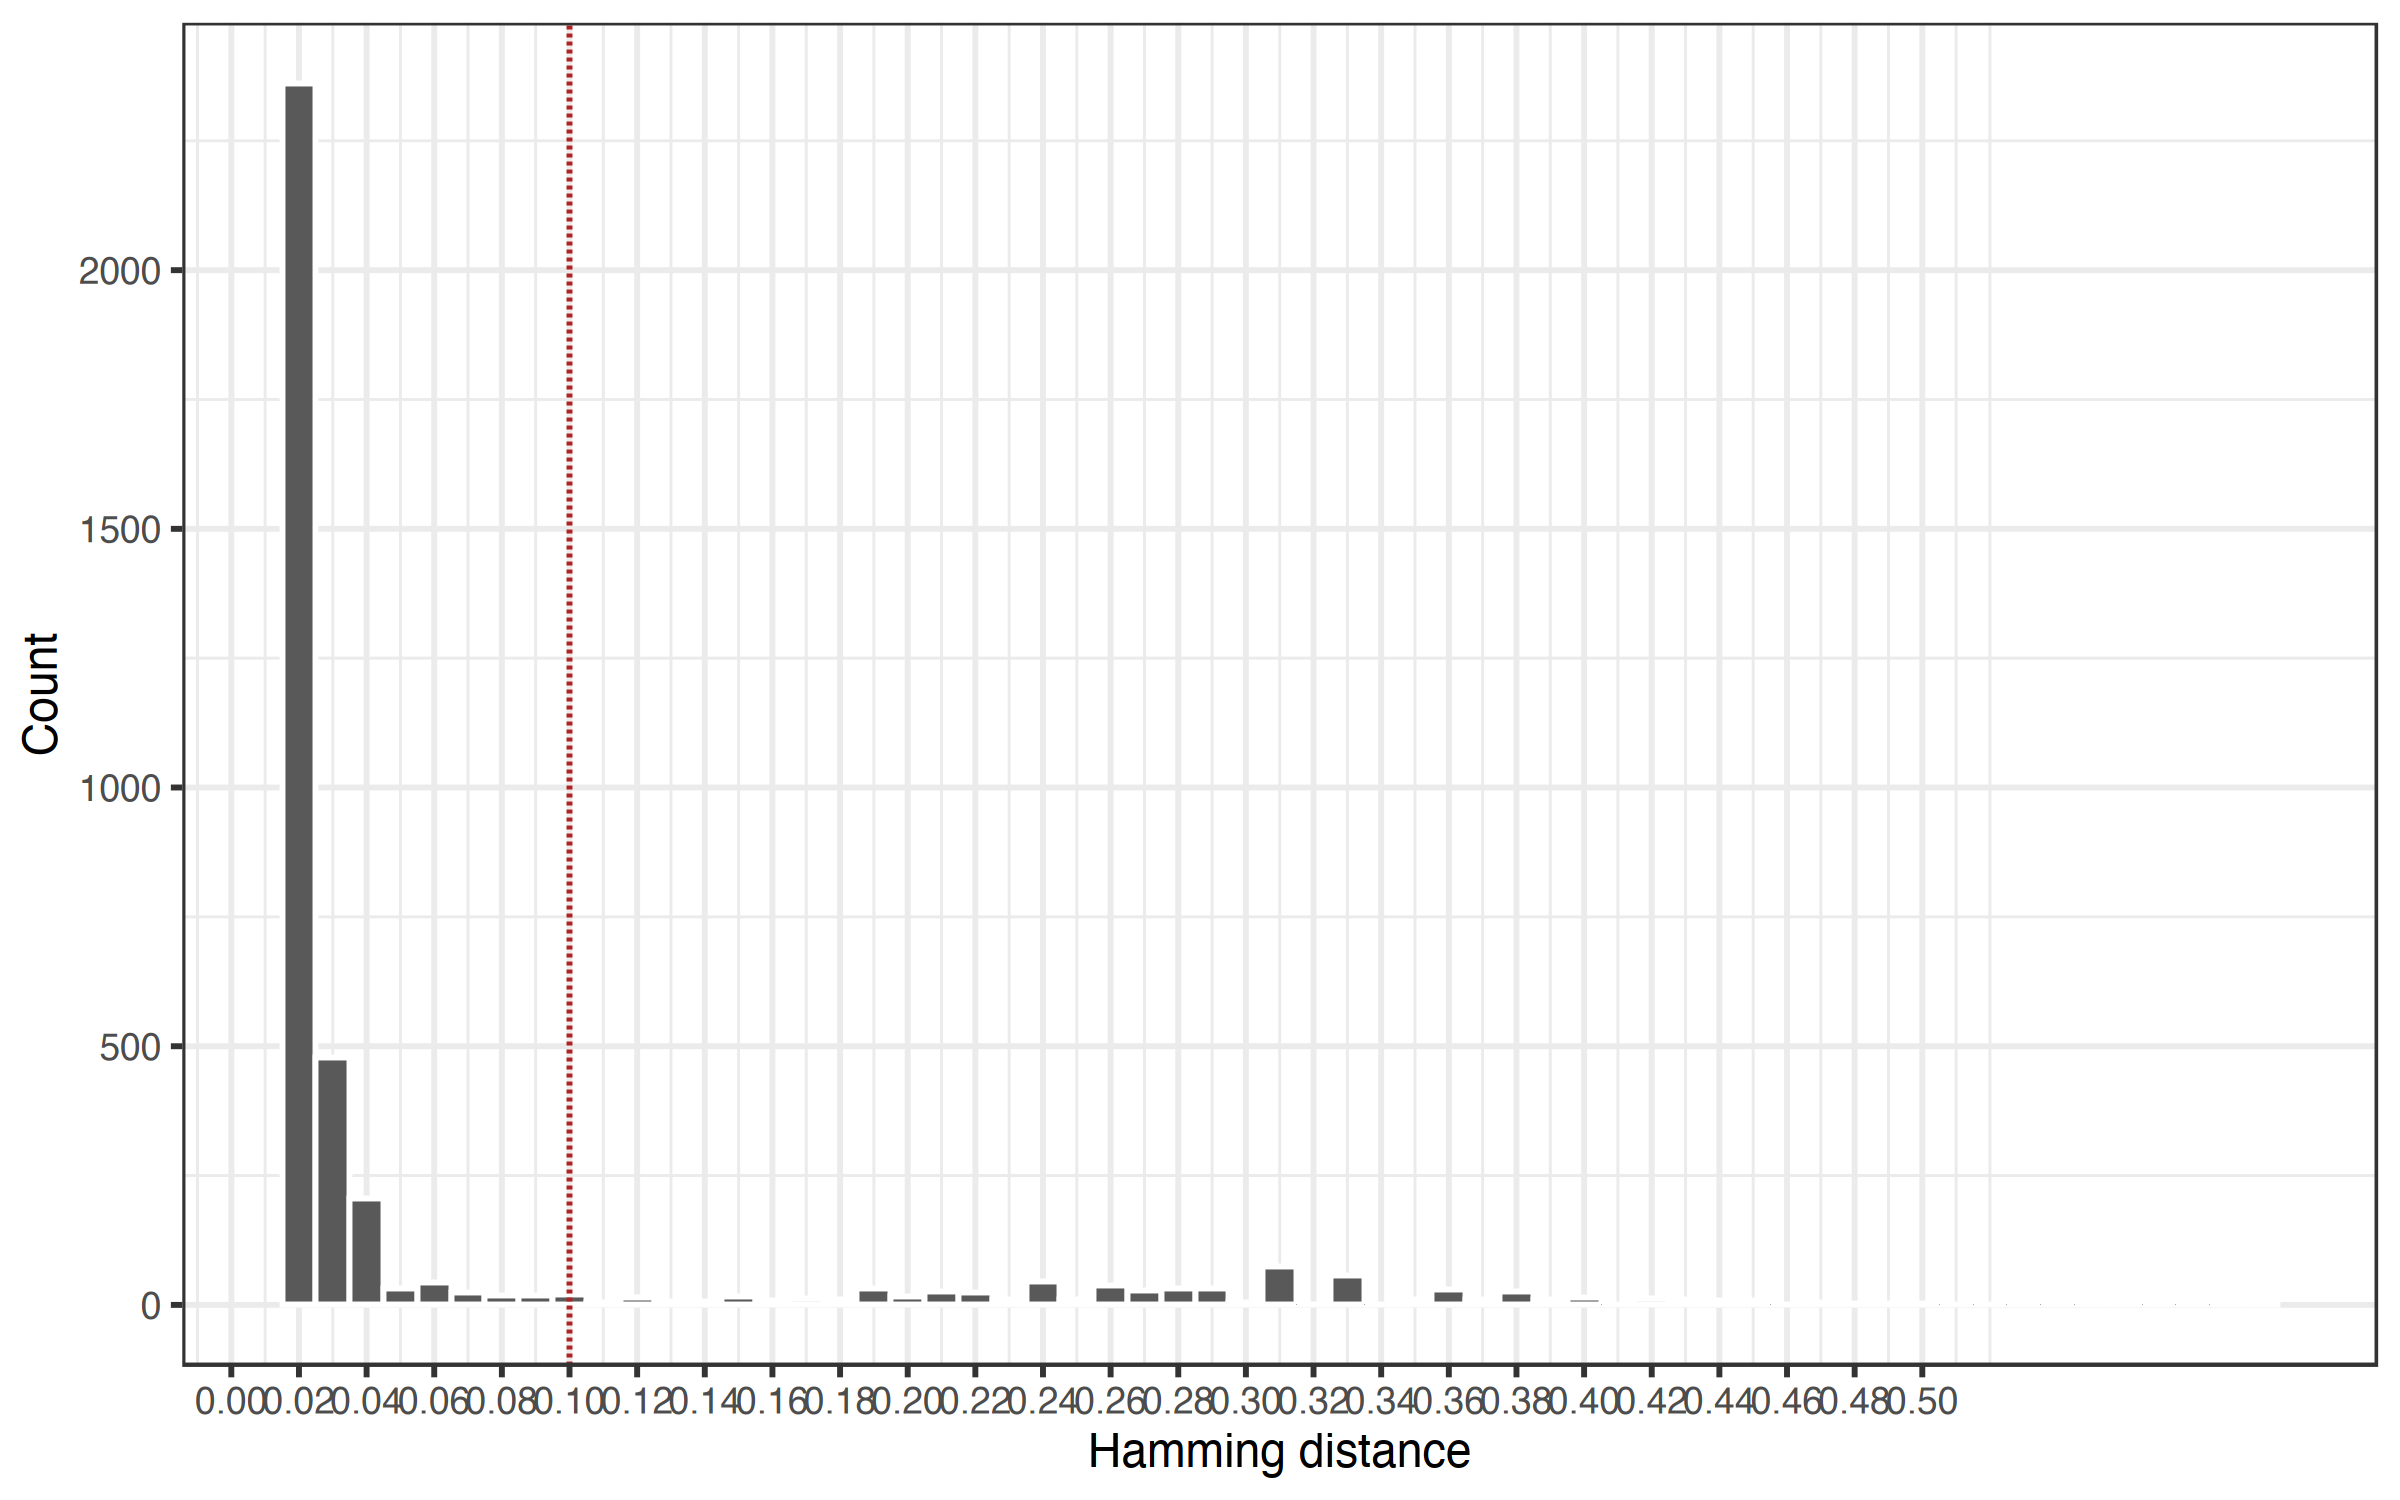

In [75]:
options(repr.plot.width=8, repr.plot.height=5)
p1 <- ggplot(subset(dist_ham, !is.na(dist_nearest)),
             aes(x=dist_nearest)) + 
    theme_bw() + 
    xlab("Hamming distance") + 
    ylab("Count") +
    scale_x_continuous(breaks=seq(0, 0.5, 0.02)) +
    geom_histogram(color="white", binwidth=0.01) +
    geom_vline(xintercept=0.1, color="firebrick", linetype=2)
plot(p1)

[1] 0.1503032

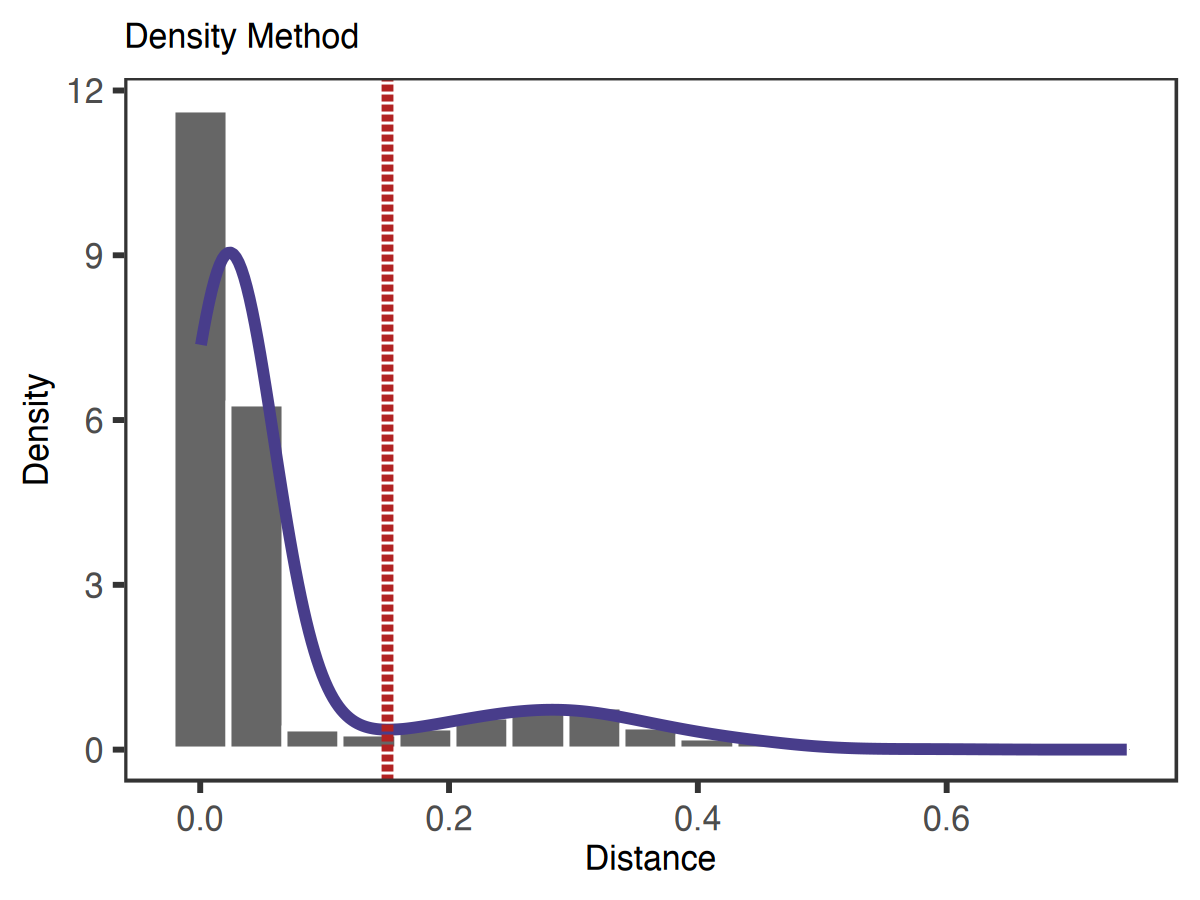

In [74]:
output <- findThreshold(dist_ham$dist_nearest, method="density",cutoff='opt') #method="density"
# "norm-norm", "norm-gamma", "gamma-norm", and "gamma-gamma"
threshold <- output@threshold
threshold
plot(output, title="Density Method")

In [79]:
# add mouse info
cell_consensus_hc=read.table('bcr_output/03_hc_translated.tab',header=TRUE,sep='\t')
cell_consensus_hc$MOUSE = srat$mouse.id[match(cell_consensus_hc$LANE_ID,srat$cell_id)]

In [80]:
# change column names for DefineClones.py
a = cell_consensus_hc %>% mutate(JUNCTION = CDR3nuc, JUNCTION_LENGTH = str_length(JUNCTION))
write.table(a,'bcr_output/04_hc_pre_defineclones.tab', quote = FALSE, row.names = FALSE, sep = '\t')

Define clones by mouse:  

DefineClones.py -d 04_hc_pre_defineclones.tab -o 05_hc_private_clones.tab --act set --model ham --norm len --format changeo --sf CDR3nuc --gf MOUSE --dist 0.15

CreateGermlines.py -d 05_hc_private_clones.tab -g full dmask --cloned --format changeo --sf CONSENSUS_SEQUENCE -r mouse/vdj/imgt_mouse_IGHJ.fasta mouse/vdj/imgt_mouse_IGHD.fasta mouse/vdj/imgt_mouse_IGHV.fasta --format changeo 

Define metaclones:

DefineClones.py -d 04_hc_pre_defineclones.tab -o 05_hc_meta_clones.tab --act set --model aa --norm len --format changeo --sf CDR3nuc --dist 0.1 

CreateGermlines.py -d 05_hc_meta_clones.tab -g full dmask --cloned --format changeo --sf CONSENSUS_SEQUENCE -r mouse/vdj/imgt_mouse_IGHJ.fasta mouse/vdj/imgt_mouse_IGHD.fasta mouse/vdj/imgt_mouse_IGHV.fasta --format changeo 

In [319]:
cell_consensus_hc = read.table('bcr_output/05_hc_private_clones_germ-pass.tab',
                stringsAsFactors = FALSE, header = TRUE, sep = '\t') 
dim(cell_consensus_hc)
cell_consensus_lc = read.table('bcr_output/03_lc_translated.tab',
                stringsAsFactors = FALSE, header = TRUE, sep = '\t') 
dim(cell_consensus_lc)

[1] 5342   97

[1] 10299    88

In [85]:
fil.data = readRDS('md39/processed_repertoire_data/01_md39_ppfilter_HC_LC.RDS')

In [86]:
mode= function(x) {
    ret = NA
    if (length(x) > 0){
    tab = table(x)
    tab = tab[order(tab, decreasing = TRUE)]
    ret = names(tab)[1]
        }
    as.character(ret)
}
 

In [87]:
data_match = fil.data %>% group_by(BC, LOCUS) %>% mutate(NMOL = n()) %>% filter(NMOL >= 3) 
data_match = data_match %>% group_by(BC, LOCUS) %>% mutate(VMODE = mode(V_CALL), CDR3mode = mode(CDR3_IMGT)) 
data_match$VMATCH = factor(data_match$V_CALL == data_match$VMODE)
data_match$CDR3MATCH = factor(data_match$CDR3_IMGT == data_match$CDR3mode)

dim(data_match)

[1] 335840     76

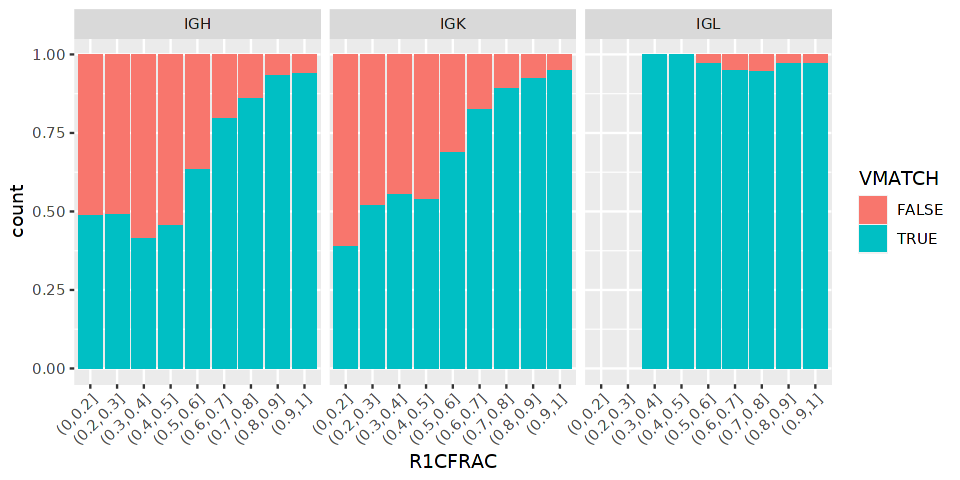

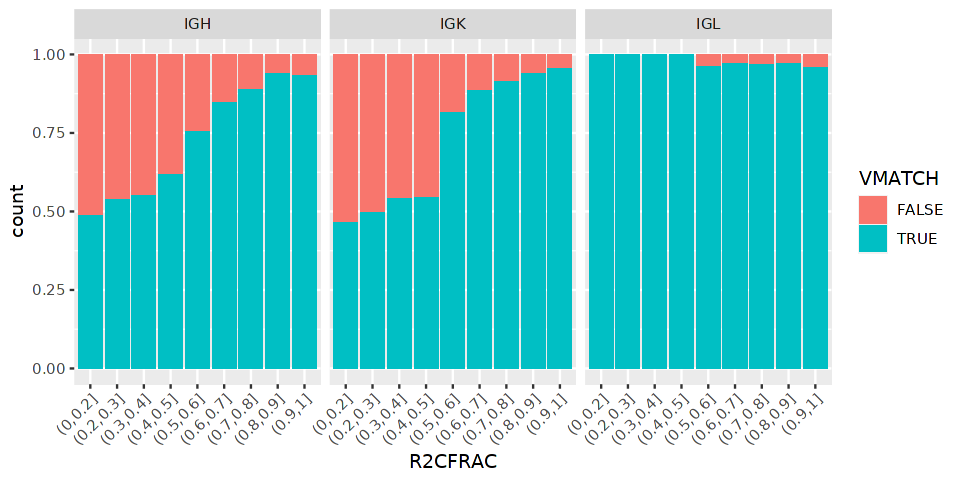

In [92]:
options(repr.plot.height=4,repr.plot.width=8)
data_match$R1CFRAC = cut(data_match$R1_CLUSTER_FRACTION, c(0,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1))
data_match$R2CFRAC = cut(data_match$R2_CLUSTER_FRACTION, c(0,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1))

data_match %>% filter(NMOL > 3, R1CONSCOUNT> 2) %>% 
ggplot(aes(x = R1CFRAC, fill = VMATCH)) + geom_bar(position='fill')  + facet_wrap('LOCUS') + 
theme(axis.text.x = element_text(angle = 45, hjust = 1))

data_match %>% filter(NMOL > 3,R1CONSCOUNT> 2) %>% 
ggplot(aes(x = R2CFRAC, fill = VMATCH)) + geom_bar(position='fill') + facet_wrap('LOCUS') + 
theme(axis.text.x = element_text(angle = 45, hjust = 1))

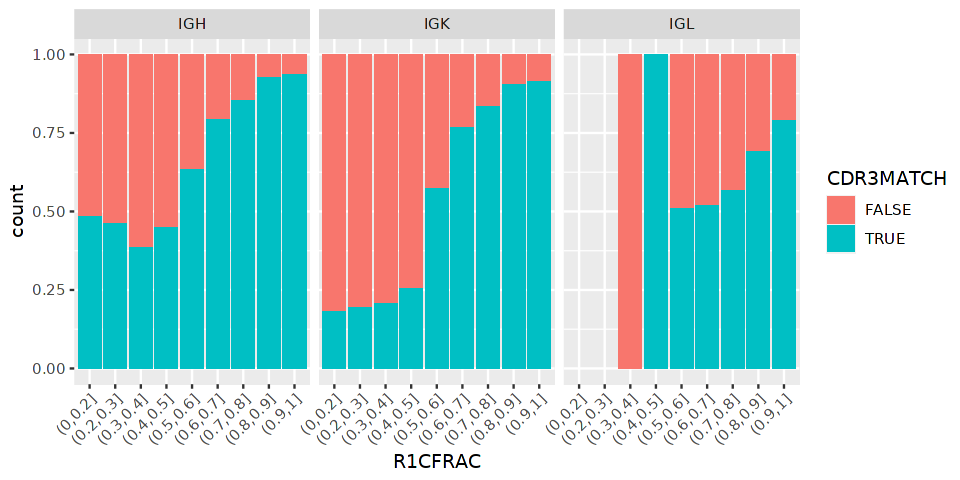

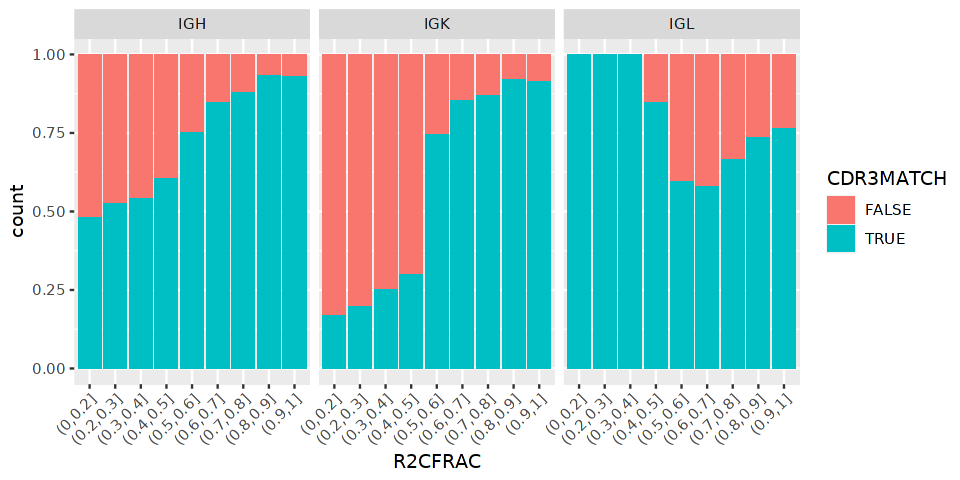

In [93]:
data_match %>% filter(NMOL > 3, R1CONSCOUNT>2) %>% 
ggplot(aes(x = R1CFRAC, fill = CDR3MATCH)) + geom_bar(position='fill')  + facet_wrap('LOCUS') + 
theme(axis.text.x = element_text(angle = 45, hjust = 1))

data_match %>% filter(NMOL > 3,R1CONSCOUNT>2) %>% 
ggplot(aes(x = R2CFRAC, fill = CDR3MATCH)) + geom_bar(position='fill') + facet_wrap('LOCUS') + 
theme(axis.text.x = element_text(angle = 45, hjust = 1))

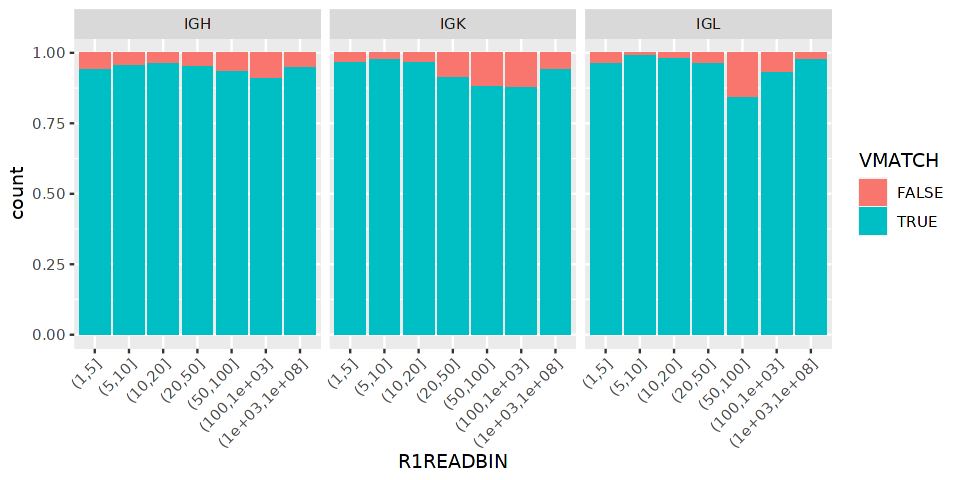

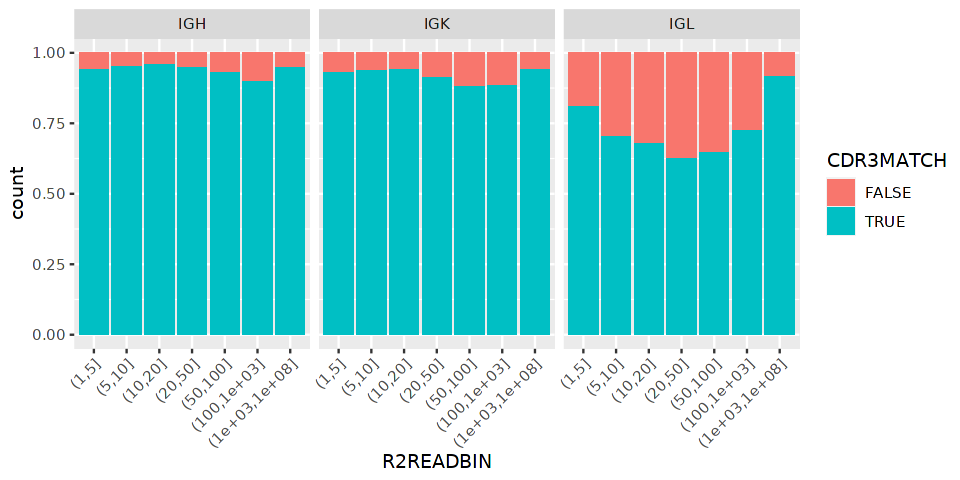

In [90]:
data_match$R1READBIN = cut(data_match$R1CONSCOUNT, c(1, 5, 10, 20, 50, 100, 1000, 100000000))
data_match$R2READBIN = cut(data_match$R2CONSCOUNT, c(1, 5, 10, 20, 50, 100, 1000, 100000000))

data_match %>% filter(NMOL > 3, R1CONSCOUNT> 4,R1_CLUSTER_FRACTION>0.7,R2_CLUSTER_FRACTION>0.7) %>% 
ggplot(aes(x = R1READBIN, fill = VMATCH)) + geom_bar(position='fill')  + facet_wrap('LOCUS') + 
theme(axis.text.x = element_text(angle = 45, hjust = 1))

data_match %>% filter(NMOL > 3,R1CONSCOUNT> 4,R1_CLUSTER_FRACTION>0.7,R2_CLUSTER_FRACTION>0.7) %>% 
ggplot(aes(x = R2READBIN, fill = CDR3MATCH)) + geom_bar(position='fill') + facet_wrap('LOCUS') + 
theme(axis.text.x = element_text(angle = 45, hjust = 1))

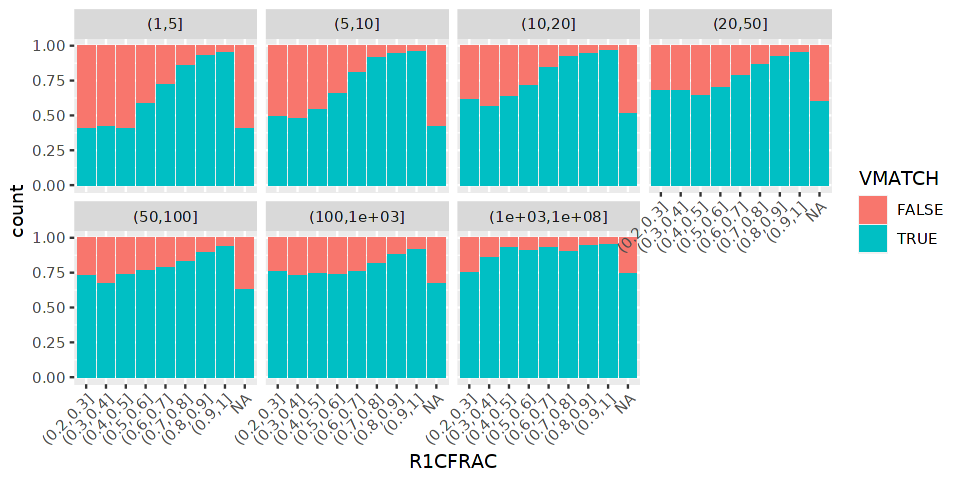

In [91]:
data_match$R1CFRAC = cut(data_match$R1_CLUSTER_FRACTION, c(0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1))
data_match$R2CFRAC = cut(data_match$R2_CLUSTER_FRACTION, c(0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1))

data_match %>% filter(NMOL > 2, R1CONSCOUNT> 4,LOCUS=='IGH') %>% 
ggplot(aes(x = R1CFRAC, fill = VMATCH)) + geom_bar(position='fill')  + facet_wrap('R2READBIN', ncol=4) + 
theme(axis.text.x = element_text(angle = 45, hjust = 1))

In [76]:
jz.checkgene(b.seurat,'Iglc')

[1] "Iglc1" "Iglc3" "Iglc2"

In [103]:
igh.expression = FetchData(srat, slot = "count",
                           vars=c('Ighm','Ighd','Ighg3','Ighg1','Ighg2b','Ighg2c','Igha','Ighe',
                                  'Igkc','Iglc1','Iglc2','Iglc3',
                                  'id','Phenotype','Group','Mouse','Batch'))
igh.expression$IGH.expression=rowSums(igh.expression [,1:8])
igh.expression$IGL.expression=rowSums(igh.expression [,9:12])

In [109]:
metadata = srat@meta.data
metadata$id = paste(metadata$orig, metadata$bc, sep='_')
dim(metadata)
metadata$IGH_recovery = as.numeric(metadata$id %in% hc.match$LANE_ID) * 2
metadata$IGL_recovery = as.numeric(metadata$id %in% lc.match$LANE_ID)

metadata$mouse = paste(metadata$Batch,metadata$Group,metadata$hash.ID, sep="_")

[1] 38027    34

In [110]:
igh.expression$IGH_recovery = metadata$IGH_recovery[match(igh.expression$id,metadata$id)]
igh.expression$IGL_recovery = metadata$IGL_recovery[match(igh.expression$id,metadata$id)]

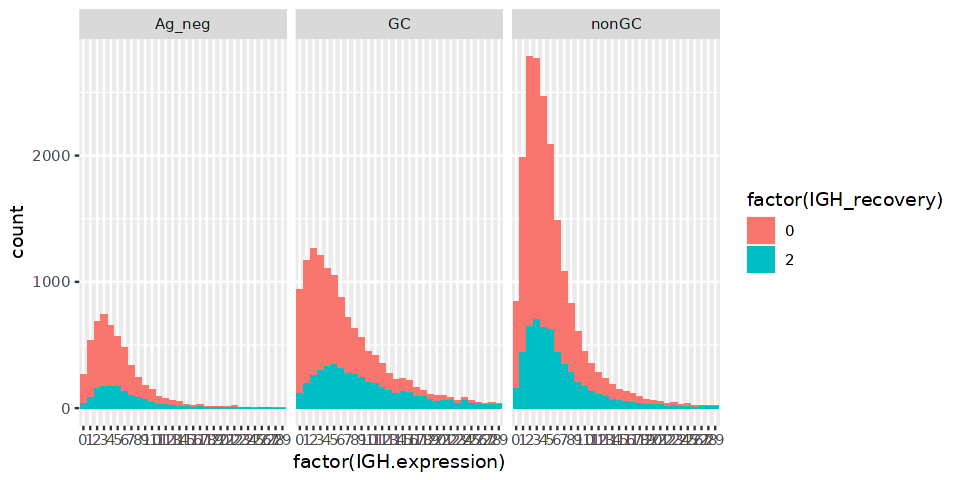

In [114]:
options(repr.plot.height=4,repr.plot.width=8)
igh.expression %>% filter(IGH.expression < 30) %>% 
ggplot(aes(x=factor(IGH.expression), fill=factor(IGH_recovery))) + 
geom_bar(position='stack') + facet_wrap('Phenotype')

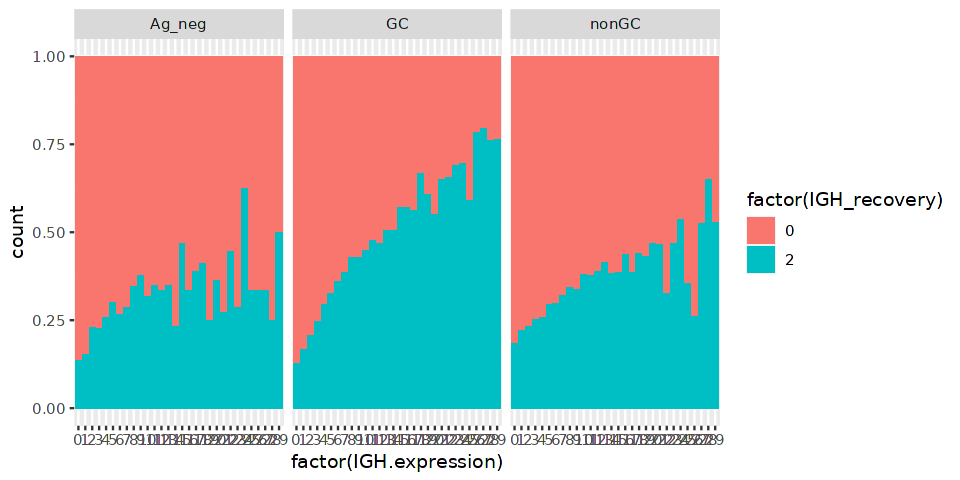

In [115]:
options(repr.plot.height=4,repr.plot.width=8)
igh.expression %>% filter(IGH.expressi*on < 30) %>% 
ggplot(aes(x=factor(IGH.expression), fill=factor(IGH_recovery))) + 
geom_bar(position='fill') + facet_wrap('Phenotype')

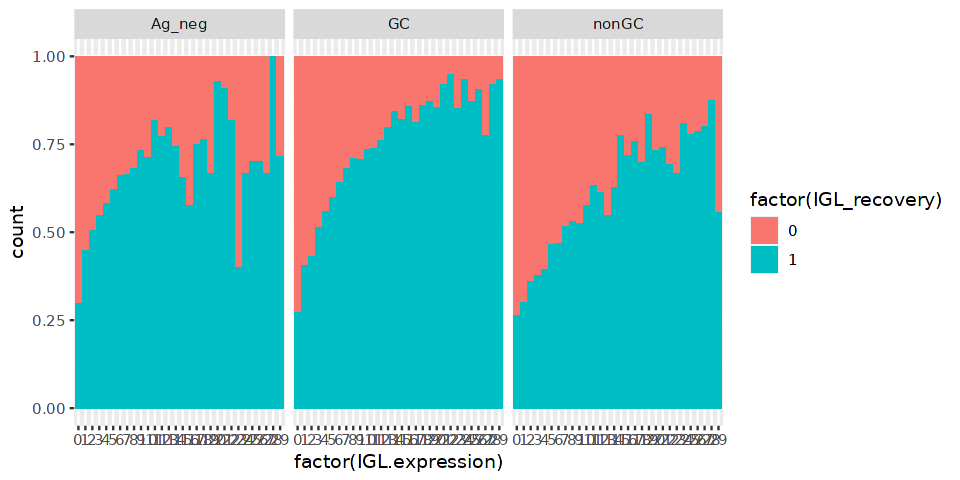

In [116]:
options(repr.plot.height=4,repr.plot.width=8)
igh.expression %>% filter(IGL.expression < 30) %>% 
ggplot(aes(x=factor(IGL.expression), fill=factor(IGL_recovery))) + 
geom_bar(position='fill') + facet_wrap('Phenotype')

In [24]:
cell_consensus_hc = read.table('md39/processed_repertoire_data/03_hc_consensus.tab', 
                               stringsAsFactors = FALSE, sep = '\t', header = TRUE) %>% 
group_by(LANE_ID, Sample, BC) %>% filter(ERRORDIST < 10) %>% 
mutate(IgM = sum(ISOTYPE == 'IGHM'), IgD = sum(ISOTYPE %in% c('IGHD1','IGHD2')), 
       IgG = sum(ISOTYPE %in% c('IGHG1','IGHG2','IGHG3')), IgA = sum(ISOTYPE == 'IGHA') ) %>%
arrange(ERRORDIST, desc(R2CONSCOUNT)) %>% slice(1)
dim(cell_consensus_hc)

[1] 8872   79

In [11]:
head(cell_consensus_hc$CONSENSUS_SEQUENCE)

[1] ".......................ACCT...GAGCTGAAGAAGCCTGGAGAGACAGTCAAGATCTCCTGCAAGGCTTCTGGGTATACCTTC............ACAAACTATGGAATGAACTGGGTGAAGCAGGCTCCAGGAAAGGGTTTAAAGTGGATGGGCTGGATAAACACCAAC......ACTGGAGAGCCAACATATGCTGAAGAGTTCAAG...GGACGGTTTGCCTTCTCTTTGGAAACCTCTGCCAGCACTGCCTATTTGCAGATCAACAACCTCAAAAATGAGGACACGGCTACATATTTCTGTGCAAGACTCCCCCTGGTAGCTTATGGTAACTACGATTACTATGCTATGGACTACTGGGGTCAAGGAACCTCAGTCACCGTCTCCTCAG"
[2] ".........................CT...GAGCTGGTGAAGCCTGGGGCTTCAGTGAAGATATCCTGCAAGGCTTCTGGCTACACATTC............ACTGACTACAACATGGACTGGGTGAAGCAGAGCCATGGAAAGAGCCTTGAGTGGATTGGAGATATTAATCCTAAC......TATGATAGTACTAGCTACAACCAGAAGTTCAAG...GGAAAGGCCACATTGACTGTAGACAAGTCCTCCAGCACAGCCTACATGGAGCTCCGCAGCCTGACATCTGAGGACACTGCAGTCTATTACTGTGCAAGATCGGATGGCCTCTATGCTATGGACTACTGGGGTCAAGGAACCTCAGTCACCGTCTCCTCAG"                     
[3] ".......................GCCT...GAGCTGGTGAGGCCTGGGGTCTCAGTGAAGATTTCCTGCAAGGGTTCCGGCTACACATTC............ACTGATTATGCTATGCACTGGGTGAAGCAGAGTCATGCAAAGAGTCTAGAGTGGATTGGAGTTATTAGTACTTAC......TCTGGTAATACAAACTACAACCAGAAGTTTAAG...GGCAAGGCCACAATGACTGTAGACAAATCCTCCAGCACAGCCTATATGGAACTTGCCAGATTGACATCTGAGGATTCTGCCATCTATTACTGTGCAAGACGAGGTGATTACGACGGGGAGTACTATGCTATGGACTACTGGGGTCAAGGAACCTCAGTCACCGTCTCCTCAG"         
[4] ".......................ACCT...GGCCTGGTGGCGCCCTCACAGAGCCTGTCCATTACCTGCACTGTCTCTGGGTTCTCATTA............ACCAGCTATGATATAAGCTGGATTCGCCAGCCACCAGGAAAGGGTCTGGAGTGGCTTGGAGTAATATGGACTGGT.........GGAGGCACAAATTATAATTCAGCTTTCATG...TCCAGACTGAGCATCAGCAAGGACAACTCCAAGAGCCAAGTTTTCTTAAAAATGAACAGTCTGCAAACTGATGACACAGCCATATATTACTGTGTAAGAGATGGCTATGATGGTTACTACGGGGGGTACTGGGGCCAAGGGACTCTGGTCACTGTCTCTGCAG"                  
[5] ".......................ACCT...GGCCTGGTGAAACCTTCTCAGTCTCTGTCCCTCACCTGCACTGTCACTGGCTACTCAATCACC.........AGTGATTATGCCTGGAACTGGATCCGGCAGTTTCCAGGAAACAAACTGGAGTGGATGGGCTACATAAGCTACAGT.........GGTAGCACTAGCTACAACCCATCTCTCAAA...AGTCGAATCTCTATCACTCGAGACACATCCAAGAACCAGTTCTTCCTGCAGTTGAATTCTGTGACTACTGAGGACACAGCCACATATTACTGTGCCAAAATATGGTCGTACTTCGATGTCTGGGGCGCAGGGACCACGGTCACCGTCTCCTCAG"                           
[6] ".......................GGGA...GGCTTAGTGAAGCCTGGAGGGTCCCTGAAACTCTCCTGTGCAGCCTCTGGATTCGCTTTC............AGTAGCTATGACATGTCTTGGGTTCGCCAGACTCCGGAGAAGAGGCTGGAGTGGGTCGCAACCATTAGTAGTGGT......GGTAGTTACACCTACTATCCAGACAGTGTGAAG...GGCCGATTCACCATCTCCAGAGACAATGCCAGGAACACCCTGTACCTGCAAATGAGCAGTCTGAGGTCTGAGGACACGGCCTTGTATTACTGTGCAAGACATGTCTATGATTACGACGAGGGCGCTATGGACTACTGGGGTCAAGGAACCTCAGTCACCGTCTCCTCAG"

In [37]:
table(cell_consensus_hc$Sample)


 AG1 AG10 AG11 AG12 AG13 AG14 AG15 AG16  AG2  AG3  AG4  AG5  AG6  AG7  AG8  AG9 
   4  106  503  412  407   53  152  317    7  644  319  456  537  439  515  641 
 AQ1 AQ10  AQ2  AQ3  AQ4  AQ5  AQ6  AQ7  AQ9 
 420   55   52  940  626  193  373  463  238 

In [38]:
table(cell_consensus_hc$ISOTYPE)


 IGHA IGHD1 IGHG1 IGHG2 IGHG3  IGHM 
    1  4621  1547   176    46  2481 

In [39]:
library(alakazam)
library(stringr)
cell_consensus_hc[,c('FWR1nuc', 'CDR1nuc', 'FWR2nuc', 'CDR2nuc', 'FWR3nuc')]= extractVRegion(cell_consensus_hc$CONSENSUS_SEQUENCE, region = c('fwr1', 'cdr1', 'fwr2', 'cdr2', 'fwr3')) %>% as.data.frame()
cell_consensus_hc$JUNCTION_START = NA
cell_consensus_hc$CDR3nuc = NA
dim(cell_consensus_hc)

cell_consensus_hc = cell_consensus_hc %>% filter(FWR3nuc != '')
dim(cell_consensus_hc)
for (i in 1:nrow(cell_consensus_hc)) {    
    # The JUNCTION column includes one codon from FWR3 and FWR4, hence subtract 3 to match with JUNCTION column
    cell_consensus_hc$JUNCTION_START[i] = as.numeric(gregexpr(cell_consensus_hc$CONSENSUS_SEQUENCE[i], pattern = cell_consensus_hc$FWR3nuc[i])) + str_length(cell_consensus_hc$FWR3nuc[i])-3 
    # CDR3nuc is different from CDR3_IMGT in that this is the equivalent JUNCTION column based on CONSENSUS_SEQUENCE
    cell_consensus_hc$CDR3nuc[i] = substring(cell_consensus_hc$CONSENSUS_SEQUENCE[i], cell_consensus_hc$JUNCTION_START[i], cell_consensus_hc$JUNCTION_START[i] + str_length(cell_consensus_hc$JUNCTION[i]) -1)
}

[1] 8872   86

[1] 8860   86

In [40]:
library(alakazam)
cell_consensus_hc = cell_consensus_hc %>% filter(ISOTYPE!='')
dim(cell_consensus_hc)

cell_consensus_hc$CDR1 = translateDNA(cell_consensus_hc$CDR1nuc)
cell_consensus_hc$CDR2 = translateDNA(cell_consensus_hc$CDR2nuc)
cell_consensus_hc$CDR3 = translateDNA(cell_consensus_hc$CDR3nuc)

[1] 8860   86

In [41]:
write.table(cell_consensus_hc, 'md39/processed_repertoire_data/04_hc_translated.tab', sep= '\t', quote = FALSE, row.names = FALSE)


In [42]:
cell_consensus_lc = read.table('md39/processed_repertoire_data/03_lc_consensus.tab', stringsAsFactors = FALSE, sep = '\t', header = TRUE) %>% 
group_by(LANE_ID, Sample, BC) %>% filter(ERRORDIST < 10) %>% 
mutate(IgK = sum(ISOTYPE == 'IGKC'), IgL = sum(ISOTYPE == 'IGLC')) %>%
arrange(ERRORDIST, desc(R2CONSCOUNT)) %>% slice(1) 
dim(cell_consensus_lc)

[1] 15479    77

In [43]:
table(cell_consensus_lc$Sample)


AG10 AG11 AG12 AG13 AG14 AG15 AG16  AG2  AG3  AG4  AG5  AG6  AG7  AG8  AG9  AQ1 
 187  867  787  936   82  201  450    8  715  211  352  498  348  582  914 1453 
AQ10  AQ2  AQ3  AQ4  AQ5  AQ6  AQ7  AQ9 
 227   79 2116 2234  385  686  761  400 

In [44]:
table(cell_consensus_lc$ISOTYPE)


 IGKC IGLC1 IGLC2 
14864   468   147 

In [45]:
cell_consensus_lc[,c('FWR1nuc', 'CDR1nuc', 'FWR2nuc', 'CDR2nuc', 'FWR3nuc')]= extractVRegion(cell_consensus_lc$CONSENSUS_SEQUENCE, region = c('fwr1', 'cdr1', 'fwr2', 'cdr2', 'fwr3')) %>% as.data.frame()
cell_consensus_lc$JUNCTION_START = NA
cell_consensus_lc$CDR3nuc = NA
dim(cell_consensus_lc)

cell_consensus_lc = cell_consensus_lc %>% filter(FWR3nuc != '')
dim(cell_consensus_lc)

for (i in 1:nrow(cell_consensus_lc)) {
    if (lengths(gregexpr(cell_consensus_lc$CONSENSUS_SEQUENCE[i], pattern = cell_consensus_lc$FWR3nuc[i]))>1) {
        next
    }
    cell_consensus_lc$JUNCTION_START[i] = as.numeric(gregexpr(cell_consensus_lc$CONSENSUS_SEQUENCE[i], pattern = cell_consensus_lc$FWR3nuc[i])) + str_length(cell_consensus_lc$FWR3nuc[i])-3
    cell_consensus_lc$CDR3nuc[i] = substring(cell_consensus_lc$CONSENSUS_SEQUENCE[i], cell_consensus_lc$JUNCTION_START[i], cell_consensus_lc$JUNCTION_START[i] + str_length(cell_consensus_lc$JUNCTION[i]) -1)
}

[1] 15479    84

[1] 15471    84

In [46]:
library(alakazam)
cell_consensus_lc = cell_consensus_lc %>% filter(ISOTYPE!='')
dim(cell_consensus_lc)

cell_consensus_lc$CDR1 = translateDNA(cell_consensus_lc$CDR1nuc)
cell_consensus_lc$CDR2 = translateDNA(cell_consensus_lc$CDR2nuc)
cell_consensus_lc$CDR3 = translateDNA(cell_consensus_lc$CDR3nuc)

[1] 15471    84

In [47]:
write.table(cell_consensus_lc, 'md39/processed_repertoire_data/04_lc_translated.tab', sep= '\t', quote = FALSE, row.names = FALSE)


In [33]:
cell_consensus_hc=read.table('md39/processed_repertoire_data/04_hc_translated.tab',header=TRUE,sep='\t')

In [21]:
dist_ham <- distToNearest(cell_consensus_hc ,
                          sequenceColumn="CDR3nuc", 
                          vCallColumn="V_CALL", jCallColumn="J_CALL",
                          model="aa", normalize="len")

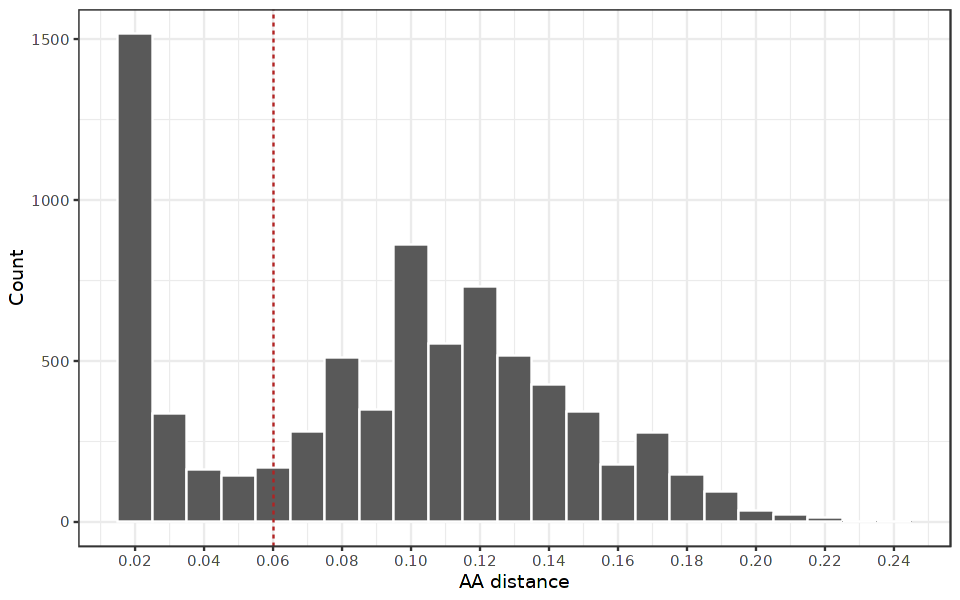

In [31]:
options(repr.plot.width=8, repr.plot.height=5)
p1 <- ggplot(subset(dist_ham, !is.na(dist_nearest)),
             aes(x=dist_nearest)) + 
    theme_bw() + 
    xlab("AA distance") + 
    ylab("Count") +
    scale_x_continuous(breaks=seq(0, 0.5, 0.02)) +
    geom_histogram(color="white", binwidth=0.01) +
    geom_vline(xintercept=0.06, color="firebrick", linetype=2)
plot(p1)

In [34]:
dist_ham <- distToNearest(cell_consensus_hc ,
                          sequenceColumn="CDR3nuc", 
                          vCallColumn="V_CALL", jCallColumn="J_CALL",
                          model="ham", normalize="len")

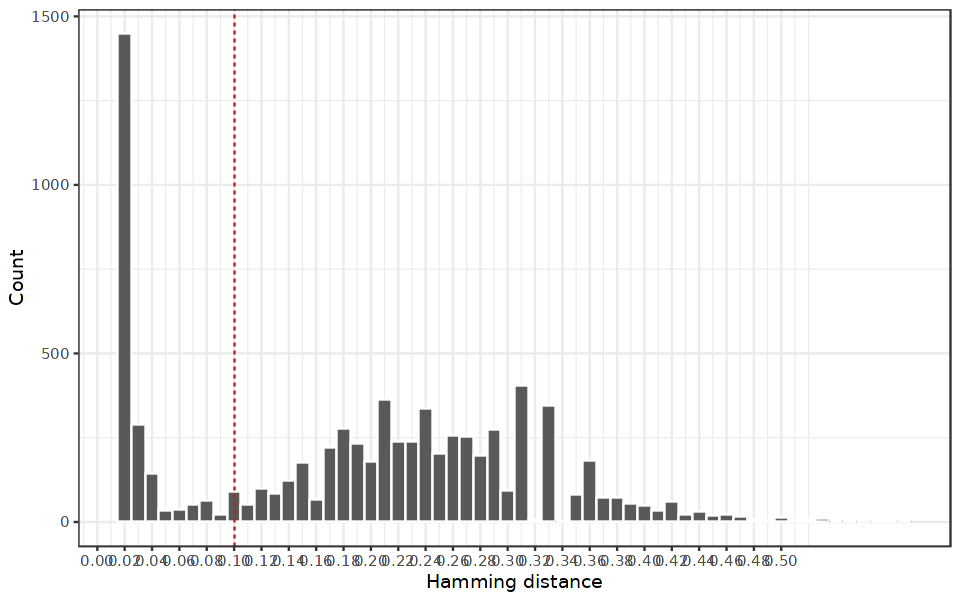

In [53]:
options(repr.plot.width=8, repr.plot.height=5)
p1 <- ggplot(subset(dist_ham, !is.na(dist_nearest)),
             aes(x=dist_nearest)) + 
    theme_bw() + 
    xlab("Hamming distance") + 
    ylab("Count") +
    scale_x_continuous(breaks=seq(0, 0.5, 0.02)) +
    geom_histogram(color="white", binwidth=0.01) +
    geom_vline(xintercept=0.1, color="firebrick", linetype=2)
plot(p1)

[1] 0.08554775

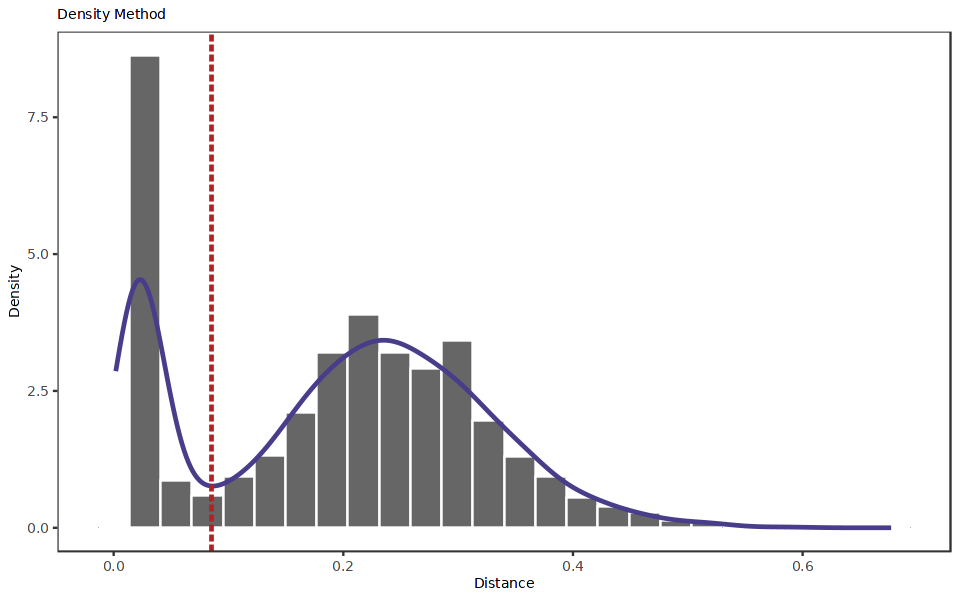

In [35]:
output <- findThreshold(dist_ham$dist_nearest, method="density",cutoff='opt') #method="density"
# "norm-norm", "norm-gamma", "gamma-norm", and "gamma-gamma"
threshold <- output@threshold
threshold
plot(output, title="Density Method")

[1] 0.06415542

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


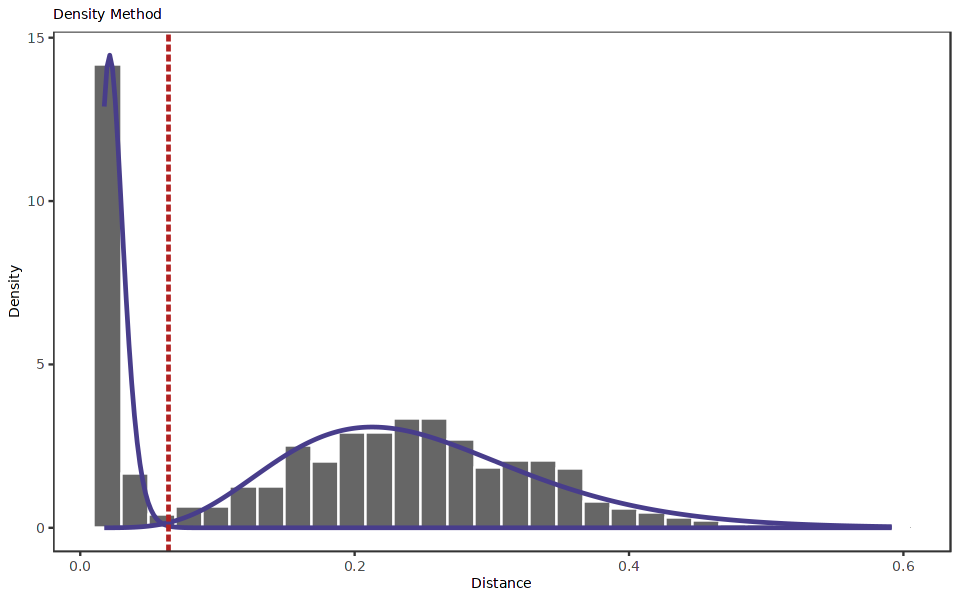

In [132]:
output <- findThreshold(dist_ham$dist_nearest, method="gmm",model="gamma-gamma",cutoff='opt') #method="density"
# "norm-norm", "norm-gamma", "gamma-norm", and "gamma-gamma"
threshold <- output@threshold
threshold
plot(output, title="Density Method")

[1] 0.05707776

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


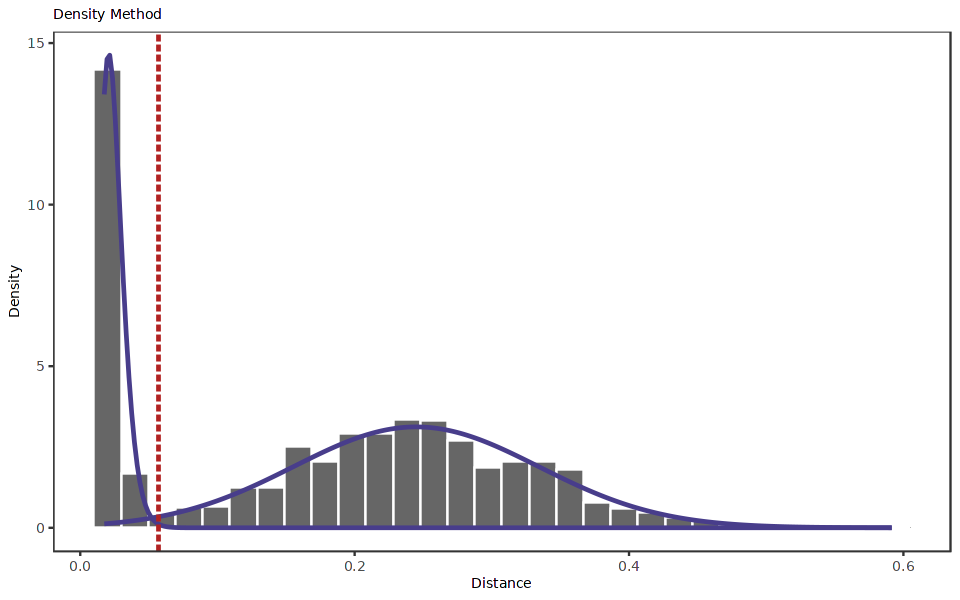

In [141]:
output <- findThreshold(dist_ham$dist_nearest, method="gmm",model="gamma-norm",cutoff='opt') #method="density"
# "norm-norm", "norm-gamma", "gamma-norm", and "gamma-gamma"
threshold <- output@threshold
threshold
plot(output, title="Density Method")

In [170]:
dist_ham <- distToNearest(cell_consensus_lc ,
                          sequenceColumn="CDR3nuc", 
                          vCallColumn="V_CALL", jCallColumn="J_CALL",
                          model="ham", normalize="len")

Warning message in distToNearest(cell_consensus_lc, sequenceColumn = "CDR3nuc", :
“Invalid sequence characters in the CDR3nuc column. 1 sequence(s) removed”


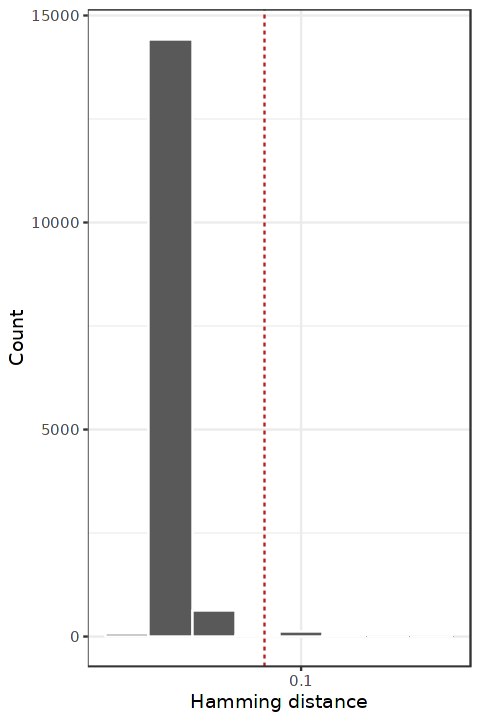

In [171]:
p1 <- ggplot(subset(dist_ham, !is.na(dist_nearest)),
             aes(x=dist_nearest)) + 
    theme_bw() + 
    xlab("Hamming distance") + 
    ylab("Count") +
    scale_x_continuous(breaks=seq(0, 1, 0.1)) +
    geom_histogram(color="white", binwidth=0.02) +
    geom_vline(xintercept=0.083, color="firebrick", linetype=2)
plot(p1)

## Add mouse grouping

In [8]:
srat = readRDS('md39/seurat_objects/04_md39_singlet_bcells.RDS')
srat

An object of class Seurat 
16002 features across 38027 samples within 2 assays 
Active assay: RNA (15992 features, 2000 variable features)
 1 other assay present: HTO
 2 dimensional reductions calculated: pca, umap

In [7]:
cell_consensus_hc = read.table('md39/processed_repertoire_data/04_hc_translated.tab',header=TRUE,sep='\t')

In [10]:
metadata = srat@meta.data
table(metadata$Group, metadata$Phenotype)

           
            Ag_neg   GC nonGC
  Naive       1051    0     0
  pSer         726  255  9408
  SMNP        3173 3052  6195
  pSer_SMNP    420 9870  3877

In [11]:
metadata = srat@meta.data
metadata$MOUSE = paste(metadata$Batch,metadata$Group,metadata$hash.ID,sep='_')
cell_consensus_hc$MOUSE = metadata$MOUSE[match(cell_consensus_hc$LANE_ID, metadata$id)]
cell_consensus_hc$Group = metadata$Group[match(cell_consensus_hc$LANE_ID, metadata$id)]
cell_consensus_hc$Phenotype = metadata$Phenotype[match(cell_consensus_hc$LANE_ID, metadata$id)]

In [12]:
head(cell_consensus_hc$MOUSE)
table(cell_consensus_hc$Group)
table(cell_consensus_hc$Phenotype)

[1] "AG_pSer_SMNP_HTO3" "AG_pSer_SMNP_HTO1" "AG_pSer_SMNP_HTO3"
[4] "AG_pSer_SMNP_HTO1" "AG_pSer_SMNP_HTO4" "AG_pSer_SMNP_HTO1"


    Naive      pSer      SMNP pSer_SMNP 
      317      2598      2568      3377 


Ag_neg     GC  nonGC 
  1222   2684   4954 

In [13]:
a = cell_consensus_hc %>% mutate(junction = CDR3nuc, v_call=V_CALL, j_call=J_CALL)
write.table(a,'md39/processed_repertoire_data/05_hc_pre_defineclones_airr.tab', quote = FALSE, row.names = FALSE, sep = '\t')

DefineClones.py -d 05_hc_pre_defineclones_airr.tab -o 06_hc_private_clones_airr.tab --act set --model ham --norm len --format airr --gf MOUSE --dist 0.1

In [14]:
b=read.table('md39/processed_repertoire_data/06_hc_private_clones_airr.tab',header=TRUE,sep='\t')

In [27]:
c = b %>% mutate(v_germline_start = v_germ_start_vdj)
write.table(c,'md39/processed_repertoire_data/06_hc_private_clones_airr.tab', quote = FALSE, row.names = FALSE, sep = '\t')

In [16]:
v_germline_start, d_germline_start, j_germline_start

[1] "sequence_id"         "sequence"            "rev_comp"           
 [4] "productive"          "v_call"              "d_call"             
 [7] "j_call"              "sequence_alignment"  "germline_alignment" 
[10] "junction"            "junction_aa"         "v_cigar"            
[13] "d_cigar"             "j_cigar"             "locus"              
[16] "np1_length"          "np2_length"          "junction_length"    
[19] "v_score"             "v_identity"          "d_score"            
[22] "d_identity"          "j_score"             "j_identity"         
[25] "cdr1"                "cdr2"                "cdr3"               
[28] "clone_id"            "sequence_input"      "functional"         
[31] "in_frame"            "stop"                "mutated_invariant"  
[34] "indels"              "sequence_vdj"        "sequence_imgt"      
[37] "v_seq_start"         "v_seq_length"        "v_germ_start_vdj"   
[40] "v_germ_length_vdj"   "v_germ_start_imgt"   "v_germ_length_imgt" 
[43] "d_seq_start"         "d_seq_length"        "d_germ_start"       
[46] "d_germ_length"       "j_seq_start"         "j_seq_length"       
[49] "j_germ_start"        "j_germ_length"       "germline_imgt"      
[52] "v_evalue"            "d_evalue"            "j_evalue"           
[55] "fwr1_imgt"           "fwr2_imgt"           "fwr3_imgt"          
[58] "fwr4_imgt"           "cdr1_imgt"           "cdr2_imgt"          
[61] "cdr3_imgt"           "isotype"             "isotype_freq"       
[64] "r1conscount"         "r1_cluster_fraction" "vprimer"            
[67] "vprimer_freq"        "r2conscount"         "r2_cluster_fraction"
[70] "error"               "length"              "overlap"            
[73] "pval"                "id"                  "sample"             
[76] "bc"                  "umi"                 "lane_id"            
[79] "sequence_trim"       "n_count"             "n_frac"             
[82] "consensus_sequence"  "consensus_seqcount"  "errordist"          
[85] "consensus_ambig"     "igm"                 "igd"                
[88] "igg"                 "iga"                 "fwr1nuc"            
[91] "cdr1nuc"             "fwr2nuc"             "cdr2nuc"            
[94] "fwr3nuc"             "junction_start"      "cdr3nuc"            
[97] "mouse"               "group"               "phenotype"

CreateGermlines.py -d 06_hc_private_clones_airr.tab -g dmask --cloned --format airr --sf consensus_sequence -r ../imgt_reference/imgt_mouse_IGHJ.fasta ../imgt_reference/imgt_mouse_IGHD.fasta ../imgt_reference/imgt_mouse_IGHV.fasta 

cd md39/processed_repertoire_data/

In [25]:
a = cell_consensus_hc %>% mutate(JUNCTION = CDR3nuc, JUNCTION_LENGTH = str_length(JUNCTION))
write.table(a,'md39/processed_repertoire_data/05_hc_pre_defineclones.tab', quote = FALSE, row.names = FALSE, sep = '\t')

Define clones by mouse:  

DefineClones.py -d 05_hc_pre_defineclones.tab -o 06_hc_private_clones.tab --act set --model ham --norm len --format changeo --sf CDR3nuc --gf MOUSE --dist 0.1

CreateGermlines.py -d 06_hc_private_clones.tab -g full dmask --cloned --format changeo --sf CONSENSUS_SEQUENCE -r ../imgt_reference/imgt_mouse_IGHJ.fasta ../imgt_reference/imgt_mouse_IGHD.fasta ../imgt_reference/imgt_mouse_IGHV.fasta --format changeo 

Define metaclones:

DefineClones.py -d 05_hc_pre_defineclones.tab -o 06_hc_meta_clones.tab --act set --model aa --norm len --format changeo --sf CDR3nuc --dist 0.2 --log meta_clone.log

DefineClones.py -d 05_hc_pre_defineclones.tab --outname 06_hc_meta2 --act set --model aa --norm len --format changeo --sf CDR3nuc --dist 0.06 --failed


CreateGermlines.py -d 06_hc_meta_clones.tab -g full dmask --cloned --format changeo --sf CONSENSUS_SEQUENCE -r ../imgt_reference/imgt_mouse_IGHJ.fasta ../imgt_reference/imgt_mouse_IGHD.fasta ../imgt_reference/imgt_mouse_IGHV.fasta --format changeo 

In [61]:
cell_consensus_hc = read.table('md39/processed_repertoire_data/06_hc_private_clones_germ-pass.tab',
                stringsAsFactors = FALSE, header = TRUE, sep = '\t') 
dim(cell_consensus_hc)
cell_consensus_lc = read.table('md39/processed_repertoire_data/04_lc_translated.tab',
                stringsAsFactors = FALSE, header = TRUE, sep = '\t') 
dim(cell_consensus_lc)

[1] 8799   97

[1] 15471    87

In [62]:
metadata = gc@meta.data
hc.match = cell_consensus_hc %>% filter(LANE_ID %in% metadata$id)
lc.match = cell_consensus_lc %>% filter(LANE_ID %in% metadata$id)

metadata$IGH_recovery = as.numeric(metadata$id %in% cell_consensus_hc$LANE_ID) * 2
metadata$IGL_recovery = as.numeric(metadata$id %in% cell_consensus_lc$LANE_ID)
metadata$Recovery = metadata$IGH_recovery + metadata$IGL_recovery

# add heavy chain info to metadata 
a = hc.match[c('LANE_ID','VPRIMER','ISOTYPE','CDR3NUC','CDR3','CLONE','GERMLINE_V_CALL')]
colnames(a)<-paste('IGH',colnames(a),sep="_")
metadata = merge(metadata, a,by.x='id', by.y='IGH_LANE_ID', all.x=TRUE)
rownames(metadata)= metadata$id
metadata = metadata %>% dplyr::rename('CLONE'='IGH_CLONE')

# add light chain info to metadata 
b = lc.match[c('LANE_ID','VPRIMER','ISOTYPE','CDR3nuc','CDR3','V_CALL')]
# keep the first light chain v gene when ambiguious 
b = b %>% mutate(V_CALL = str_split_i(V_CALL,',',1))
colnames(b)<-paste('IGL',colnames(b),sep="_")
b = b %>% mutate(IGL_V_CALL = str_split_i(IGL_V_CALL,',',1))
metadata = merge(metadata, b,by.x='id', by.y='IGL_LANE_ID', all.x=TRUE)
rownames(metadata)= metadata$id


Warning message in countClones(metadata, clone = "CLONE"):
“NA(s) found in 8945 row(s) of the CLONE column and excluded from tabulation”


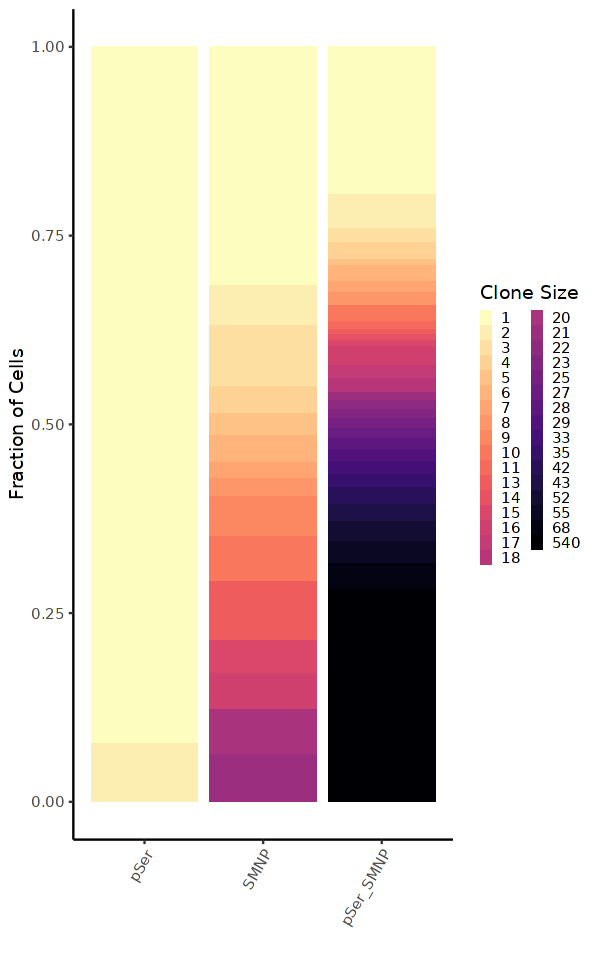

In [63]:
options(repr.plot.height=8, repr.plot.width=5)
count = countClones(metadata,clone='CLONE')
metadata$clonal.size=count$seq_count[match(metadata$CLONE,count$CLONE)]

metadata %>% filter(IGH_ISOTYPE!='NA') %>% 
ggplot(aes(x=Group, fill=factor(clonal.size))) + theme_classic() + 
geom_bar(position='fill') + 
labs(x='',y='Fraction of Cells',fill='Clone Size') + 
scale_fill_viridis(discrete=TRUE, direction=-1, option='magma', na.value='grey')+ 
theme(axis.text.x=element_text(angle=60,hjust=1)) +# NoLegend()
guides(fill = guide_legend(keywidth = 0.5, keyheight = 0.2,ncol = 2))


## Test out pairing diversity Sept 5 2023

In [3]:
data = readRDS('md39/processed_repertoire_data/00_md39_HC_LC_combined.RDS')
gc = readRDS('md39/seurat_objects/06_md39_labeled_gc5.RDS')

In [43]:
# filter raw seq data 
count.cutoff = 5 ## Change 
clus.frac.cutoff = 0.5 ## Change 
matched = data %>% filter(FUNCTIONAL==TRUE, N_count<5, 
                           R2CONSCOUNT>=count.cutoff,R1CONSCOUNT>=count.cutoff,
                           R1_CLUSTER_FRACTION>clus.frac.cutoff, R2_CLUSTER_FRACTION>clus.frac.cutoff,
                           LANE_ID %in% gc$id) 
hc.match = matched %>% filter(LOCUS=='IGH') 
lc.match = matched %>% filter(LOCUS!='IGH') 

In [44]:
cell_consensus_hc = hc.match %>% group_by(LANE_ID) %>% arrange(desc(R2CONSCOUNT)) %>% slice(1) %>% ungroup()
cell_consensus_hc$CONSENSUS_SEQUENCE = cell_consensus_hc$SEQUENCE_IMGT
cell_consensus_lc = lc.match %>% group_by(LANE_ID) %>% arrange(desc(R2CONSCOUNT)) %>% slice(1) %>% ungroup()
cell_consensus_lc$CONSENSUS_SEQUENCE = cell_consensus_lc$SEQUENCE_IMGT


In [45]:
library(alakazam)
library(stringr)
cell_consensus_hc[,c('FWR1nuc', 'CDR1nuc', 'FWR2nuc', 'CDR2nuc', 'FWR3nuc')]= extractVRegion(cell_consensus_hc$CONSENSUS_SEQUENCE, region = c('fwr1', 'cdr1', 'fwr2', 'cdr2', 'fwr3')) %>% as.data.frame()
cell_consensus_hc$JUNCTION_START = NA
cell_consensus_hc$CDR3nuc = NA
dim(cell_consensus_hc)

cell_consensus_hc = cell_consensus_hc %>% filter(FWR3nuc != '')
dim(cell_consensus_hc)
for (i in 1:nrow(cell_consensus_hc)) {
    
    # The JUNCTION column includes one codon from FWR3 and FWR4, hence subtract 3 to match with JUNCTION column
    cell_consensus_hc$JUNCTION_START[i] = as.numeric(gregexpr(cell_consensus_hc$CONSENSUS_SEQUENCE[i], pattern = cell_consensus_hc$FWR3nuc[i])) + str_length(cell_consensus_hc$FWR3nuc[i])-3 
    # CDR3nuc is different from CDR3_IMGT in that this is the equivalent JUNCTION column based on CONSENSUS_SEQUENCE
    cell_consensus_hc$CDR3nuc[i] = substring(cell_consensus_hc$CONSENSUS_SEQUENCE[i], cell_consensus_hc$JUNCTION_START[i], cell_consensus_hc$JUNCTION_START[i] + str_length(cell_consensus_hc$JUNCTION[i]) -1)
}

cell_consensus_lc[,c('FWR1nuc', 'CDR1nuc', 'FWR2nuc', 'CDR2nuc', 'FWR3nuc')]= extractVRegion(cell_consensus_lc$CONSENSUS_SEQUENCE, region = c('fwr1', 'cdr1', 'fwr2', 'cdr2', 'fwr3')) %>% as.data.frame()
cell_consensus_lc$JUNCTION_START = NA
cell_consensus_lc$CDR3nuc = NA
dim(cell_consensus_lc)

cell_consensus_lc = cell_consensus_lc %>% filter(FWR3nuc != '')
dim(cell_consensus_lc)

for (i in 1:nrow(cell_consensus_lc)) {
    if (lengths(gregexpr(cell_consensus_lc$CONSENSUS_SEQUENCE[i], pattern = cell_consensus_lc$FWR3nuc[i]))>1) {
        next
    }
    cell_consensus_lc$JUNCTION_START[i] = as.numeric(gregexpr(cell_consensus_lc$CONSENSUS_SEQUENCE[i], pattern = cell_consensus_lc$FWR3nuc[i])) + str_length(cell_consensus_lc$FWR3nuc[i])-3
    cell_consensus_lc$CDR3nuc[i] = substring(cell_consensus_lc$CONSENSUS_SEQUENCE[i], cell_consensus_lc$JUNCTION_START[i], cell_consensus_lc$JUNCTION_START[i] + str_length(cell_consensus_lc$JUNCTION[i]) -1)
}


[1] 2825   79

[1] 2817   79

[1] 6567   79

[1] 6563   79

In [46]:
metadata = gc@meta.data
metadata$MOUSE = paste(metadata$Batch,metadata$Group,metadata$hash.ID,sep='_')
cell_consensus_hc$MOUSE = metadata$MOUSE[match(cell_consensus_hc$LANE_ID, metadata$id)]
cell_consensus_hc$Group = metadata$Group[match(cell_consensus_hc$LANE_ID, metadata$id)]
cell_consensus_hc$Phenotype = metadata$Phenotype[match(cell_consensus_hc$LANE_ID, metadata$id)]

a = cell_consensus_hc %>% mutate(JUNCTION = CDR3nuc, JUNCTION_LENGTH = str_length(JUNCTION))
write.table(a,'md39/processed_repertoire_data/exp_with_cutoffs/hc_pre_defineclones_conscount4.tab', 
            quote = FALSE, row.names = FALSE, sep = '\t')

DefineClones.py -d hc_pre_defineclones_conscount4.tab -o hc_private_clones_conscount4.tab --act set --model ham --norm len --format changeo --sf CDR3nuc --gf MOUSE --dist 0.1

CreateGermlines.py -d hc_private_clones_conscount4.tab -g full dmask --cloned --format changeo --sf CONSENSUS_SEQUENCE -r ../../imgt_reference/imgt_mouse_IGHJ.fasta ../../imgt_reference/imgt_mouse_IGHD.fasta ../../imgt_reference/imgt_mouse_IGHV.fasta --format changeo 

In [48]:
hc = read.table('md39/processed_repertoire_data/exp_with_cutoffs/hc_private_clones_conscount4_germ-pass.tab',
                stringsAsFactors = FALSE, header = TRUE, sep = '\t') 
lc = cell_consensus_lc 

gc = readRDS('md39/seurat_objects/06_md39_labeled_gc5.RDS')
metadata = gc@meta.data
hc.match = hc %>% filter(hc$LANE_ID %in% metadata$id)
lc.match = lc %>% filter(lc$LANE_ID %in% metadata$id)
metadata$IGH_recovery = as.numeric(metadata$id %in% hc$LANE_ID) * 2
metadata$IGL_recovery = as.numeric(metadata$id %in% lc$LANE_ID)
metadata$Recovery = metadata$IGH_recovery + metadata$IGL_recovery

# add heavy chain info to metadata 
a = hc.match[c('LANE_ID','VPRIMER','ISOTYPE','CDR3NUC',#'CDR3',
               'CLONE','GERMLINE_V_CALL')] #,'mu_count','mu_freq'
colnames(a)<-paste('IGH',colnames(a),sep="_")
metadata = merge(metadata, a,by.x='id', by.y='IGH_LANE_ID', all.x=TRUE)
rownames(metadata)= metadata$id
metadata = metadata %>% dplyr::rename('CLONE'='IGH_CLONE')

# add light chain info to metadata 
b = lc.match[c('LANE_ID','VPRIMER','ISOTYPE','CDR3nuc','V_CALL')] # 'CDR3','mu_count','mu_freq'
colnames(b)<-paste('IGL',colnames(b),sep="_") 
b = b %>% mutate(IGL_V_CALL = str_split_i(IGL_V_CALL,',',1))
metadata = merge(metadata, b,by.x='id', by.y='IGL_LANE_ID', all.x=TRUE)
rownames(metadata)= metadata$id
gc@meta.data = metadata 

[1] 1953   48

`summarise()` has grouped output by 'Group', 'Mouse', 'CLONE',
'IGH_GERMLINE_V_CALL'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'Group', 'Mouse', 'IGH_GERMLINE_V_CALL'.
You can override using the `.groups` argument.
`summarise()` has grouped output by 'Group'. You can override using the
`.groups` argument.
Warning message in wilcox.test.default(c(0, 1.38629436111989, 0, 0, 0.693147180559945, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0, 1.38629436111989, 0, 0, 0.693147180559945, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(2.70805020110221, 3.55692361835119, 1.79175946922805, :
“cannot compute exact p-value with ties”


  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = div ~ Group, data = df4gg)

$Group
                              diff        lwr      upr     p adj
SMNP-alum-pSer           1.7943821  0.6438569 2.944907 0.0018096
alum-pSer/SMNP-alum-pSer 2.3105874  1.2454081 3.375767 0.0000349
alum-pSer/SMNP-SMNP      0.5162053 -0.4164604 1.448871 0.3681095


Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Benjamini-Hochberg method.




                  Comparison         Z      P.unadj        P.adj
1 alum-pSer - alum-pSer/SMNP -3.604199 0.0003131171 0.0009393513
2           alum-pSer - SMNP -2.120062 0.0340007942 0.0510011913
3      alum-pSer/SMNP - SMNP  1.501002 0.1333550111 0.1333550111

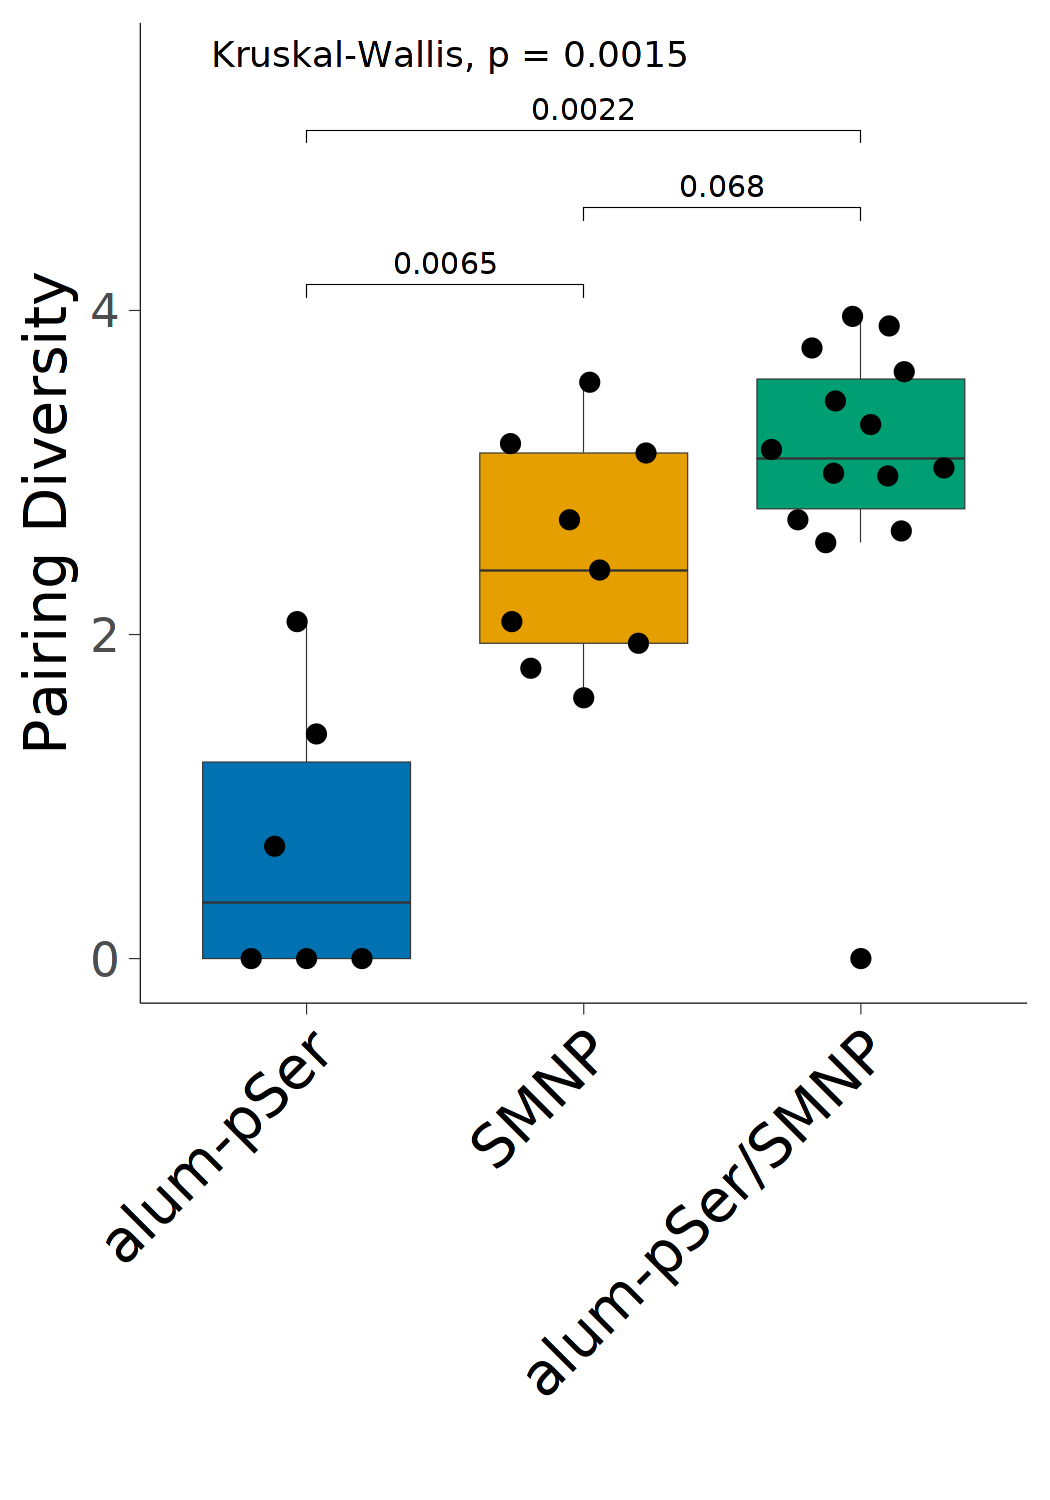

In [50]:
metadata = gc@meta.data %>% filter(Recovery==3) 

# keep the first light chain v gene when ambiguious 
df = metadata %>% mutate(IGL_V_CALL = str_split_i(IGL_V_CALL,',',1))
dim(df)

# remove allele info 
df = df %>% dplyr::select(Group,  Mouse,Phenotype, CLONE, IGH_GERMLINE_V_CALL,IGL_V_CALL)
df = df %>% mutate(IGH_GERMLINE_V_CALL = str_split_i(IGH_GERMLINE_V_CALL,'\\*',1), 
                               IGL_V_CALL = str_split_i(IGL_V_CALL,'\\*',1))

# if a clone has more than one paired light chain, keep the light chain with greater 
# number of cells in the clone 
df = df %>% group_by(Group,Mouse,CLONE,IGH_GERMLINE_V_CALL,IGL_V_CALL) %>% 
summarize(nigl.clone = n()) %>% mutate(ncell.clone=sum(nigl.clone)) %>%
arrange(desc(nigl.clone)) %>% dplyr::slice(1) %>% ungroup()

# remove mice with less than 2 cells 
df = df %>% group_by(Group,Mouse) %>% mutate(ncell.mouse=sum(ncell.clone)) #%>% filter(ncell.mouse>1)

# calculate the pairing diversity 
df4gg = df %>% group_by(Group, Mouse, IGH_GERMLINE_V_CALL,IGL_V_CALL) %>% 
    summarize(npairing=n()) %>% ungroup() %>% group_by(Group,Mouse) %>%
    summarize(div=vegan::diversity(npairing))

options(repr.plot.width=3.5, repr.plot.height=5,repr.plot.res=300)

my.comparison = list(c('alum-pSer','SMNP'),c('SMNP','alum-pSer/SMNP'),c('alum-pSer','alum-pSer/SMNP'))

df4gg %>% 
ggplot(aes(x=Group, y=div, fill=Group)) + theme_classic()+ NoLegend()+
geom_boxplot(outlier.shape=NA,size=0.1) + 
geom_quasirandom() + 

scale_fill_manual(values=c('#0072B2','#E69F00','#009E73')) +
stat_compare_means(method = "wilcox.test",label = 'p.format',bracket.size = 0.1,
                   tip.length = 0.02,comparisons = my.comparison, size=2.5)+
ylim(0,5.5) +
stat_compare_means(method = "kruskal.test", size=3)+ 

labs(y='Pairing Diversity', x='') + 
theme(text = element_text(color = "black",size=14),
      axis.text.x=element_text(size=14,angle=45,hjust=1,color = "black"),
      axis.title.y=element_text(size=14),
      #legend.text = element_text(size = 12),
      strip.text=element_text(size=14,color=('white'),face='bold'),
      strip.background = element_rect(color = "black", linewidth = 0.1),
      axis.line = element_line(linewidth=0.1),
      axis.ticks = element_line(linewidth = 0.1),
      panel.grid = element_blank()) 

TukeyHSD(aov(div ~ Group,data=df4gg))
FSA::dunnTest(div ~ Group,data= df4gg,method="bh")



`summarise()` has grouped output by 'Group', 'Mouse'. You can override using
the `.groups` argument.
Warning message:
“There were 4 warnings in `summarize()`.
The first warning was:
ℹ In argument: `div = vegan::diversity(ncell.clone.mouse, base = n())`.
ℹ In group 1: `Group = alum-pSer`, `Mouse = "AG_HTO3"`.
Caused by warning in `log()`:
! NaNs produced
ℹ Run `dplyr::last_dplyr_warnings()` to see the 3 remaining warnings.”
`summarise()` has grouped output by 'Group'. You can override using the
`.groups` argument.


  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = div ~ Group, data = df4gg)

$Group
                               diff        lwr         upr     p adj
SMNP-alum-pSer           -0.1431419 -0.3344081  0.04812429 0.1706269
alum-pSer/SMNP-alum-pSer -0.2622115 -0.4392896 -0.08513336 0.0029772
alum-pSer/SMNP-SMNP      -0.1190695 -0.2741183  0.03597917 0.1564491


Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Benjamini-Hochberg method.




                  Comparison         Z      P.unadj      P.adj
1 alum-pSer - alum-pSer/SMNP -3.370041 0.0007515701 0.00225471
2           alum-pSer - SMNP -1.894826 0.0581154707 0.08717321
3      alum-pSer/SMNP - SMNP  1.511424 0.1306805358 0.13068054

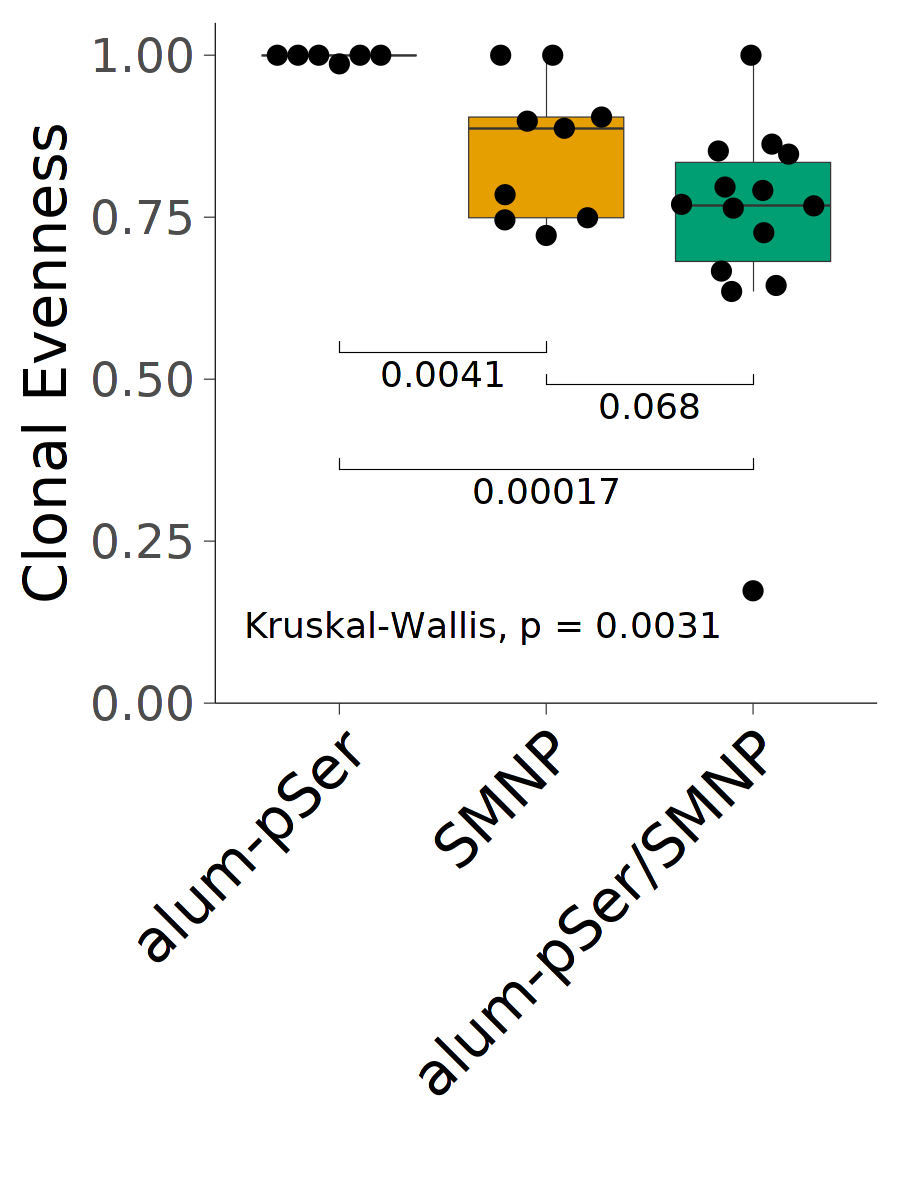

In [51]:
metadata = gc@meta.data 
df4gg = metadata %>% filter(CLONE>0) %>% 
group_by(Group, Mouse, CLONE) %>% summarize(ncell.clone.mouse = n()) %>% 
summarize(div = vegan::diversity(ncell.clone.mouse, base=n()),ncell.mouse = sum(ncell.clone.mouse)) 

df4gg=df4gg %>% filter(ncell.mouse > 1)

options(repr.plot.width=3, repr.plot.height=4,repr.plot.res=300)

my.comparison = list(c('alum-pSer','SMNP'),c('SMNP','alum-pSer/SMNP'),c('alum-pSer','alum-pSer/SMNP'))

curr.fig = df4gg %>% 
ggplot(aes(x=Group, y=div, fill=Group)) + theme_classic()+ NoLegend()+
geom_boxplot(outlier.shape=NA,size=0.1) + 
geom_quasirandom() + 

scale_fill_manual(values=c('#0072B2','#E69F00','#009E73')) +
stat_compare_means(method = "t.test",label = 'p.format',label.y=c(0.5,0.45,0.32),vjust=2,
                   tip.length = -0.02,size=3,comparisons=my.comparison, bracket.size=0.1)+
stat_compare_means(method = "kruskal.test", size=3, label.y=0.1)+
labs(y='Clonal Evenness', x='') + 
scale_y_continuous(limits=c(0,1.05),expand =c(0,0)) +
theme(text = element_text(color = "black",size=14),
      axis.text.x=element_text(size=14,angle=45,hjust=1,color = "black"),
      axis.title.y=element_text(size=14),
      strip.text=element_text(size=14,color=('white'),face='bold'),
      strip.background = element_rect(color = "black", linewidth = 0.1),
      axis.line = element_line(linewidth=0.1),
      axis.ticks = element_line(linewidth = 0.1),
      panel.grid = element_blank()) 

show(curr.fig)

TukeyHSD(aov(div ~ Group,data=df4gg))
FSA::dunnTest((1-div) ~ Group,
         data= df4gg , 
         method="bh")

`summarise()` has grouped output by 'Group', 'Mouse'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'Group'. You can override using the
`.groups` argument.


  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = log10(richness) ~ Group, data = df4gg)

$Group
                              diff         lwr       upr     p adj
SMNP-alum-pSer           0.7398290  0.26214231 1.2175157 0.0017670
alum-pSer/SMNP-alum-pSer 1.1431982  0.69901079 1.5873856 0.0000016
alum-pSer/SMNP-SMNP      0.4033692 -0.02708722 0.8338256 0.0697067


Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Benjamini-Hochberg method.




                  Comparison         Z      P.unadj        P.adj
1 alum-pSer - alum-pSer/SMNP -4.279735 1.871157e-05 5.613471e-05
2           alum-pSer - SMNP -2.082397 3.730618e-02 3.730618e-02
3      alum-pSer/SMNP - SMNP  2.105372 3.525893e-02 5.288839e-02

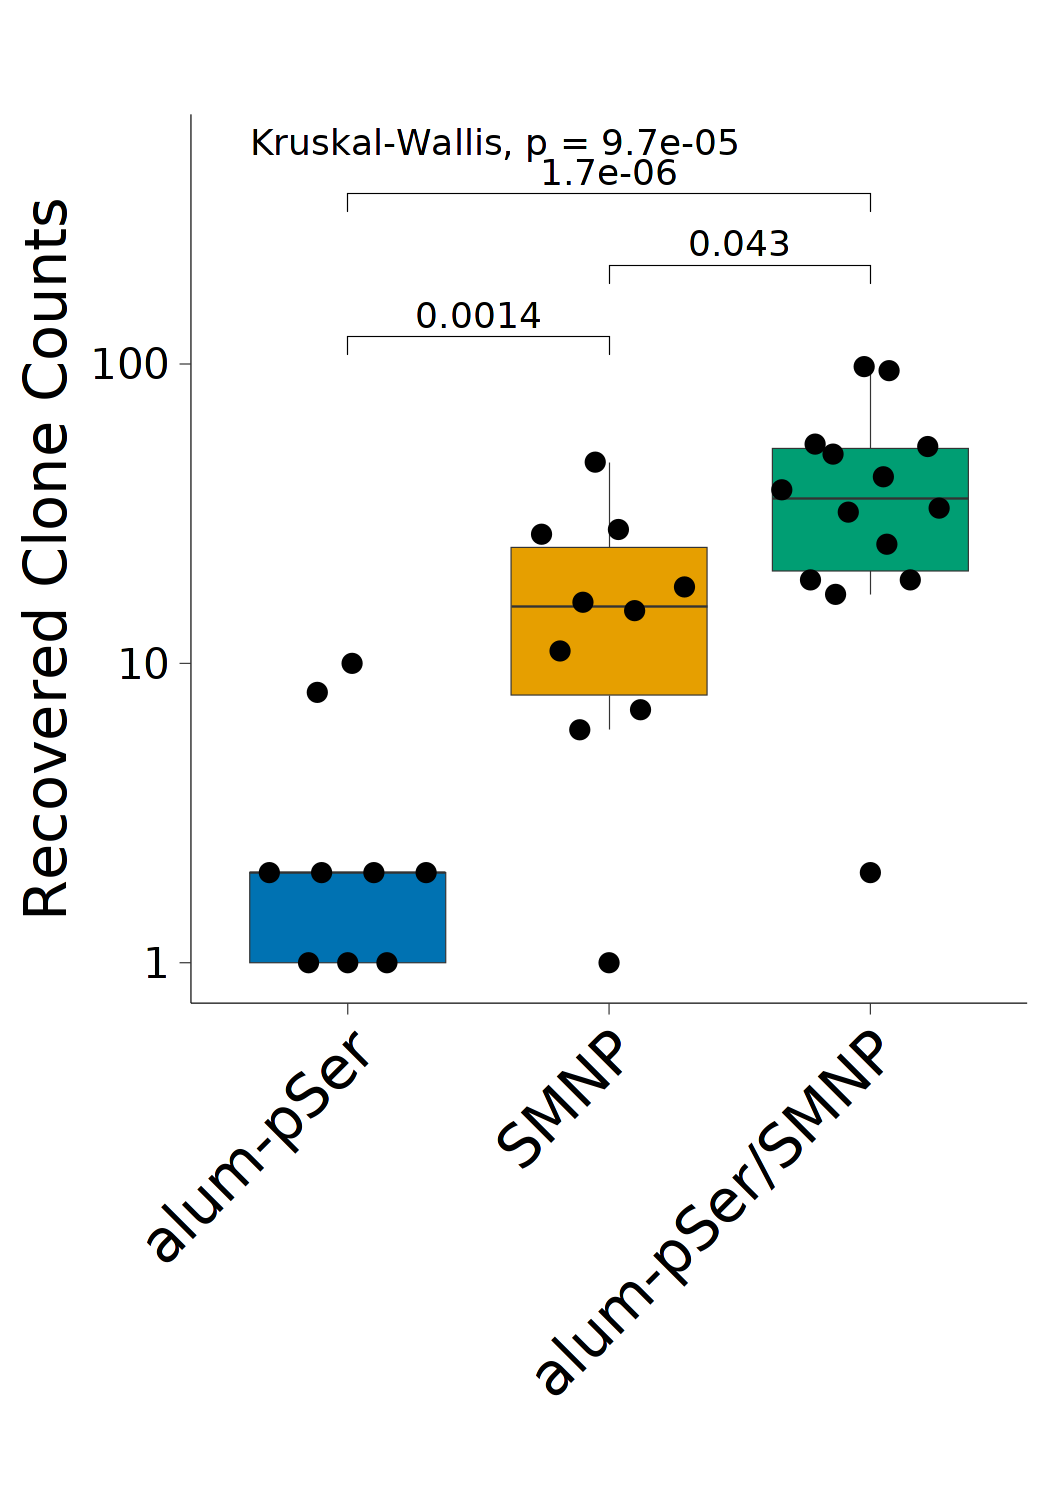

In [52]:
options(repr.plot.width=3.5, repr.plot.height=5,repr.plot.res=300)

metadata = gc@meta.data

df4gg = metadata %>% filter(CLONE>0) %>% 
group_by(Group, Mouse, CLONE) %>% summarize(ncell.clone = n()) %>% 
summarize(richness = n(),ncell.mouse = sum(ncell.clone)) #%>% filter(ncell.mouse > 1)

my.comparison = list(c('alum-pSer','SMNP'),c('SMNP','alum-pSer/SMNP'),c('alum-pSer','alum-pSer/SMNP'))

curr.fig = df4gg %>% 
ggplot(aes(x=Group, y=richness, fill=Group)) + theme_classic()+ NoLegend()+
geom_boxplot(outlier.shape=NA, size=0.1) + 
geom_quasirandom() + 
scale_fill_manual(values=c('#0072B2','#E69F00','#009E73')) +
scale_y_log10(limits=c(1,500))+
stat_compare_means(method = "t.test",label = 'p.format',size=3,comparisons=my.comparison,
                   label.y.npc='top', bracket.size=0.1)+
stat_compare_means(method = "kruskal.test", size=3, label.y.npc='top')+
scale_color_gradient(low = "black", high = "grey80")+ 
labs(y='Recovered Clone Counts', x='', title='') + 
theme(text = element_text(color = "black",size=14),
      axis.text.x=element_text(size=14,angle=45,hjust=1,color = "black"),
      axis.text.y=element_text(size=10,color = "black"),
      axis.title.y=element_text(size=14),
      strip.text=element_text(size=14,color=('white'),face='bold'),
      strip.background = element_rect(color = "black", linewidth = 0.1),
      axis.line = element_line(linewidth=0.1),
      axis.ticks = element_line(linewidth = 0.1),
      panel.grid = element_blank()) 
show(curr.fig)

TukeyHSD(aov(log10(richness) ~ Group,data=df4gg))
FSA::dunnTest(richness ~ Group,data= df4gg ,method="bh")

`summarise()` has grouped output by 'Group', 'Mouse', 'clone.type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'mouse.id', 'seurat_clusters'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'mouse.id'. You can override using the
`.groups` argument.
Warning message in wilcox.test.default(c(0.5, 0.244897959183673, 0.28735632183908, :
“cannot compute exact p-value with ties”



	Wilcoxon signed rank test with continuity correction

data:  a$frac.x and a$frac.y
V = 2525.5, p-value = 0.7244
alternative hypothesis: true location shift is not equal to 0


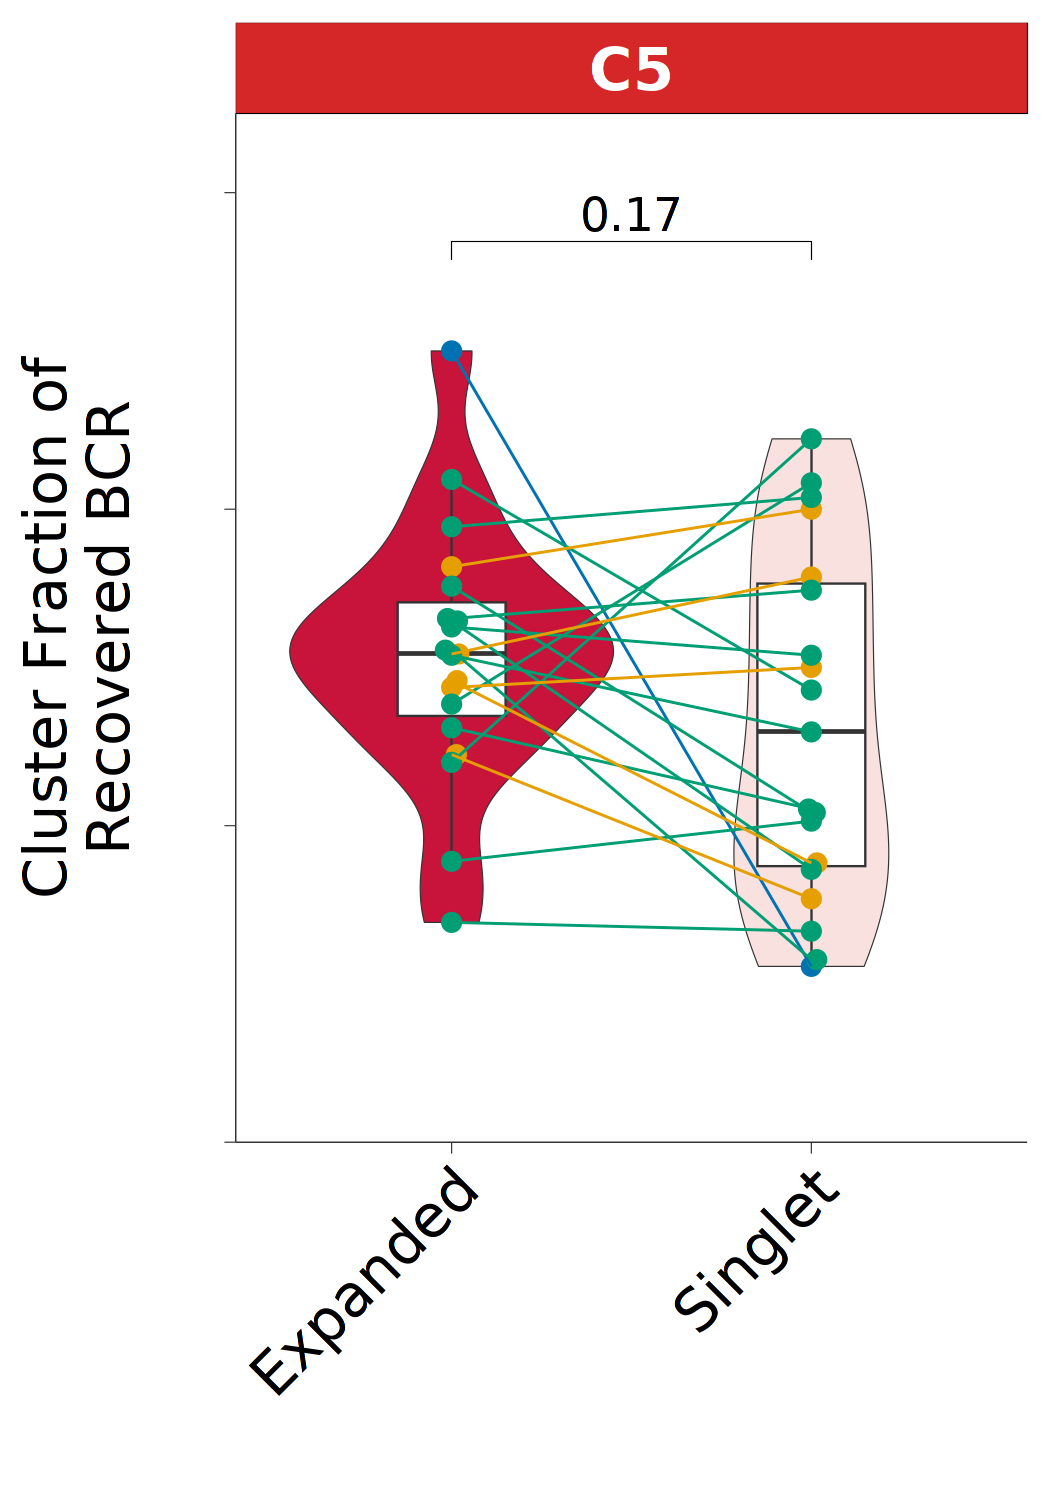

In [67]:
options(repr.plot.height=5, repr.plot.width=3.5, repr.plot.res=300)
metadata = gc@meta.data %>% filter(CLONE>0)
count <- countClones(metadata, clone = 'CLONE')
metadata$clonal.size <- count$seq_count[match(metadata$CLONE, count$CLONE)]
metadata = metadata %>% mutate(clone.type = ifelse(clonal.size>1,'Expanded','Singlet'))

col=ggthemes::ggthemes_data[["tableau"]][["color-palettes"]][["regular"]]$`Classic 10`$value
col=rev(col[1:7])
col = c(col[1:3],col[5],col[4],col[7],col[6])
strip = ggh4x::strip_themed(background_x = ggh4x::elem_list_rect(fill = col[5]))

# calculate fraction 
df4gg = metadata %>% group_by(Group,Mouse,clone.type,seurat_clusters)  %>%
summarise(ncell.clus.type=n()) %>% 
mutate(ncell.type=sum(ncell.clus.type),frac=ncell.clus.type/ncell.type,mouse.id = paste(Group,Mouse,seurat_clusters))

# only keep mouse that have both expanded and singlets 
mouse2keep = df4gg %>% ungroup() %>% group_by(mouse.id,seurat_clusters,clone.type) %>% summarise(ntype=n()) %>%
summarise(ntype=sum(ntype)) %>% filter(ntype>1)
df4gg = df4gg %>% filter(mouse.id %in% mouse2keep$mouse.id, seurat_clusters !='C1') 

df4gg %>% filter(seurat_clusters == 'C5') %>% 
ggplot(aes(x=clone.type,y=frac)) + theme_classic() + NoLegend()+
geom_violin(aes(fill=clone.type),size=0.1)+
geom_boxplot(fill='white',outlier.shape=NA,size=0.2,width=0.3) + 
geom_beeswarm(aes(color=Group)) + 
geom_line(aes(group= mouse.id,color=Group),linewidth=0.25) +
scale_y_continuous(expand=c(0,0),limits=c(0,0.65))+
stat_compare_means(method='wilcox.test',comparisons=list(c('Expanded','Singlet')),label.y=0.55,
                   bracket.size = 0.1) +
ggh4x::facet_wrap2('seurat_clusters',strip = strip,ncol=3) + #facet_wrap('seurat_clusters')+
labs(x='',y='Cluster Fraction of\nRecovered BCR') +
scale_color_manual(values=c('#0072B2','#E69F00','#009E73')) +
scale_fill_manual(values=c('#c8133b','#ea878340')) + 
theme(text = element_text(color = "black",size=14),
      axis.text.x=element_text(size=14,angle=45,hjust=1,color = "black"),
      axis.text.y=element_text(size=10,color = "white"),
      axis.title.y=element_text(size=14),
      #legend.text = element_text(size = 12),
      strip.text=element_text(size=14,color=('white'),face='bold'),
      strip.background = element_rect(color = "black", linewidth = 0.1),
      axis.line = element_line(linewidth=0.1),
      axis.ticks = element_line(linewidth = 0.1),
      panel.grid = element_blank()) 

x = df4gg[df4gg$clone.type=='Expanded' & df4gg$seurat_clusters=='C5',c('frac','mouse.id')]
y = df4gg[df4gg$clone.type=='Singlet' & df4gg$seurat_clusters=='C5',c('frac','mouse.id')]
a = merge(x,y,by='mouse.id')
wilcox.test(a$frac.x, a$frac.y, paired = TRUE, alternative = "two.sided")


	Wilcoxon signed rank exact test

data:  a$frac.x and a$frac.y
V = 125, p-value = 0.2413
alternative hypothesis: true location shift is not equal to 0


`summarise()` has grouped output by 'CLONE'. You can override using the
`.groups` argument.


[1] "clus.frac>=0.5, conscount>=5, ncell.per.clone>=6"


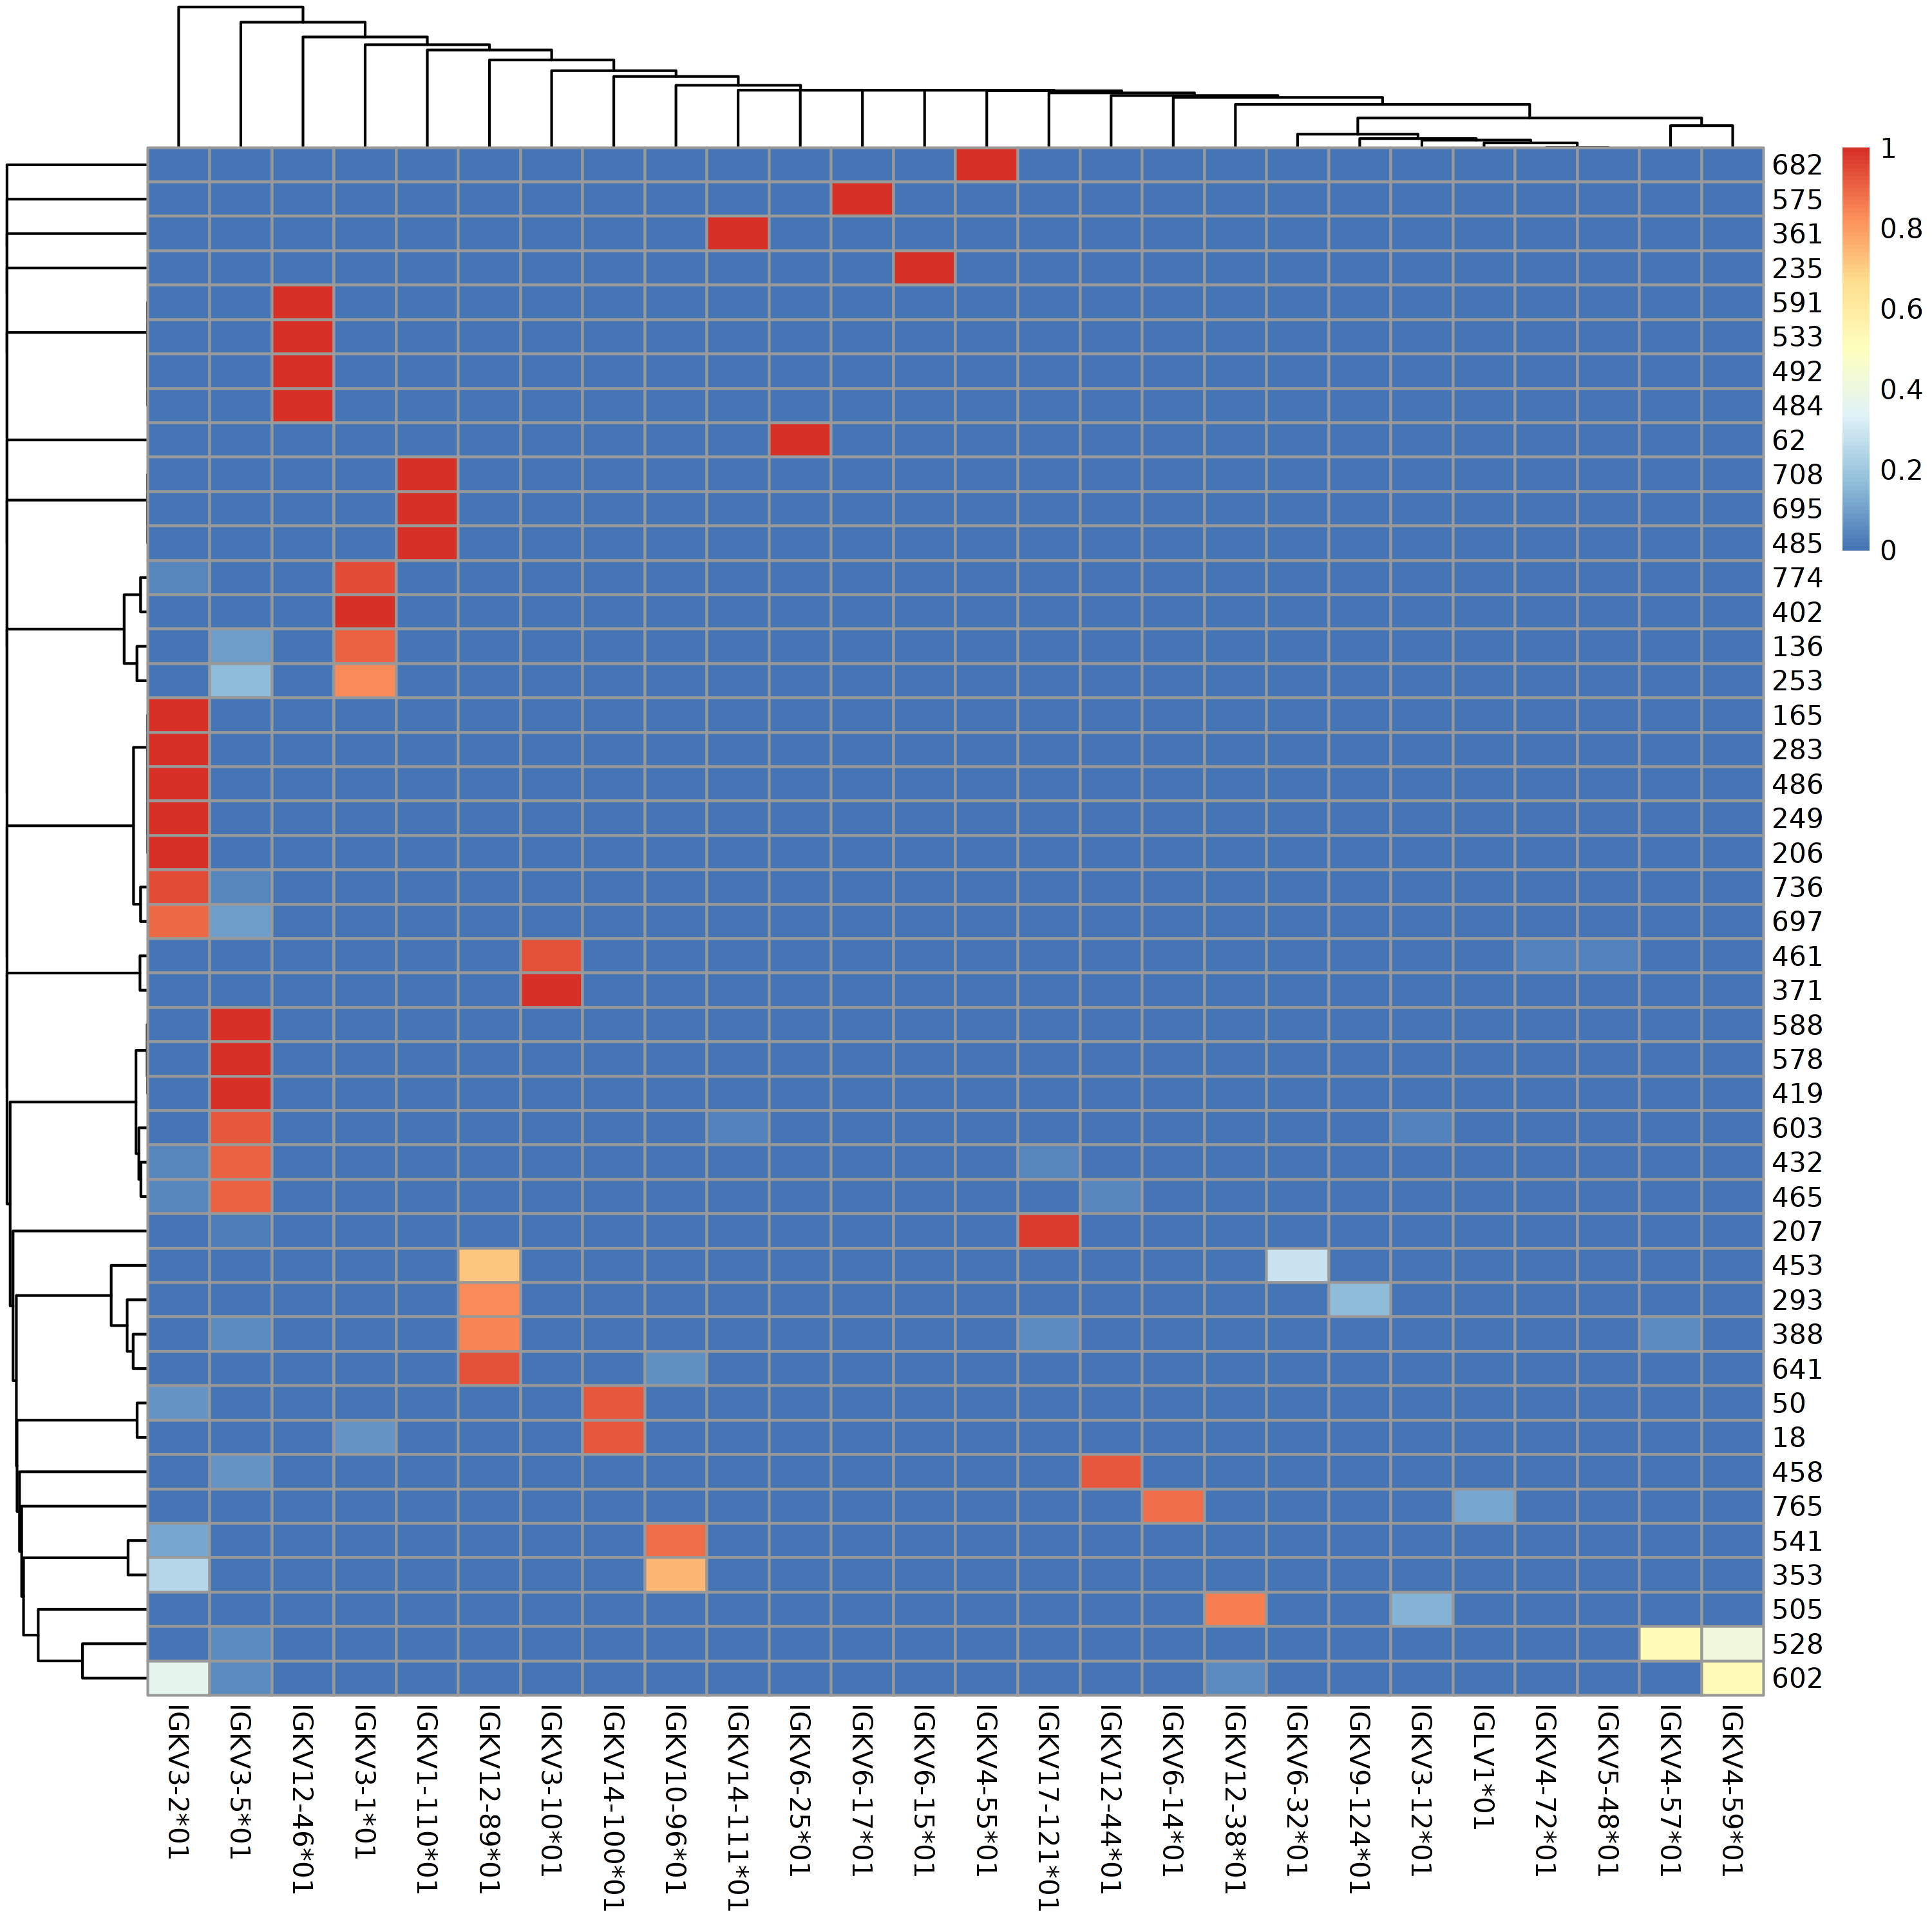

In [49]:
test = metadata %>% filter(Recovery==3) 
df = test %>% group_by(CLONE, IGL_V_CALL) %>% summarize(ncell.clone.igl=n()) %>% 
mutate(ncell.clone=sum(ncell.clone.igl)) %>% filter(ncell.clone>5) 

df2 = dcast(df,CLONE~IGL_V_CALL,value.var='ncell.clone.igl') %>% replace(is.na(.),0) 
rownames(df2) = df2$CLONE
mtx = df2 %>% select(-CLONE) %>% as.matrix()
mtx = mtx[order(rowSums(mtx),decreasing=TRUE),]
mtx2 = mtx/rowSums(mtx)
print(sprintf('clus.frac>=%.1f, conscount>=%d, ncell.per.clone>=%d',
              min(hc.match$R1_CLUSTER_FRACTION),min(hc.match$R1CONSCOUNT),min(df$ncell.clone)))
options(repr.plot.height=10, repr.plot.width=10)
pheatmap::pheatmap(mtx2, cluster_rows=T)

`summarise()` has grouped output by 'CLONE'. You can override using the
`.groups` argument.


[1] "clus.frac>=0.5, conscount>=6, ncell.per.clone>=6"


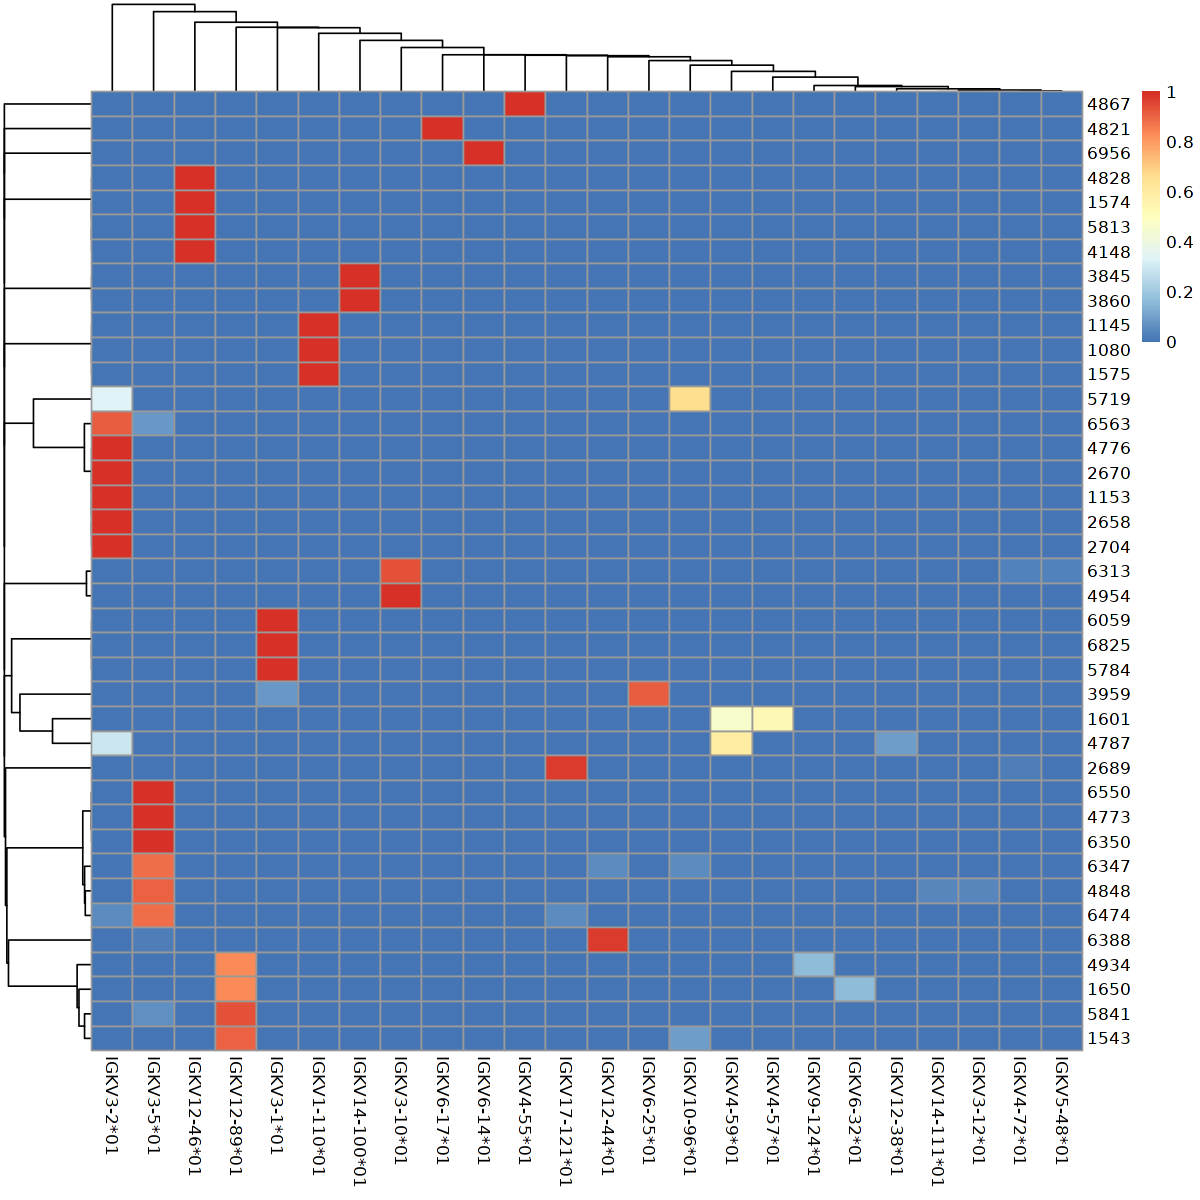

In [69]:
test = metadata %>% filter(Recovery==3) 
df = test %>% group_by(CLONE, IGL_V_CALL) %>% summarize(ncell.clone.igl=n()) %>% 
mutate(ncell.clone=sum(ncell.clone.igl)) %>% filter(ncell.clone>5) 

df2 = dcast(df,CLONE~IGL_V_CALL,value.var='ncell.clone.igl') %>% replace(is.na(.),0) 
rownames(df2) = df2$CLONE
mtx = df2 %>% select(-CLONE) %>% as.matrix()
mtx = mtx[order(rowSums(mtx),decreasing=TRUE),]
mtx2 = mtx/rowSums(mtx)
print(sprintf('clus.frac>=%.1f, conscount>=%d, ncell.per.clone>=%d',
              min(hc.match$R1_CLUSTER_FRACTION),min(hc.match$R1CONSCOUNT),min(df$ncell.clone)))
options(repr.plot.height=10, repr.plot.width=10)
pheatmap::pheatmap(mtx2, cluster_rows=T)

In [142]:
srat = readRDS('md39/seurat_objects/04_md39_singlet_bcells.RDS')
srat

An object of class Seurat 
16002 features across 38027 samples within 2 assays 
Active assay: RNA (15992 features, 2000 variable features)
 1 other assay present: HTO
 2 dimensional reductions calculated: pca, umap

In [158]:
clonal.df = read.table('md39/processed_repertoire_data/06_hc_private_clones_germ-pass.tab',
                stringsAsFactors = FALSE, header = TRUE, sep = '\t')
dim(clonal.df)

[1] 10936    96

In [144]:
metadata = srat@meta.data
metadata = merge(metadata, clonal.df[c('LANE_ID','VPRIMER','ISOTYPE','CDR3NUC','CDR3',
                                       'CLONE','MOUSE','GERMLINE_V_CALL')], 
                 by.x='id', by.y='LANE_ID', all.x=TRUE)
rownames(metadata)= metadata$id
dim(metadata)

[1] 38027    41

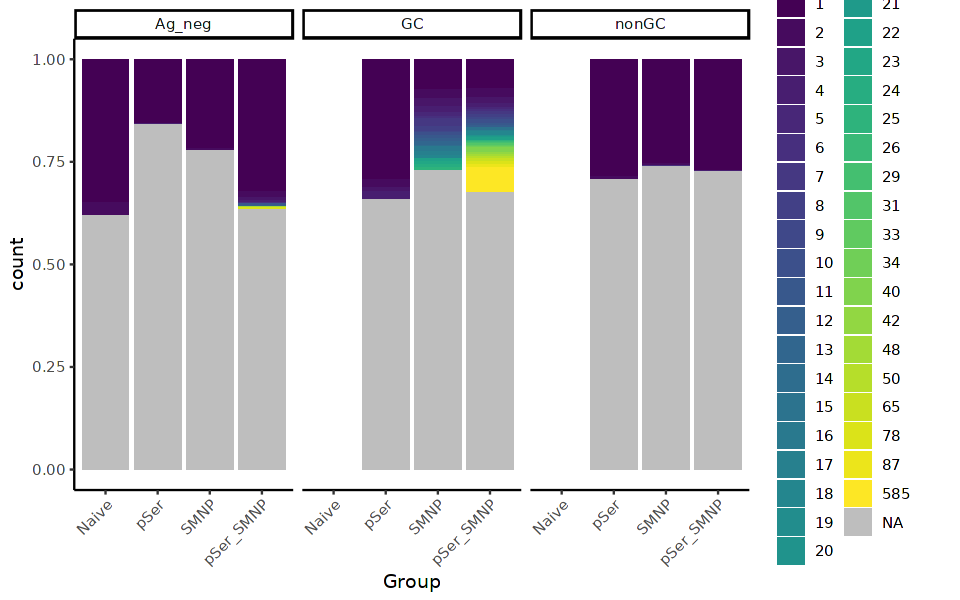

In [145]:
metadata$CLONE = as.character(clonal.df$CLONE[match(metadata$id, clonal.df$LANE_ID)])
tab = table(metadata$CLONE)
metadata$clonal.size = tab[metadata$CLONE]

ggplot(metadata, aes(x = Group, fill = factor(clonal.size))) + 
geom_bar(position = 'fill') + facet_wrap('Phenotype') + 
theme_classic()+
theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
scale_fill_viridis(discrete = TRUE, na.value='gray')


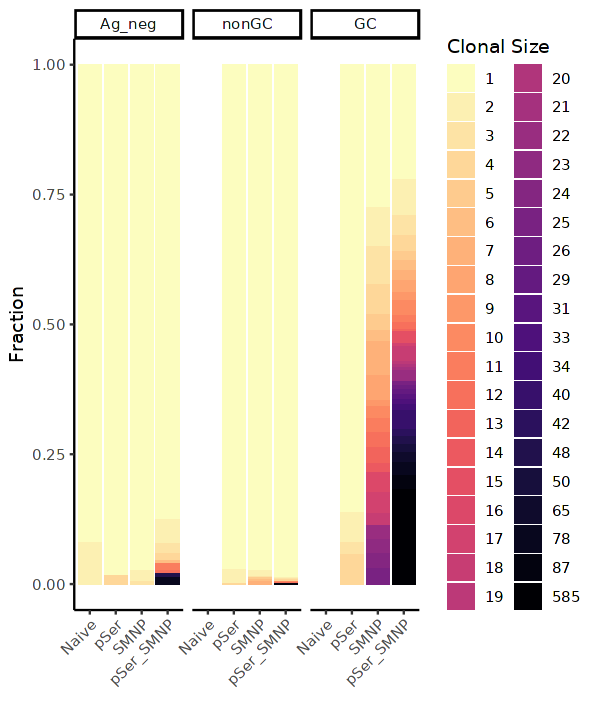

In [146]:
options(repr.plot.height=6, repr.plot.width=5)

metadata$CLONE = as.character(clonal.df$CLONE[match(metadata$id, clonal.df$LANE_ID)])
tab = table(metadata$CLONE)
metadata$clone_size = tab[metadata$CLONE]

metadata$Phenotype = factor(metadata$Phenotype, levels= c('Ag_neg','nonGC','GC'))

metadata %>% filter(!is.na(clone_size)) %>% 
ggplot(aes(x = Group, fill = factor(clone_size))) + 
geom_bar(position = 'fill') + facet_wrap('Phenotype') + 
theme_classic()+
labs(fill='Clonal Size',y='Fraction',x='')+
scale_fill_viridis(option='magma',discrete=TRUE,direction=-1)+
theme(axis.text.x = element_text(angle = 45, hjust = 1))


In [147]:
clonal.df$clone_size = tab[clonal.df$CLONE]

Warning message:
“Removed 27091 rows containing missing values (`geom_point()`).”


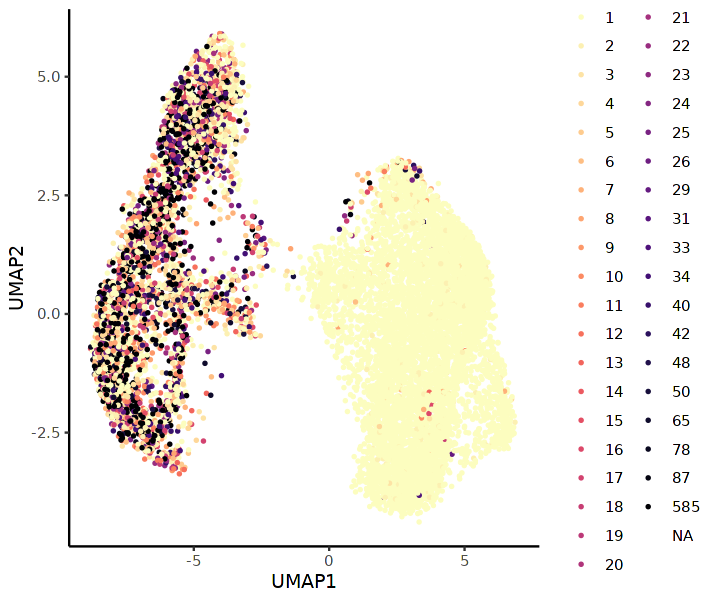

In [148]:
options(repr.plot.width=6, repr.plot.height=5)
metadata %>% 
ggplot(aes(x=UMAP1, y=UMAP2, color=as.factor(clone_size))) + geom_point(size=0.5) + 
theme_classic()+scale_color_viridis(discrete=TRUE,option='magma',direction=-1) + 
labs(color='Clonal Size')

In [149]:
clonal.df = read.table('md39/processed_repertoire_data/06_hc_public_clones_germ-pass.tab',
                stringsAsFactors = FALSE, header = TRUE, sep = '\t')
dim(clonal.df)

[1] 10936    96

In [150]:
metadata = srat@meta.data
metadata = merge(metadata, clonal.df[c('LANE_ID','VPRIMER','ISOTYPE','CDR3NUC','CDR3',
                                       'CLONE','MOUSE','GERMLINE_V_CALL')], 
                 by.x='id', by.y='LANE_ID', all.x=TRUE)
rownames(metadata)= metadata$id
dim(metadata)

[1] 38027    41

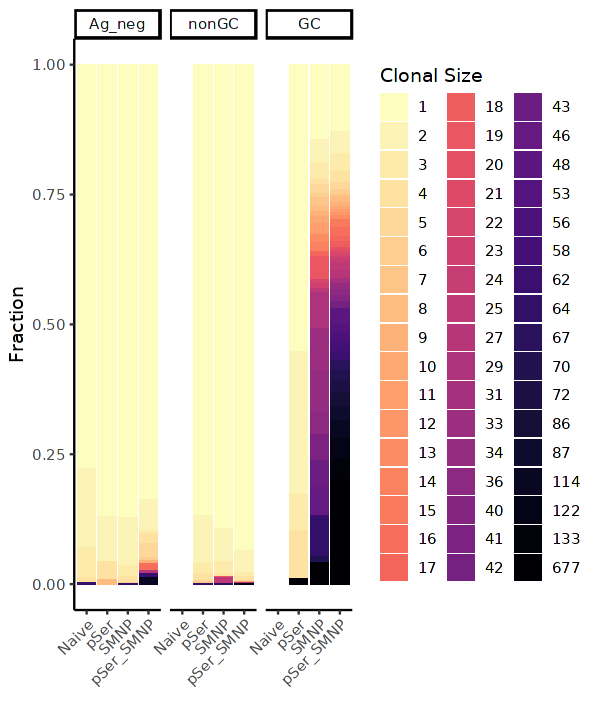

In [151]:
options(repr.plot.height=6, repr.plot.width=5)

metadata$CLONE = as.character(clonal.df$CLONE[match(metadata$id, clonal.df$LANE_ID)])
tab = table(metadata$CLONE)
metadata$clone_size = tab[metadata$CLONE]

metadata$Phenotype = factor(metadata$Phenotype, levels= c('Ag_neg','nonGC','GC'))

metadata %>% filter(!is.na(clone_size)) %>% 
ggplot(aes(x = Group, fill = factor(clone_size))) + 
geom_bar(position = 'fill') + facet_wrap('Phenotype') + 
theme_classic()+
labs(fill='Clonal Size',y='Fraction',x='')+
scale_fill_viridis(option='magma',discrete=TRUE,direction=-1)+
theme(axis.text.x = element_text(angle = 45, hjust = 1))


Warning message:
“Removed 27091 rows containing missing values (`geom_point()`).”


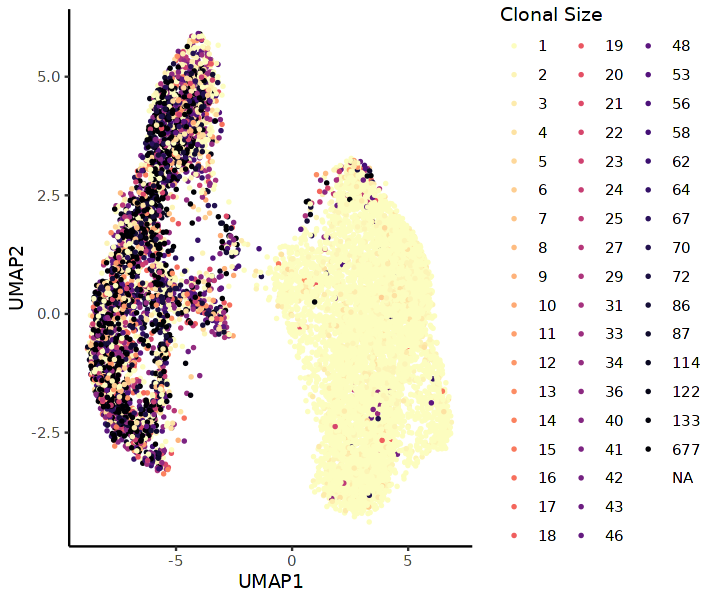

In [157]:
options(repr.plot.width=6, repr.plot.height=5)
metadata %>% 
ggplot(aes(x=UMAP1, y=UMAP2, color=as.factor(clone_size))) + geom_point(size=0.5) + 
theme_classic()+scale_color_viridis(discrete=TRUE,option='magma',direction=-1) + 
labs(color='Clonal Size')

In [149]:
clonal.df = read.table('md39/processed_repertoire_data/06_hc_private_clones_germ-pass.tab',
                stringsAsFactors = FALSE, header = TRUE, sep = '\t')
dim(clonal.df)

[1] 10936    96

In [173]:
gc = readRDS('md39/seurat_objects/06_md39_labeled_gc2.RDS')

In [174]:
metadata = gc@meta.data
metadata = merge(metadata, clonal.df[c('LANE_ID','VPRIMER','ISOTYPE','CDR3NUC','CDR3',
                                       'CLONE','MOUSE','GERMLINE_V_CALL')], 
                 by.x='id', by.y='LANE_ID', all.x=TRUE)
rownames(metadata)= metadata$id
dim(metadata)

[1] 11231    44

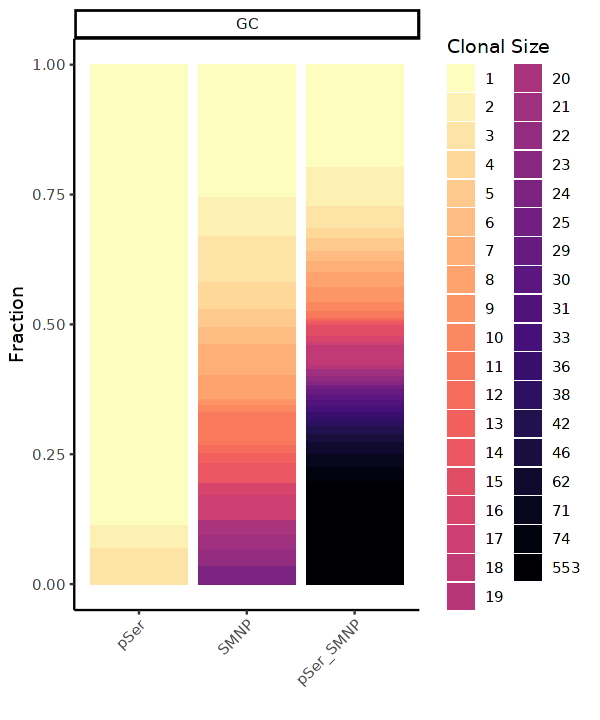

In [175]:
options(repr.plot.height=6, repr.plot.width=5)

metadata$CLONE = as.character(clonal.df$CLONE[match(metadata$id, clonal.df$LANE_ID)])
tab = table(metadata$CLONE)
metadata$clone_size = tab[metadata$CLONE]

#metadata$Phenotype = factor(metadata$Phenotype, levels= c('Ag_neg','nonGC','GC'))

metadata %>% filter(!is.na(clone_size)) %>% 
ggplot(aes(x = Group, fill = factor(clone_size))) + 
geom_bar(position = 'fill') + facet_wrap('Phenotype') + 
theme_classic()+
labs(fill='Clonal Size',y='Fraction',x='')+
scale_fill_viridis(option='magma',discrete=TRUE,direction=-1)+
theme(axis.text.x = element_text(angle = 45, hjust = 1))


Warning message:
“Removed 7681 rows containing missing values (`geom_point()`).”


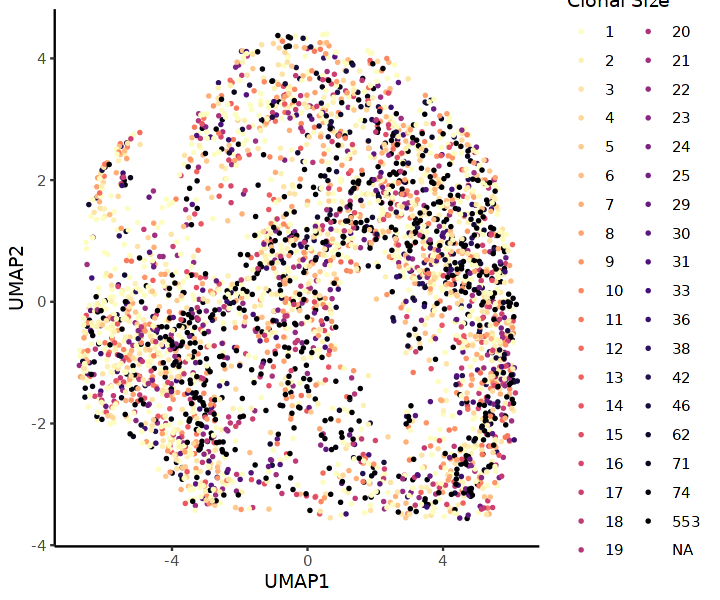

In [176]:
options(repr.plot.width=6, repr.plot.height=5)
metadata %>% 
ggplot(aes(x=UMAP1, y=UMAP2, color=as.factor(clone_size))) + geom_point(size=0.5) + 
theme_classic()+scale_color_viridis(discrete=TRUE,option='magma',direction=-1) + 
labs(color='Clonal Size')

In [ ]:
# look at the relationship between clonal size and cdr3 length

In [216]:
clonal.df$Group = metadata$Group[match(clonal.df$LANE_ID,metadata$id)]
clonal.df$Phenotype = metadata$Phenotype[match(clonal.df$LANE_ID,metadata$id)]

In [312]:
metadata = metadata %>% mutate(CDR3_LENGTH=nchar(CDR3)) 

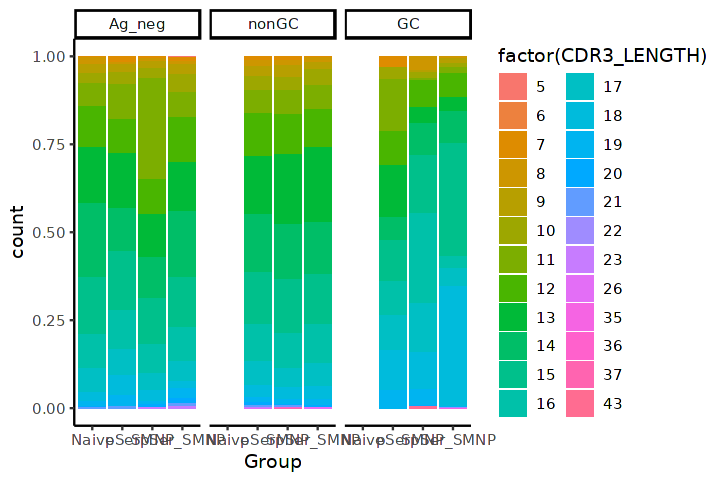

In [314]:
metadata %>% filter(CLONE>0) %>% 
ggplot(aes(x=Group,fill=factor(CDR3_LENGTH))) + 
geom_bar(position='fill') + theme_classic() + facet_wrap('Phenotype') 

## Diversity and richness

In [100]:
# install.packages('vegan') #shanon diversity

Installing package into ‘/home/jupyter/packages’
(as ‘lib’ is unspecified)

also installing the dependency ‘permute’




In [159]:
srat = readRDS('md39/seurat_objects/04_md39_singlet_bcells.RDS')
srat

An object of class Seurat 
16002 features across 38027 samples within 2 assays 
Active assay: RNA (15992 features, 2000 variable features)
 1 other assay present: HTO
 2 dimensional reductions calculated: pca, umap

In [168]:
srat = readRDS('md39/seurat_objects/06_md39_labeled_gc2.RDS')
srat

An object of class Seurat 
16002 features across 11231 samples within 2 assays 
Active assay: RNA (15992 features, 2000 variable features)
 1 other assay present: HTO
 2 dimensional reductions calculated: pca, umap

In [160]:
clonal.df = read.table('md39/processed_repertoire_data/06_hc_private_clones_germ-pass.tab',
                stringsAsFactors = FALSE, header = TRUE, sep = '\t')
dim(clonal.df)

[1] 10936    96

In [169]:
metadata = srat@meta.data
metadata = merge(metadata, clonal.df[c('LANE_ID','VPRIMER','ISOTYPE','CDR3NUC','CDR3',
                                       'CLONE','MOUSE','GERMLINE_V_CALL')], 
                 by.x='id', by.y='LANE_ID', all.x=TRUE)
rownames(metadata)= metadata$id
dim(metadata)

[1] 11231    44

`summarise()` has grouped output by 'Group', 'Phenotype', 'Mouse'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'Group', 'Phenotype'. You can override
using the `.groups` argument.


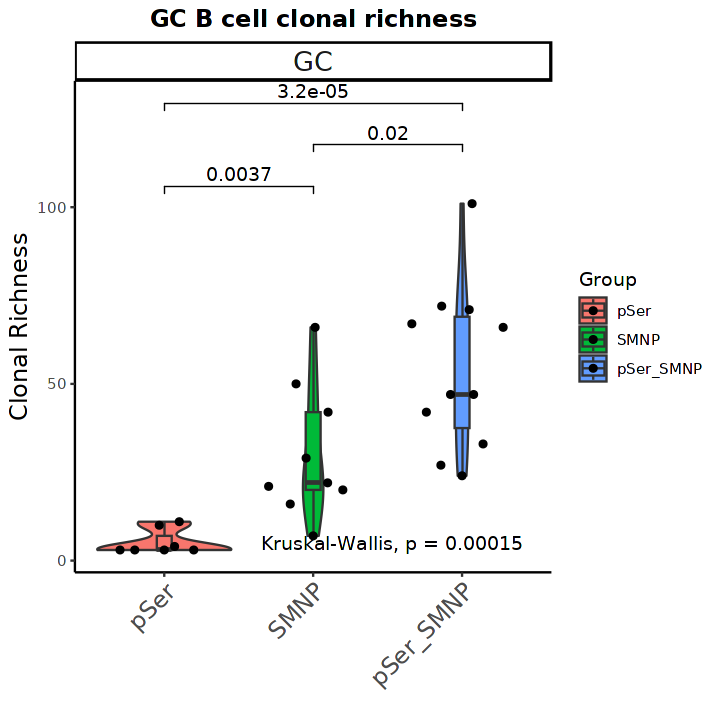

In [170]:
options(repr.plot.width=6, repr.plot.height=6)

df4gg = metadata %>% filter(!is.na(CLONE)) %>% 
group_by(Group, Phenotype, Mouse, CLONE) %>% summarize(ncell.clone = n()) %>% 
summarize(clonal_richness = n(),ncell.mouse = sum(ncell.clone))

df4gg=df4gg %>% filter(ncell.mouse > as.numeric(quantile(df4gg$ncell.mouse, probs = 0.05))) %>% 
filter(ncell.mouse < as.numeric(quantile(df4gg$ncell.mouse, probs = 0.95))) 

df4gg %>%filter(Phenotype=='GC')%>%
ggplot(aes(x=Group, y=clonal_richness, fill=Group)) + theme_classic()+
geom_violin()+ geom_boxplot(width=0.1) + geom_quasirandom() + 
facet_wrap('Phenotype') + 
stat_compare_means(method = "kruskal.test",label.y.npc='bottom',label.x.npc='middle') + 
stat_compare_means(method = "t.test",label = 'p.format',
                   tip.length = 0.02,comparisons = my_comparisons)+
labs(y='Clonal Richness', x='', title='GC B cell clonal richness') + 
theme(plot.title=element_text(size=14,hjust=0.5, face='bold'), 
      axis.text.x=element_text(size=14,angle=45,hjust=1),
      axis.title.y=element_text(size=14),strip.text=element_text(size=16)) 

`summarise()` has grouped output by 'Group', 'Phenotype', 'Mouse'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'Group', 'Phenotype'. You can override
using the `.groups` argument.


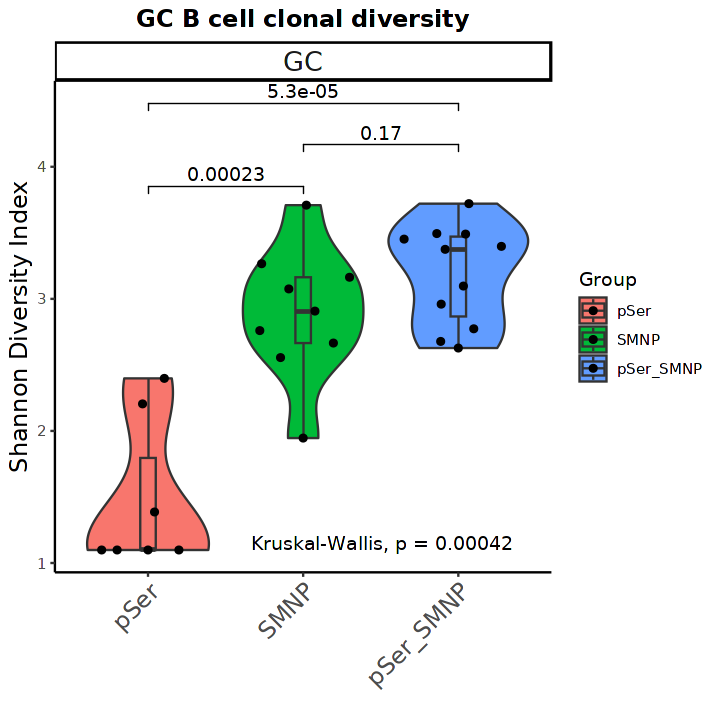

In [171]:
options(repr.plot.width=6, repr.plot.height=6)

df4gg = metadata %>% filter(!is.na(CLONE)) %>%
group_by(Group,Phenotype, Mouse, CLONE) %>% summarize(nclone.mouse = n()) %>% 
summarize(div = vegan::diversity(nclone.mouse), ncell.mouse = sum(nclone.mouse)) 

df4gg=df4gg %>% filter(ncell.mouse > as.numeric(quantile(df4gg$ncell.mouse, probs = 0.05))) %>% 
filter(ncell.mouse < as.numeric(quantile(df4gg$ncell.mouse, probs = 0.95))) 

my_comparisons = list( c("pSer", "SMNP"), c("SMNP", "pSer_SMNP"), c("pSer", "pSer_SMNP") )

df4gg %>%filter(Phenotype=='GC')%>%
ggplot(aes(x=Group, y=div, fill=Group)) + theme_classic()+
geom_violin()+ geom_boxplot(width=0.1) + geom_quasirandom() + 
facet_wrap('Phenotype') + 
stat_compare_means(method = "kruskal.test",label.y.npc='bottom',label.x.npc='middle') + 
stat_compare_means(method = "t.test",label = 'p.format',
                   tip.length = 0.02,comparisons = my_comparisons)+
labs(y='Shannon Diversity Index', x='', title='GC B cell clonal diversity') + 
theme(plot.title=element_text(size=14,hjust=0.5, face='bold'), 
      axis.text.x=element_text(size=14,angle=45,hjust=1),
      axis.title.y=element_text(size=14),strip.text=element_text(size=16)) 

`summarise()` has grouped output by 'Group', 'Phenotype', 'Mouse'. You can
override using the `.groups` argument.
Warning message:
“There was 1 warning in `summarize()`.
ℹ In argument: `div = vegan::diversity(nclone.mouse, base = n())`.
ℹ In group 10: `Group = SMNP`, `Phenotype = "GC"`, `Mouse = "AG_HTO2"`.
Caused by warning in `log()`:
! NaNs produced”
`summarise()` has grouped output by 'Group', 'Phenotype'. You can override
using the `.groups` argument.


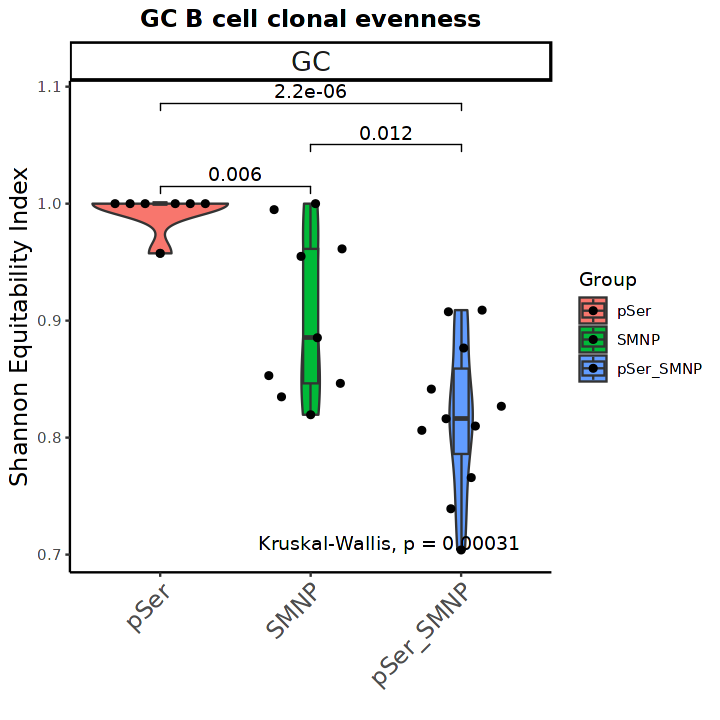

In [172]:
options(repr.plot.width=6, repr.plot.height=6)

df4gg = metadata %>% filter(!is.na(CLONE)) %>%
group_by(Group,Phenotype, Mouse, CLONE) %>% summarize(nclone.mouse = n()) %>% 
summarize(div = vegan::diversity(nclone.mouse, base=n()), ncell.mouse = sum(nclone.mouse)) 

df4gg=df4gg %>% filter(ncell.mouse > as.numeric(quantile(df4gg$ncell.mouse, probs = 0.05))) %>% 
filter(ncell.mouse < as.numeric(quantile(df4gg$ncell.mouse, probs = 0.95))) 

my_comparisons = list( c("pSer", "SMNP"), c("SMNP", "pSer_SMNP"), c("pSer", "pSer_SMNP") )

df4gg %>% filter(Phenotype=='GC')%>%
ggplot(aes(x=Group, y=div, fill=Group)) + theme_classic()+
geom_violin()+ geom_boxplot(width=0.1) + geom_quasirandom() + 
facet_wrap('Phenotype') + 
stat_compare_means(method = "kruskal.test",label.y.npc='bottom',label.x.npc='middle') + 
stat_compare_means(method = "t.test",label = 'p.format',
                   tip.length = 0.02,comparisons = my_comparisons)+
labs(y='Shannon Equitability Index', x='', title='GC B cell clonal evenness') + 
theme(plot.title=element_text(size=14,hjust=0.5, face='bold'), 
      axis.text.x=element_text(size=14,angle=45,hjust=1),
      axis.title.y=element_text(size=14),strip.text=element_text(size=16)) 

`summarise()` has grouped output by 'Group', 'Phenotype', 'Mouse'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'Group', 'Phenotype'. You can override
using the `.groups` argument.
Warning message in wilcox.test.default(c(1.09861228866811, 1.38629436111989, 1.09861228866811, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(1.09861228866811, 1.38629436111989, 1.09861228866811, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(2.20209030524857, 2.90420772200913, 1.66633258532833, :
“cannot compute exact p-value with ties”


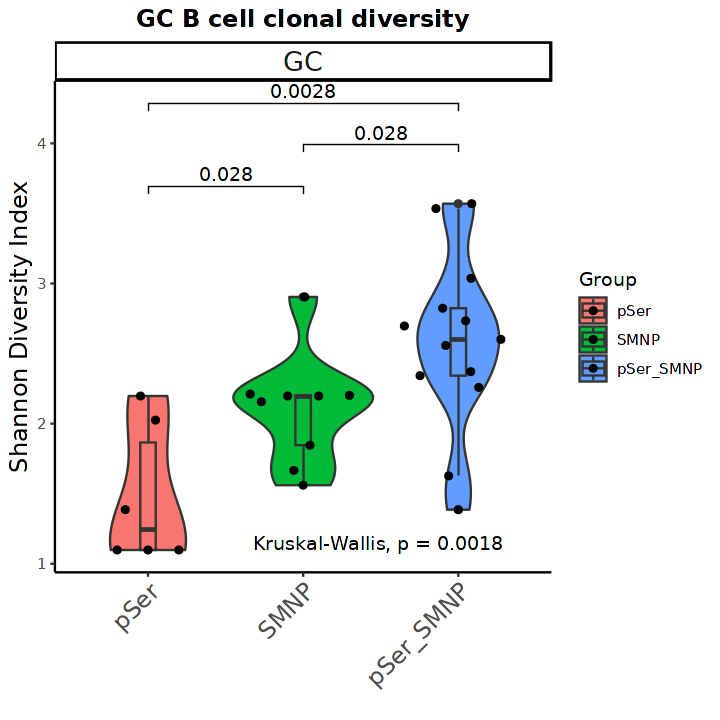

In [61]:
options(repr.plot.width=6, repr.plot.height=6)

df4gg = metadata %>% filter(!is.na(CLONE)) %>%
group_by(Group,Phenotype, Mouse, CLONE) %>% summarize(nclone.mouse = n()) %>% 
summarize(div = vegan::diversity(nclone.mouse), ncell.mouse = sum(nclone.mouse)) 

df4gg=df4gg %>% filter(ncell.mouse > as.numeric(quantile(df4gg$ncell.mouse, probs = 0.05))) %>% 
filter(ncell.mouse < as.numeric(quantile(df4gg$ncell.mouse, probs = 0.95))) 

my_comparisons = list( c("pSer", "SMNP"), c("SMNP", "pSer_SMNP"), c("pSer", "pSer_SMNP") )

df4gg %>%filter(Phenotype=='GC')%>%
ggplot(aes(x=Group, y=div, fill=Group)) + theme_classic()+
geom_violin()+ geom_boxplot(width=0.1) + geom_quasirandom() + 
facet_wrap('Phenotype') + 
stat_compare_means(method = "kruskal.test",label.y.npc='bottom',label.x.npc='middle') + 
stat_compare_means(method = "wilcox.test",label = 'p.format',
                   tip.length = 0.02,comparisons = my_comparisons)+
labs(y='Shannon Diversity Index', x='', title='GC B cell clonal diversity') + 
theme(plot.title=element_text(size=14,hjust=0.5, face='bold'), 
      axis.text.x=element_text(size=14,angle=45,hjust=1),
      axis.title.y=element_text(size=14),strip.text=element_text(size=16)) 

`summarise()` has grouped output by 'Group', 'Phenotype', 'Mouse'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'Group', 'Phenotype'. You can override
using the `.groups` argument.
Warning message in wilcox.test.default(c(3, 4, 3, 8, 3, 9), c(14, 22, 7, 14, 9, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(3, 4, 3, 8, 3, 9), c(36, 4, 79, 89, 22, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(14, 22, 7, 14, 9, 14, 5, 7, 9), c(36, 4, :
“cannot compute exact p-value with ties”


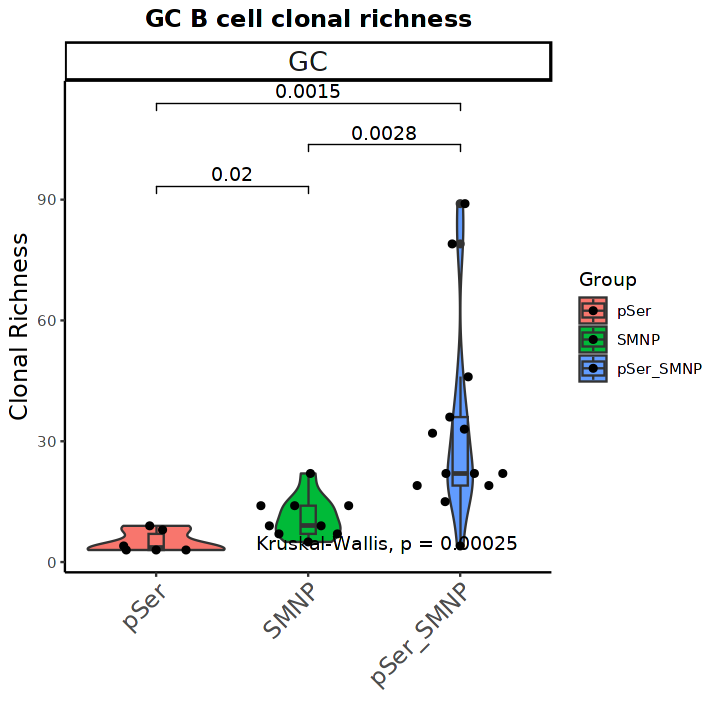

In [62]:
options(repr.plot.width=6, repr.plot.height=6)

df4gg = metadata %>% filter(!is.na(CLONE)) %>% 
group_by(Group, Phenotype, Mouse, CLONE) %>% summarize(ncell.clone = n()) %>% 
summarize(clonal_richness = n(),ncell.mouse = sum(ncell.clone))

df4gg=df4gg %>% filter(ncell.mouse > as.numeric(quantile(df4gg$ncell.mouse, probs = 0.05))) %>% 
filter(ncell.mouse < as.numeric(quantile(df4gg$ncell.mouse, probs = 0.95))) 

df4gg %>%filter(Phenotype=='GC')%>%
ggplot(aes(x=Group, y=clonal_richness, fill=Group)) + theme_classic()+
geom_violin()+ geom_boxplot(width=0.1) + geom_quasirandom() + 
facet_wrap('Phenotype') + 
stat_compare_means(method = "kruskal.test",label.y.npc='bottom',label.x.npc='middle') + 
stat_compare_means(method = "wilcox.test",label = 'p.format',
                   tip.length = 0.02,comparisons = my_comparisons)+
labs(y='Clonal Richness', x='', title='GC B cell clonal richness') + 
theme(plot.title=element_text(size=14,hjust=0.5, face='bold'), 
      axis.text.x=element_text(size=14,angle=45,hjust=1),
      axis.title.y=element_text(size=14),strip.text=element_text(size=16)) 

`summarise()` has grouped output by 'Group', 'Phenotype', 'Mouse'. You can
override using the `.groups` argument.
Warning message:
“There were 4 warnings in `summarize()`.
The first warning was:
ℹ In argument: `div = vegan::diversity(nclone.mouse, base = n())`.
ℹ In group 12: `Group = pSer`, `Phenotype = Ag_neg`, `Mouse = "AQ_HTO3"`.
Caused by warning in `log()`:
! NaNs produced
ℹ Run `dplyr::last_dplyr_warnings()` to see the 3 remaining warnings.”
`summarise()` has grouped output by 'Group', 'Phenotype'. You can override
using the `.groups` argument.
Warning message in wilcox.test.default(c(1, 1, 1, 0.973976031629121, 1, 1), c(0.834423064833384, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(1, 1, 1, 0.973976031629121, 1, 1), c(0.630280697967358, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.834423064833384, 0.939556077223658, 0.856325553436927, :
“cannot compute exact p-value with ties”


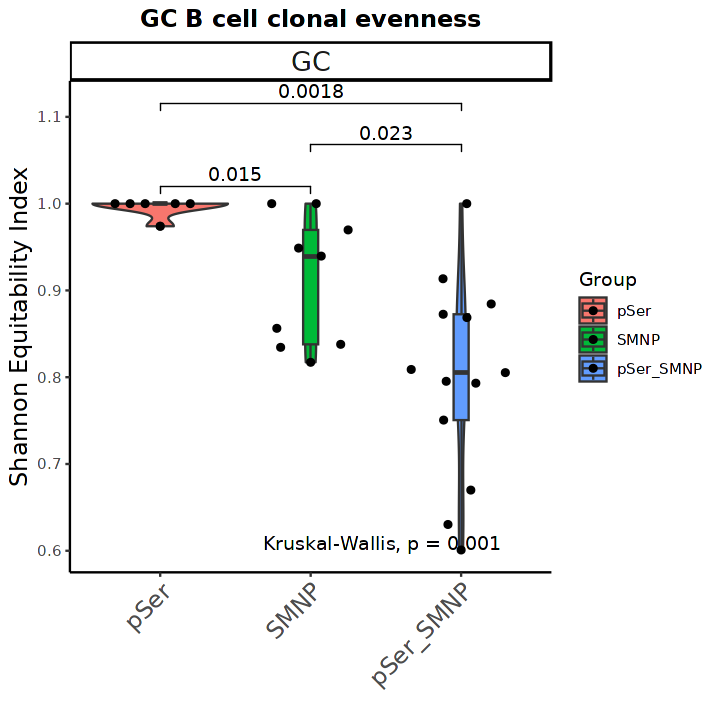

In [63]:
options(repr.plot.width=6, repr.plot.height=6)

df4gg = metadata %>% filter(!is.na(CLONE)) %>%
group_by(Group,Phenotype, Mouse, CLONE) %>% summarize(nclone.mouse = n()) %>% 
summarize(div = vegan::diversity(nclone.mouse, base=n()), ncell.mouse = sum(nclone.mouse)) 

df4gg=df4gg %>% filter(ncell.mouse > as.numeric(quantile(df4gg$ncell.mouse, probs = 0.05))) %>% 
filter(ncell.mouse < as.numeric(quantile(df4gg$ncell.mouse, probs = 0.95))) 

my_comparisons = list( c("pSer", "SMNP"), c("SMNP", "pSer_SMNP"), c("pSer", "pSer_SMNP") )

df4gg %>% filter(Phenotype=='GC')%>%
ggplot(aes(x=Group, y=div, fill=Group)) + theme_classic()+
geom_violin()+ geom_boxplot(width=0.1) + geom_quasirandom() + 
facet_wrap('Phenotype') + 
stat_compare_means(method = "kruskal.test",label.y.npc='bottom',label.x.npc='middle') + 
stat_compare_means(method = "wilcox.test",label = 'p.format',
                   tip.length = 0.02,comparisons = my_comparisons)+
labs(y='Shannon Equitability Index', x='', title='GC B cell clonal evenness') + 
theme(plot.title=element_text(size=14,hjust=0.5, face='bold'), 
      axis.text.x=element_text(size=14,angle=45,hjust=1),
      axis.title.y=element_text(size=14),strip.text=element_text(size=16)) 

## public clones

In [7]:
srat = readRDS('md39/seurat_objects/04_md39_singlet_bcells.RDS')
srat

An object of class Seurat 
16002 features across 38027 samples within 2 assays 
Active assay: RNA (15992 features, 2000 variable features)
 1 other assay present: HTO
 2 dimensional reductions calculated: pca, umap

In [64]:
clonal.df = read.table('md39/processed_repertoire_data/06_hc_public_clones_germ-pass.tab',
                stringsAsFactors = FALSE, header = TRUE, sep = '\t')
dim(clonal.df)

[1] 8342   96

In [65]:
metadata = srat@meta.data
metadata = merge(metadata, clonal.df[c('LANE_ID','VPRIMER','ISOTYPE','CDR3NUC','CDR3',
                                       'CLONE','MOUSE','GERMLINE_V_CALL')], 
                 by.x='id', by.y='LANE_ID', all.x=TRUE)
rownames(metadata)= metadata$id
dim(metadata)

[1] 38027    41

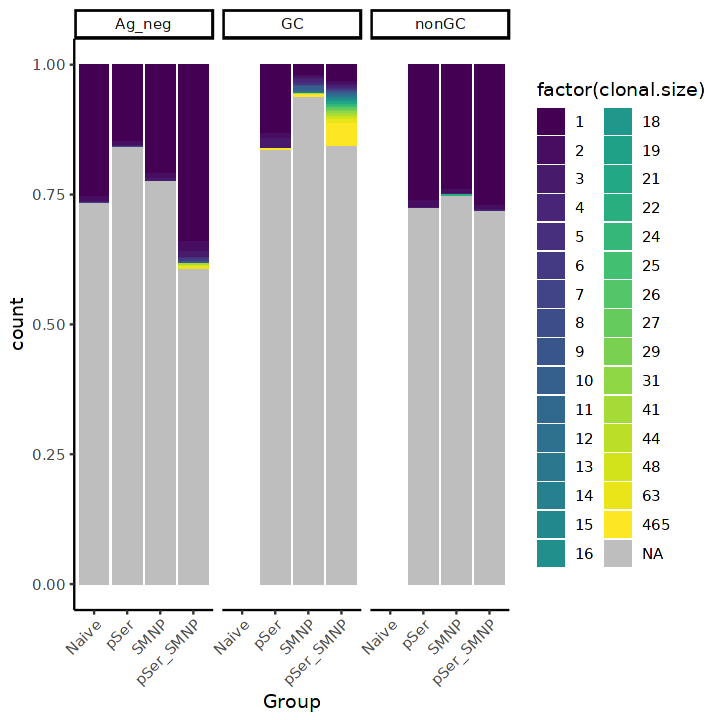

In [66]:
metadata$CLONE = as.character(clonal.df$CLONE[match(metadata$id, clonal.df$LANE_ID)])
tab = table(metadata$CLONE)
metadata$clonal.size = tab[metadata$CLONE]

ggplot(metadata, aes(x = Group, fill = factor(clonal.size))) + 
geom_bar(position = 'fill') + facet_wrap('Phenotype') + 
theme_classic()+
theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
scale_fill_viridis(discrete = TRUE, na.value='gray')


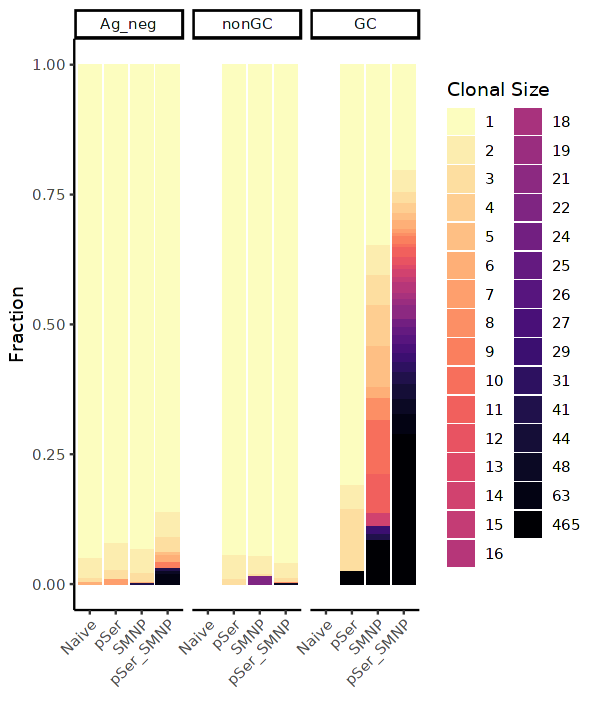

In [67]:
options(repr.plot.height=6, repr.plot.width=5)

metadata$CLONE = as.character(clonal.df$CLONE[match(metadata$id, clonal.df$LANE_ID)])
tab = table(metadata$CLONE)
metadata$clone_size = tab[metadata$CLONE]

metadata$Phenotype = factor(metadata$Phenotype, levels= c('Ag_neg','nonGC','GC'))

metadata %>% filter(!is.na(clone_size)) %>% 
ggplot(aes(x = Group, fill = factor(clone_size))) + 
geom_bar(position = 'fill') + facet_wrap('Phenotype') + 
theme_classic()+
labs(fill='Clonal Size',y='Fraction',x='')+
scale_fill_viridis(option='magma',discrete=TRUE,direction=-1)+
theme(axis.text.x = element_text(angle = 45, hjust = 1))


In [68]:
clonal.df$clone_size = tab[clonal.df$CLONE]

Warning message:
“Removed 29685 rows containing missing values (`geom_point()`).”


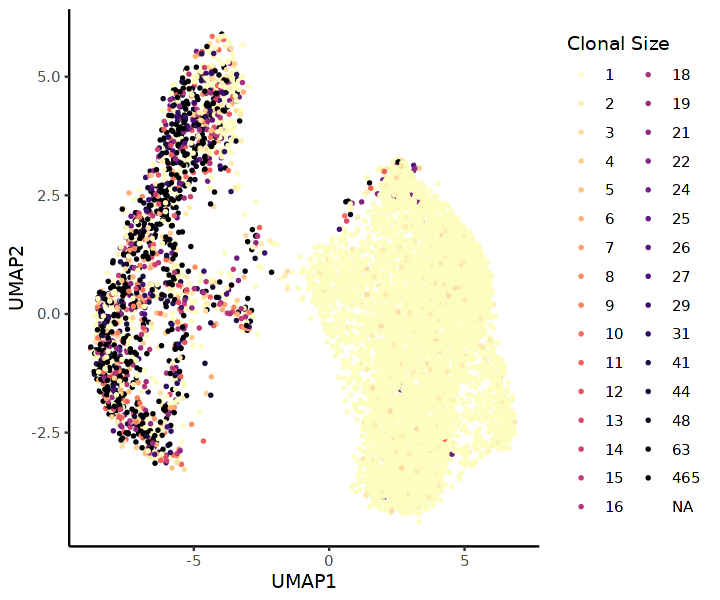

In [69]:
options(repr.plot.width=6, repr.plot.height=5)
metadata %>% 
ggplot(aes(x=UMAP1, y=UMAP2, color=as.factor(clone_size))) + geom_point(size=0.5) + 
theme_classic()+scale_color_viridis(discrete=TRUE,option='magma',direction=-1) + 
labs(color='Clonal Size')

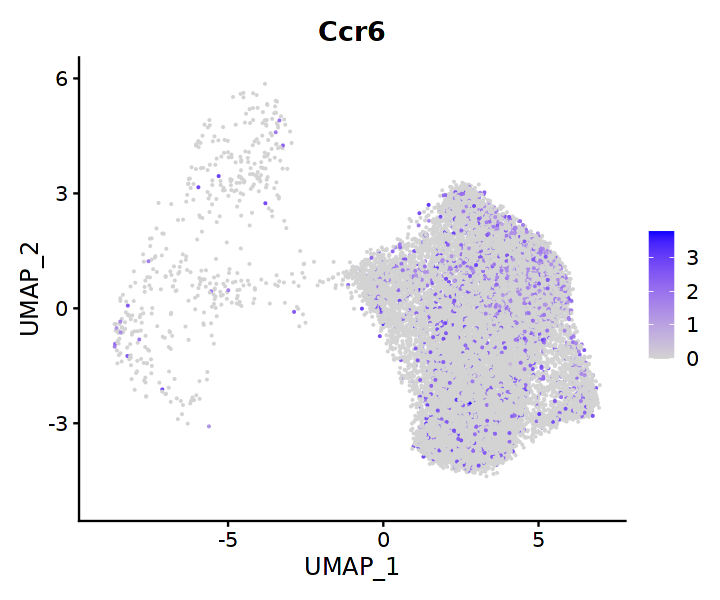

In [18]:
nongc = subset(srat,Phenotype=='nonGC')
FeaturePlot(nongc,'Ccr6')

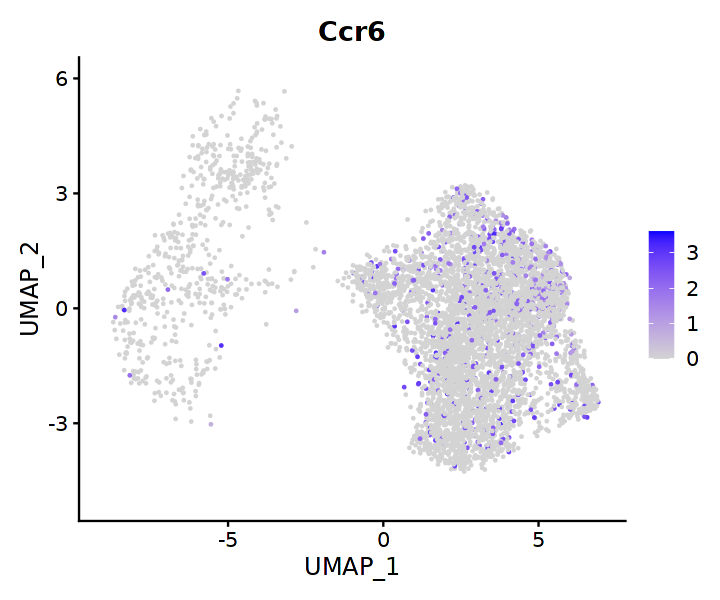

In [19]:
nongc = subset(srat,Phenotype=='Ag_neg')
FeaturePlot(nongc,'Ccr6')

## prep data

In [78]:
fil.data = readRDS('md39/processed_repertoire_data/01_md39_ppfilter_HC_LC.RDS')
dim(fil.data)

[1] 232842     71

In [79]:
min(fil.data$R2CONSCOUNT)
min(fil.data$R2_CLUSTER_FRACTION)

[1] 6

[1] 0.5001383

In [80]:
srat = readRDS('md39/seurat_objects/04_md39_singlet_bcells.RDS')
srat

An object of class Seurat 
16002 features across 38027 samples within 2 assays 
Active assay: RNA (15992 features, 2000 variable features)
 1 other assay present: HTO
 2 dimensional reductions calculated: pca, umap

In [81]:
matched = fil.data %>% filter(LANE_ID %in% srat$id)
hc.match = matched %>% filter(LOCUS=='IGH') 
lc.match = matched %>% filter(LOCUS!='IGH') 
dim(hc.match)
dim(lc.match)


[1] 18043    71

[1] 40359    71

## collapse for each cell

In [82]:
# collapse seq for each cell by highest count  
cell_consensus_hc_bycount = hc.match %>% group_by(LANE_ID) %>% arrange(desc(R1CONSCOUNT+R2CONSCOUNT)) %>% 
                    slice(1) %>% mutate(CONSENSUS_SEQUENCE=SEQUENCE_IMGT)
cell_consensus_lc_bycount = lc.match %>% group_by(LANE_ID) %>% arrange(desc(R1CONSCOUNT+R2CONSCOUNT)) %>% 
                    slice(1) %>% mutate(CONSENSUS_SEQUENCE=SEQUENCE_IMGT)

dim(cell_consensus_hc_bycount)
dim(cell_consensus_lc_bycount)

[1] 9275   72

[1] 17592    72

In [83]:
# collapse seq for each cell by building consensus 
cell_consensus_hc = read.table('md39/processed_repertoire_data/03_hc_consensus.tab', 
                               stringsAsFactors = FALSE, sep = '\t', header = TRUE) %>% 
group_by(LANE_ID, Sample, BC) %>% filter(ERRORDIST < 10) %>% 
mutate(IgM = sum(ISOTYPE == 'IGHM'), IgD = sum(ISOTYPE %in% c('IGHD1','IGHD2')), 
       IgG = sum(ISOTYPE %in% c('IGHG1','IGHG2','IGHG3')), IgA = sum(ISOTYPE == 'IGHA') ) %>%
arrange(ERRORDIST, desc(R2CONSCOUNT)) %>% slice(1)

cell_consensus_hc[,c('FWR1nuc', 'CDR1nuc', 'FWR2nuc', 'CDR2nuc', 'FWR3nuc')]= extractVRegion(cell_consensus_hc$CONSENSUS_SEQUENCE, region = c('fwr1', 'cdr1', 'fwr2', 'cdr2', 'fwr3')) %>% as.data.frame()
cell_consensus_hc$JUNCTION_START = NA
cell_consensus_hc$CDR3nuc = NA

cell_consensus_hc = cell_consensus_hc %>% filter(FWR3nuc != '')
dim(cell_consensus_hc)

for (i in 1:nrow(cell_consensus_hc)) {
    
    # The JUNCTION column includes one codon from FWR3 and FWR4, hence subtract 3 to match with JUNCTION column
    cell_consensus_hc$JUNCTION_START[i] = as.numeric(gregexpr(cell_consensus_hc$CONSENSUS_SEQUENCE[i], pattern = cell_consensus_hc$FWR3nuc[i])) + str_length(cell_consensus_hc$FWR3nuc[i])-3 
    # CDR3nuc is different from CDR3_IMGT in that this is the equivalent JUNCTION column based on CONSENSUS_SEQUENCE
    cell_consensus_hc$CDR3nuc[i] = substring(cell_consensus_hc$CONSENSUS_SEQUENCE[i], cell_consensus_hc$JUNCTION_START[i], cell_consensus_hc$JUNCTION_START[i] + str_length(cell_consensus_hc$JUNCTION[i]) -1)
}

[1] 8860   86

In [84]:
cell_consensus_lc = read.table('md39/processed_repertoire_data/03_lc_consensus.tab', stringsAsFactors = FALSE, sep = '\t', header = TRUE) %>% 
group_by(LANE_ID, Sample, BC) %>% filter(ERRORDIST < 10) %>% 
mutate(IgK = sum(ISOTYPE == 'IGKC'), IgL = sum(ISOTYPE == 'IGLC')) %>%
arrange(ERRORDIST, desc(R2CONSCOUNT)) %>% slice(1) 

cell_consensus_lc[,c('FWR1nuc', 'CDR1nuc', 'FWR2nuc', 'CDR2nuc', 'FWR3nuc')]= extractVRegion(cell_consensus_lc$CONSENSUS_SEQUENCE, region = c('fwr1', 'cdr1', 'fwr2', 'cdr2', 'fwr3')) %>% as.data.frame()
cell_consensus_lc$JUNCTION_START = NA
cell_consensus_lc$CDR3nuc = NA

cell_consensus_lc = cell_consensus_lc %>% filter(FWR3nuc != '')
dim(cell_consensus_lc)

for (i in 1:nrow(cell_consensus_lc)) {
    if (lengths(gregexpr(cell_consensus_lc$CONSENSUS_SEQUENCE[i], pattern = cell_consensus_lc$FWR3nuc[i]))>1) {
        next
    }
    cell_consensus_lc$JUNCTION_START[i] = as.numeric(gregexpr(cell_consensus_lc$CONSENSUS_SEQUENCE[i], pattern = cell_consensus_lc$FWR3nuc[i])) + str_length(cell_consensus_lc$FWR3nuc[i])-3
    cell_consensus_lc$CDR3nuc[i] = substring(cell_consensus_lc$CONSENSUS_SEQUENCE[i], cell_consensus_lc$JUNCTION_START[i], cell_consensus_lc$JUNCTION_START[i] + str_length(cell_consensus_lc$JUNCTION[i]) -1)
}

[1] 15471    84

## Read in files

In [55]:
hc = read.table('md39/raw_repertoire_data/05_md39_hc_fastq_combined_results_230628.tab', 
                sep='\t',header=TRUE, stringsAsFactors=F)
table(hc$SAMPLE)


 AG16   AG2   AG3   AQ1   AQ2   AQ3   AQ4 
16479  6065 36744 29307  8512 24010 16118 

In [56]:
# add a column to match hc1
hc$Sample = hc$SAMPLE

# separate AG1 and AG2 
ag1 = hc %>% filter(Sample =='AG2')
ag1$Sample = 'AG1'

hc = rbind(hc,ag1)

table(hc$Sample)


  AG1  AG16   AG2   AG3   AQ1   AQ2   AQ3   AQ4 
 6065 16479  6065 36744 29307  8512 24010 16118 

In [21]:
lc = read.table('md39/raw_repertoire_data/md39_LC_combined_results.tab', 
                sep='\t',header=TRUE, stringsAsFactors=F)
table(lc$Sample)


   AG1   AG10   AG11   AG12   AG13   AG14   AG15   AG16    AG2    AG3    AG4 
 94140  94136 113061  98039  80869  49056 133397  57638   8547  63198  60968 
   AG5    AG6    AG7    AG8    AG9    AQ1   AQ10    AQ2    AQ3    AQ4    AQ5 
 56288  61059  44212  54073  82314  92649  92653  25643 143130 103306  63866 
   AQ6    AQ7    AQ8    AQ9 
 68136  55997   1324 122069 

In [47]:
# made modification to bcrprocess pipeline so need to adjust the columns between hc and lc 
lc = lc %>% select(-c(R1SEQCOUNT,R2SEQCOUNT))
hc = hc %>% select(-c(SAMPLE))

In [48]:
dim(lc)
dim(hc)

[1] 588251     65

[1] 105191     65

In [49]:
lc = lc %>% filter(Sample %in% hc$Sample)
data = rbind(hc,lc)
dim(data)

[1] 693442     65

In [50]:
data$BC = substr(data$SEQUENCE_ID,0,12)
data$UMI = substr(data$SEQUENCE_ID,13,20)
data$LANE_ID = paste(data$Sample, data$BC, sep='_')

In [51]:
data = data %>% filter(R2CONSCOUNT>1,R1CONSCOUNT>1)
data = jz.trim.masked.primer(data)
table(data$Sample)


  AG1  AG16   AG2   AG3   AQ1   AQ2   AQ3   AQ4 
27056 21791  6186 45305 35618  9831 45722 34504 

In [27]:
saveRDS(data,'md39/processed_repertoire_data/00.5_md39_HC_LC_combined_230628.RDS')

In [34]:
data = readRDS('md39/processed_repertoire_data/00.5_md39_HC_LC_combined_230628.RDS')

## Preprocess

In [8]:
data = readRDS('md39/processed_repertoire_data/00_md39_HC_LC_combined.RDS')
dim(data)

[1] 913641     71

In [36]:
gc = readRDS('md39/seurat_objects/06_md39_labeled_gc2.RDS')
gc

An object of class Seurat 
16002 features across 11231 samples within 2 assays 
Active assay: RNA (15992 features, 2000 variable features)
 1 other assay present: HTO
 2 dimensional reductions calculated: pca, umap

In [52]:
# filter raw seq data 
count.cutoff = 10 ## Change 
clus.frac.cutoff = 0.5 ## Change 
fil.data = data %>% filter(FUNCTIONAL==TRUE, N_count<5, 
                           R2CONSCOUNT>=count.cutoff,R1CONSCOUNT>=count.cutoff,
                           R1_CLUSTER_FRACTION>clus.frac.cutoff, R2_CLUSTER_FRACTION>clus.frac.cutoff) 
dim(fil.data)

[1] 58299    71

In [53]:
metadata = gc@meta.data ## Change
metadata$id = paste(metadata$orig, metadata$bc, sep='_')
matched = fil.data %>% filter(LANE_ID %in% metadata$id)
dim(matched)

hc.match = matched %>% filter(LOCUS=='IGH') 
lc.match = matched %>% filter(LOCUS!='IGH') 

[1] 16688    71

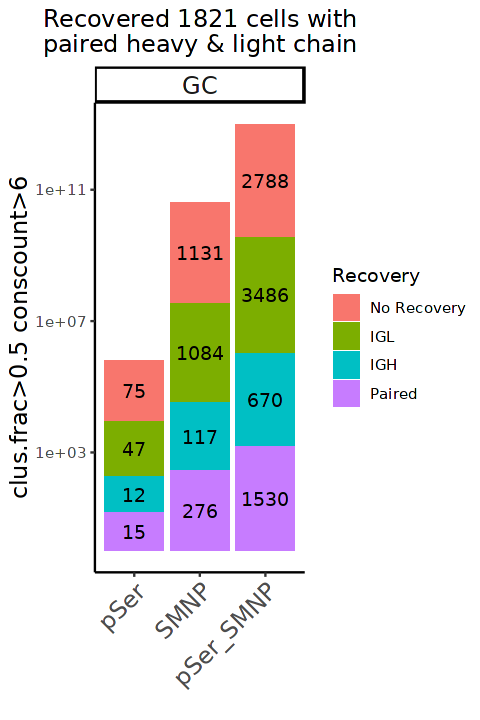

In [20]:
options(repr.plot.width=4,repr.plot.height=6)

metadata$IGH_recovery = as.numeric(metadata$id %in% hc.match$LANE_ID) * 2
metadata$IGL_recovery = as.numeric(metadata$id %in% lc.match$LANE_ID)
metadata = metadata %>% mutate(recovery = IGL_recovery+IGH_recovery) %>% filter(Phenotype=='GC') 

metadata %>% 
ggplot(aes(x = Group, fill = factor(recovery))) + theme_classic()+ 
geom_bar(position = 'stack') + 
geom_text(stat='count', aes(label=after_stat(count)),position = position_stack(vjust = 0.5))+
scale_y_log10()+
facet_wrap('Phenotype')+
labs(x = '', fill='Recovery',
     y=sprintf('clus.frac>%.1f conscount>%d',min(hc.match$R1_CLUSTER_FRACTION),min(hc.match$R1CONSCOUNT)), 
     title=sprintf('Recovered %d cells with\npaired heavy & light chain',sum(metadata$recovery==3))) + 
scale_fill_discrete(labels=c('No Recovery', 'IGL', 'IGH', 'Paired')) +
theme(plot.title=element_text(size=14, hjust=0.5), 
      axis.text.x=element_text(angle=45, size=14,hjust=1),
      axis.title.y=element_text(size=14), 
      strip.text=element_text(size=14, hjust=0.5))

In [13]:
# collapse seq for each cell 
cell_consensus_hc = hc.match %>% group_by(LANE_ID) %>% arrange(desc(R1CONSCOUNT+R2CONSCOUNT)) %>% 
                    slice(1) %>% mutate(CONSENSUS_SEQUENCE=SEQUENCE_IMGT)
cell_consensus_lc = lc.match %>% group_by(LANE_ID) %>% arrange(desc(R1CONSCOUNT+R2CONSCOUNT)) %>% 
                    slice(1) %>% mutate(CONSENSUS_SEQUENCE=SEQUENCE_IMGT)

dim(cell_consensus_hc)
dim(cell_consensus_lc)

[1] 2653   72

[1] 6443   72

In [14]:
library(alakazam)
library(stringr)
cell_consensus_hc[,c('FWR1nuc', 'CDR1nuc', 'FWR2nuc', 'CDR2nuc', 'FWR3nuc')]= extractVRegion(cell_consensus_hc$CONSENSUS_SEQUENCE, region = c('fwr1', 'cdr1', 'fwr2', 'cdr2', 'fwr3')) %>% as.data.frame()
cell_consensus_hc$JUNCTION_START = NA
cell_consensus_hc$CDR3nuc = NA
dim(cell_consensus_hc)

cell_consensus_hc = cell_consensus_hc %>% filter(FWR3nuc != '')
dim(cell_consensus_hc)
for (i in 1:nrow(cell_consensus_hc)) {
    
    # The JUNCTION column includes one codon from FWR3 and FWR4, hence subtract 3 to match with JUNCTION column
    cell_consensus_hc$JUNCTION_START[i] = as.numeric(gregexpr(cell_consensus_hc$CONSENSUS_SEQUENCE[i], pattern = cell_consensus_hc$FWR3nuc[i])) + str_length(cell_consensus_hc$FWR3nuc[i])-3 
    # CDR3nuc is different from CDR3_IMGT in that this is the equivalent JUNCTION column based on CONSENSUS_SEQUENCE
    cell_consensus_hc$CDR3nuc[i] = substring(cell_consensus_hc$CONSENSUS_SEQUENCE[i], cell_consensus_hc$JUNCTION_START[i], cell_consensus_hc$JUNCTION_START[i] + str_length(cell_consensus_hc$JUNCTION[i]) -1)
}

[1] 2653   79

[1] 2645   79

In [15]:
cell_consensus_lc[,c('FWR1nuc', 'CDR1nuc', 'FWR2nuc', 'CDR2nuc', 'FWR3nuc')]= extractVRegion(cell_consensus_lc$CONSENSUS_SEQUENCE, region = c('fwr1', 'cdr1', 'fwr2', 'cdr2', 'fwr3')) %>% as.data.frame()
cell_consensus_lc$JUNCTION_START = NA
cell_consensus_lc$CDR3nuc = NA
dim(cell_consensus_lc)

cell_consensus_lc = cell_consensus_lc %>% filter(FWR3nuc != '')
dim(cell_consensus_lc)

for (i in 1:nrow(cell_consensus_lc)) {
    if (lengths(gregexpr(cell_consensus_lc$CONSENSUS_SEQUENCE[i], pattern = cell_consensus_lc$FWR3nuc[i]))>1) {
        next
    }
    cell_consensus_lc$JUNCTION_START[i] = as.numeric(gregexpr(cell_consensus_lc$CONSENSUS_SEQUENCE[i], pattern = cell_consensus_lc$FWR3nuc[i])) + str_length(cell_consensus_lc$FWR3nuc[i])-3
    cell_consensus_lc$CDR3nuc[i] = substring(cell_consensus_lc$CONSENSUS_SEQUENCE[i], cell_consensus_lc$JUNCTION_START[i], cell_consensus_lc$JUNCTION_START[i] + str_length(cell_consensus_lc$JUNCTION[i]) -1)
}

[1] 6443   79

[1] 6438   79

In [16]:
metadata$MOUSE = paste(metadata$Batch,metadata$Group,metadata$hash.ID,sep='_')
cell_consensus_hc$MOUSE = metadata$MOUSE[match(cell_consensus_hc$LANE_ID, metadata$id)]
cell_consensus_hc$Group = metadata$Group[match(cell_consensus_hc$LANE_ID, metadata$id)]
cell_consensus_hc = cell_consensus_hc %>% mutate(JUNCTION = CDR3nuc, JUNCTION_LENGTH = str_length(JUNCTION))


In [202]:
write.table(cell_consensus_hc,'md39/processed_repertoire_data/exp_with_cutoffs/hc_pre_defineclones.tab', 
            quote = FALSE, row.names = FALSE, sep = '\t')

cd md39/processed_repertoire_data/exp_with_cutoffs/

Define clones by mouse:  

DefineClones.py -d hc_pre_defineclones.tab -o hc_private_clones.tab --act set --model ham --norm len --format changeo --sf CDR3nuc --gf MOUSE --dist 0.12

CreateGermlines.py -d hc_private_clones.tab -g full dmask --cloned --format changeo --sf CONSENSUS_SEQUENCE -r ../../imgt_reference/imgt_mouse_IGHJ.fasta ../../imgt_reference/imgt_mouse_IGHD.fasta ../../imgt_reference/imgt_mouse_IGHV.fasta --format changeo 

In [17]:
cell_consensus_hc = read.table('md39/processed_repertoire_data/exp_with_cutoffs/hc_private_clones_germ-pass.tab',
                stringsAsFactors = FALSE, header = TRUE, sep = '\t') 
dim(cell_consensus_hc)
cell_consensus_lc_safe = cell_consensus_lc
dim(cell_consensus_lc)

[1] 9191   87

[1] 6438   79

In [18]:
metadata = gc@meta.data
hc.match = cell_consensus_hc %>% filter(LANE_ID %in% metadata$id)
lc.match = cell_consensus_lc %>% filter(LANE_ID %in% metadata$id)

metadata$IGH_recovery = as.numeric(metadata$id %in% cell_consensus_hc$LANE_ID) * 2
metadata$IGL_recovery = as.numeric(metadata$id %in% cell_consensus_lc$LANE_ID)
metadata$Recovery = metadata$IGH_recovery + metadata$IGL_recovery

# add heavy chain info to metadata 
a = hc.match[c('LANE_ID','VPRIMER','ISOTYPE','CDR3NUC','CLONE','GERMLINE_V_CALL')]
colnames(a)<-paste('IGH',colnames(a),sep="_")
metadata = merge(metadata, a,by.x='id', by.y='IGH_LANE_ID', all.x=TRUE)
rownames(metadata)= metadata$id
metadata = metadata %>% dplyr::rename('CLONE'='IGH_CLONE')

# add light chain info to metadata 
b = lc.match[c('LANE_ID','VPRIMER','ISOTYPE','CDR3nuc','V_CALL')]
# keep the first light chain v gene when ambiguious 
b = b %>% mutate(V_CALL = str_split_i(V_CALL,',',1))
colnames(b)<-paste('IGL',colnames(b),sep="_")
b = b %>% mutate(IGL_V_CALL = str_split_i(IGL_V_CALL,',',1))
metadata = merge(metadata, b,by.x='id', by.y='IGL_LANE_ID', all.x=TRUE)
rownames(metadata)= metadata$id


Warning message in countClones(metadata, clone = "CLONE"):
“NA(s) found in 8611 row(s) of the CLONE column and excluded from tabulation”


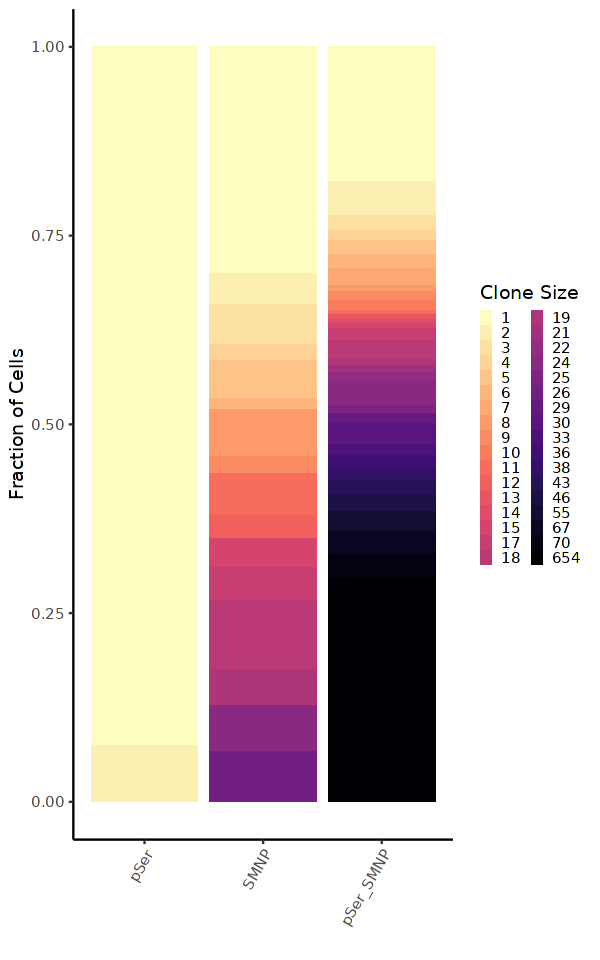

In [205]:
options(repr.plot.height=8, repr.plot.width=5)
count = countClones(metadata,clone='CLONE')
metadata$clonal.size=count$seq_count[match(metadata$CLONE,count$CLONE)]

metadata %>% filter(IGH_ISOTYPE!='NA') %>% 
ggplot(aes(x=Group, fill=factor(clonal.size))) + theme_classic() + 
geom_bar(position='fill') + 
labs(x='',y='Fraction of Cells',fill='Clone Size') + 
scale_fill_viridis(discrete=TRUE, direction=-1, option='magma', na.value='grey')+ 
theme(axis.text.x=element_text(angle=60,hjust=1)) +# NoLegend()
guides(fill = guide_legend(keywidth = 0.5, keyheight = 0.2,ncol = 2))


`summarise()` has grouped output by 'Group', 'Mouse'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'Group'. You can override using the
`.groups` argument.
Warning message in wilcox.test.default(c(0.693147180559945, 1.94591014905531, 0.693147180559945, :
“cannot compute exact p-value with ties”


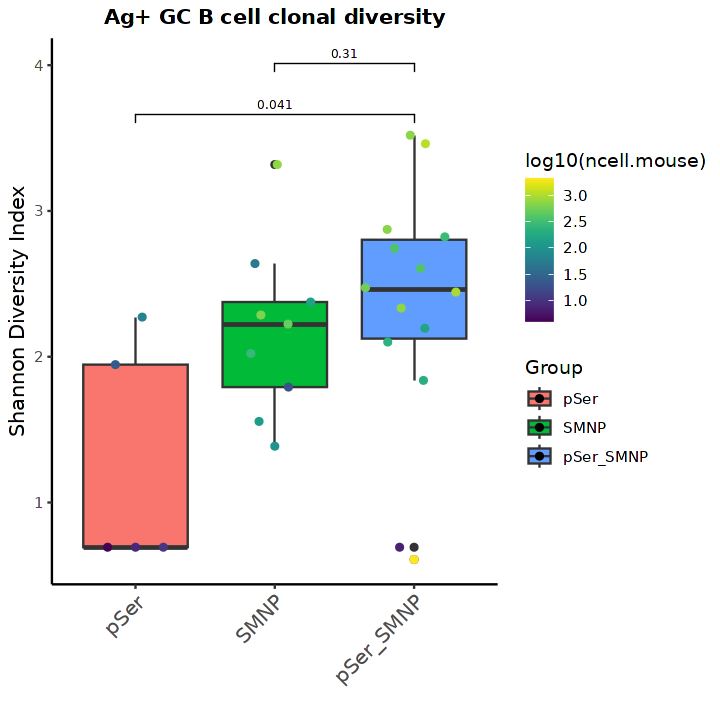

In [217]:
df4gg = metadata %>% 
group_by(Group, Mouse, CLONE) %>% summarize(ncell.clone.mouse = n()) %>% 
mutate(ncell.mouse = sum(ncell.clone.mouse)) %>% filter(CLONE>0) %>% 
mutate(nbcr.mouse = sum(ncell.clone.mouse)) %>% filter(nbcr.mouse>1) %>% 
summarize(div = vegan::diversity(ncell.clone.mouse),
          ncell.mouse = mean(ncell.mouse),nbcr.mouse=mean(nbcr.mouse))

# df4gg=df4gg %>% filter(ncell.mouse > as.numeric(quantile(df4gg$ncell.mouse, probs = 0.1))) %>%
# filter(ncell.mouse < as.numeric(quantile(df4gg$ncell.mouse, probs = 0.95))) 
#df4gg=df4gg %>% group_by(Group) %>% filter(ncell.mouse!=max(ncell.mouse))
#df4gg=df4gg %>% filter(ncell.mouse > 2)

options(repr.plot.width=6, repr.plot.height=6)

my.comparison = list(c('pSer','pSer_SMNP'),c('SMNP','pSer_SMNP'))

df4gg %>% 
ggplot(aes(x=Group, y=div, fill=Group)) + theme_classic()+
geom_boxplot() + geom_quasirandom(aes(color=log10(ncell.mouse))) + #aes(color=log10(ncell.mouse))
#scale_fill_nejm(alpha=0.8) +
stat_compare_means(method = "wilcox.test",label = 'p.format',label.y.npc='top',
                   tip.length = 0.02,comparisons = my.comparison,size=2.5)+
scale_color_viridis()+
labs(y='Shannon Diversity Index', x='', title='Ag+ GC B cell clonal diversity') + 
theme(plot.title=element_text(size=12,hjust=0.5, face='bold'), 
      axis.text.x=element_text(size=12,angle=45,hjust=1),
      axis.title.y=element_text(size=12),strip.text=element_text(size=16)) 

`summarise()` has grouped output by 'CLONE'. You can override using the
`.groups` argument.


[1] "clus.frac>=0.5, conscount>=6, ncell.per.clone>=5"


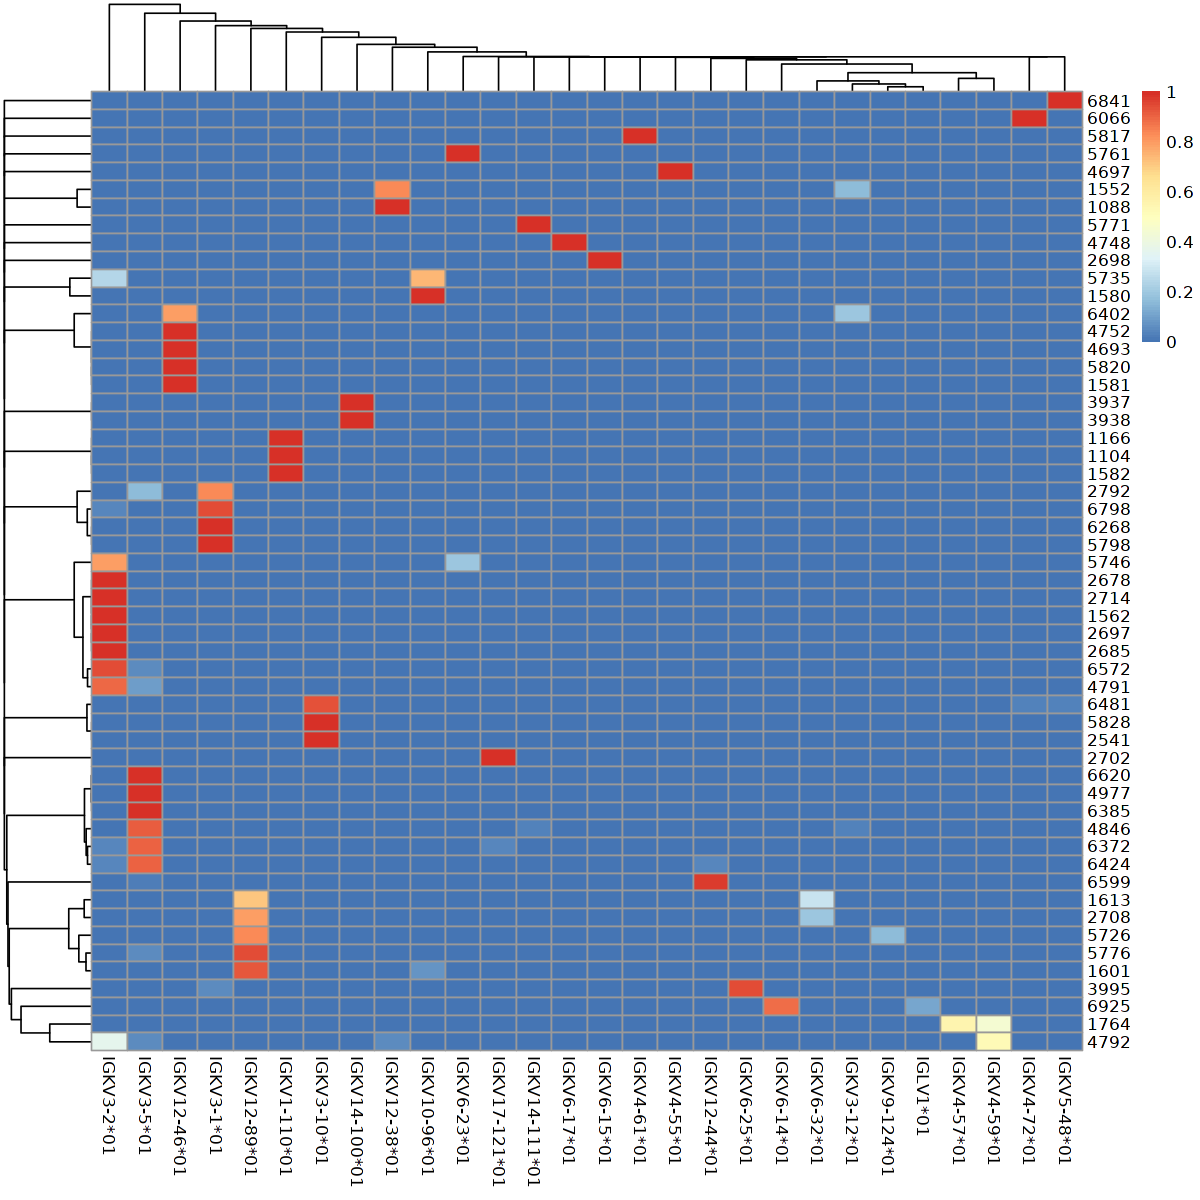

In [206]:
test = metadata %>% filter(Recovery==3) 
df = test %>% group_by(CLONE, IGL_V_CALL) %>% summarize(ncell.clone.igl=n()) %>% 
mutate(ncell.clone=sum(ncell.clone.igl)) %>% filter(ncell.clone>4) 

df2 = dcast(df,CLONE~IGL_V_CALL,value.var='ncell.clone.igl') %>% replace(is.na(.),0) 
rownames(df2) = df2$CLONE
mtx = df2 %>% select(-CLONE) %>% as.matrix()
mtx = mtx[order(rowSums(mtx),decreasing=TRUE),]
mtx2 = mtx/rowSums(mtx)
print(sprintf('clus.frac>=%.1f, conscount>=%d, ncell.per.clone>=%d',
              min(hc.match$R1_CLUSTER_FRACTION),min(hc.match$R1CONSCOUNT),min(df$ncell.clone)))
options(repr.plot.height=10, repr.plot.width=10)
pheatmap::pheatmap(mtx2, cluster_rows=T)

`summarise()` has grouped output by 'CLONE'. You can override using the
`.groups` argument.


[1] "clus.frac>=0.5, conscount>=4, ncell.per.clone>=5"


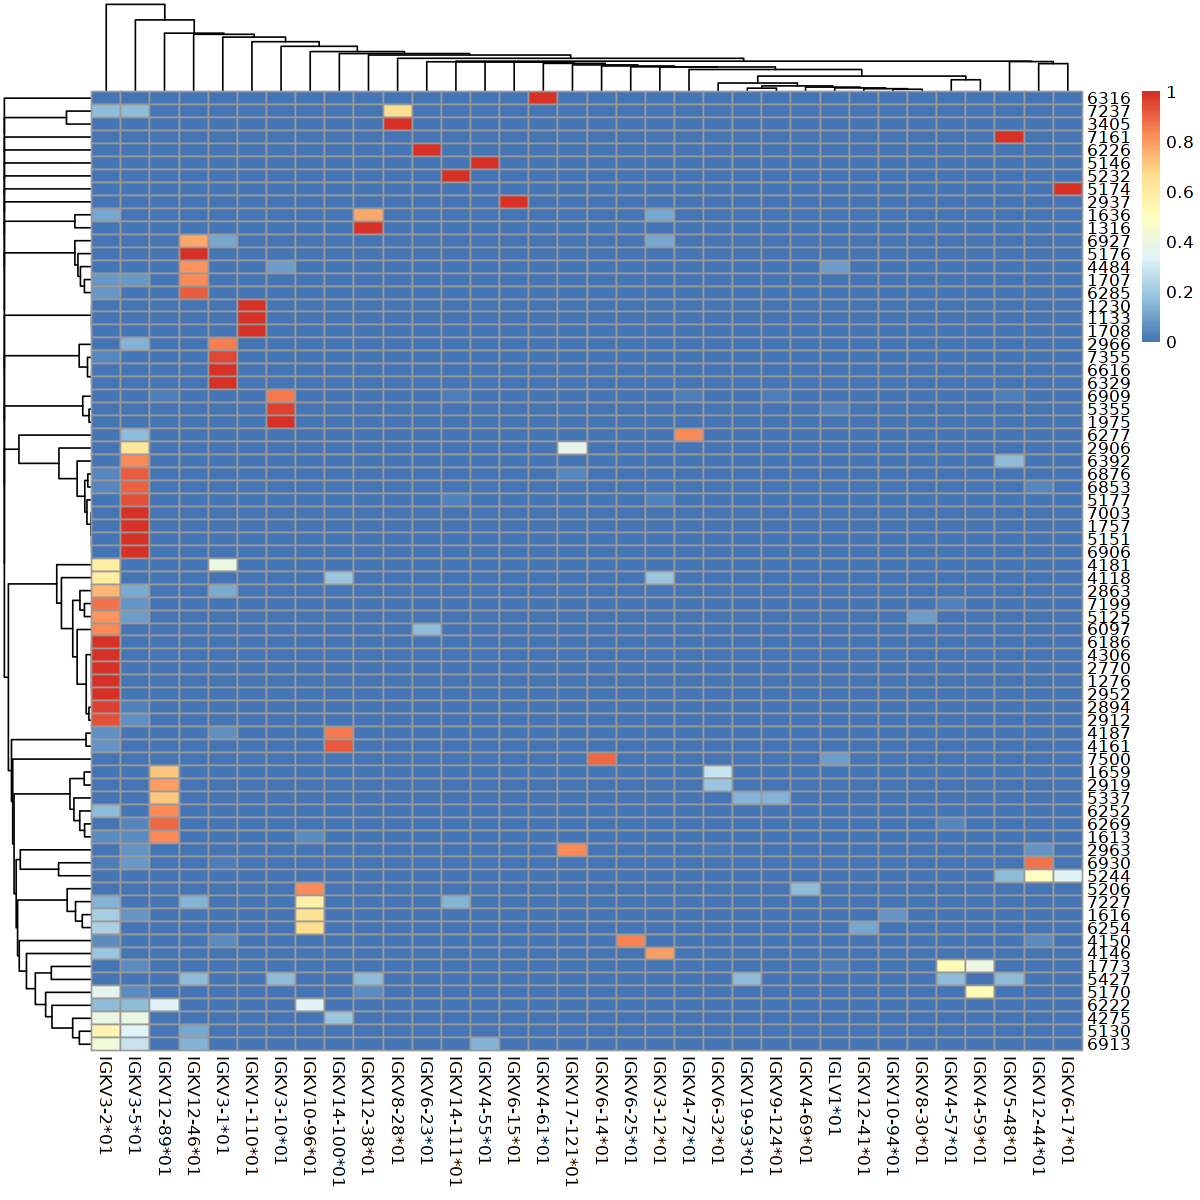

In [144]:
test = metadata %>% filter(Recovery==3) 
df = test %>% group_by(CLONE, IGL_V_CALL) %>% summarize(ncell.clone.igl=n()) %>% 
mutate(ncell.clone=sum(ncell.clone.igl)) %>% filter(ncell.clone>4) 

df2 = dcast(df,CLONE~IGL_V_CALL,value.var='ncell.clone.igl') %>% replace(is.na(.),0) 
rownames(df2) = df2$CLONE
mtx = df2 %>% select(-CLONE) %>% as.matrix()
mtx = mtx[order(rowSums(mtx),decreasing=TRUE),]
mtx2 = mtx/rowSums(mtx)
print(sprintf('clus.frac>=%.1f, conscount>=%d, ncell.per.clone>=%d',
              min(hc.match$R1_CLUSTER_FRACTION),min(hc.match$R1CONSCOUNT),min(df$ncell.clone)))
options(repr.plot.height=10, repr.plot.width=10)
pheatmap::pheatmap(mtx2, cluster_rows=T)

`summarise()` has grouped output by 'CLONE'. You can override using the
`.groups` argument.


[1] "clus.frac>=0.5, conscount>=5, ncell.per.clone>=5"


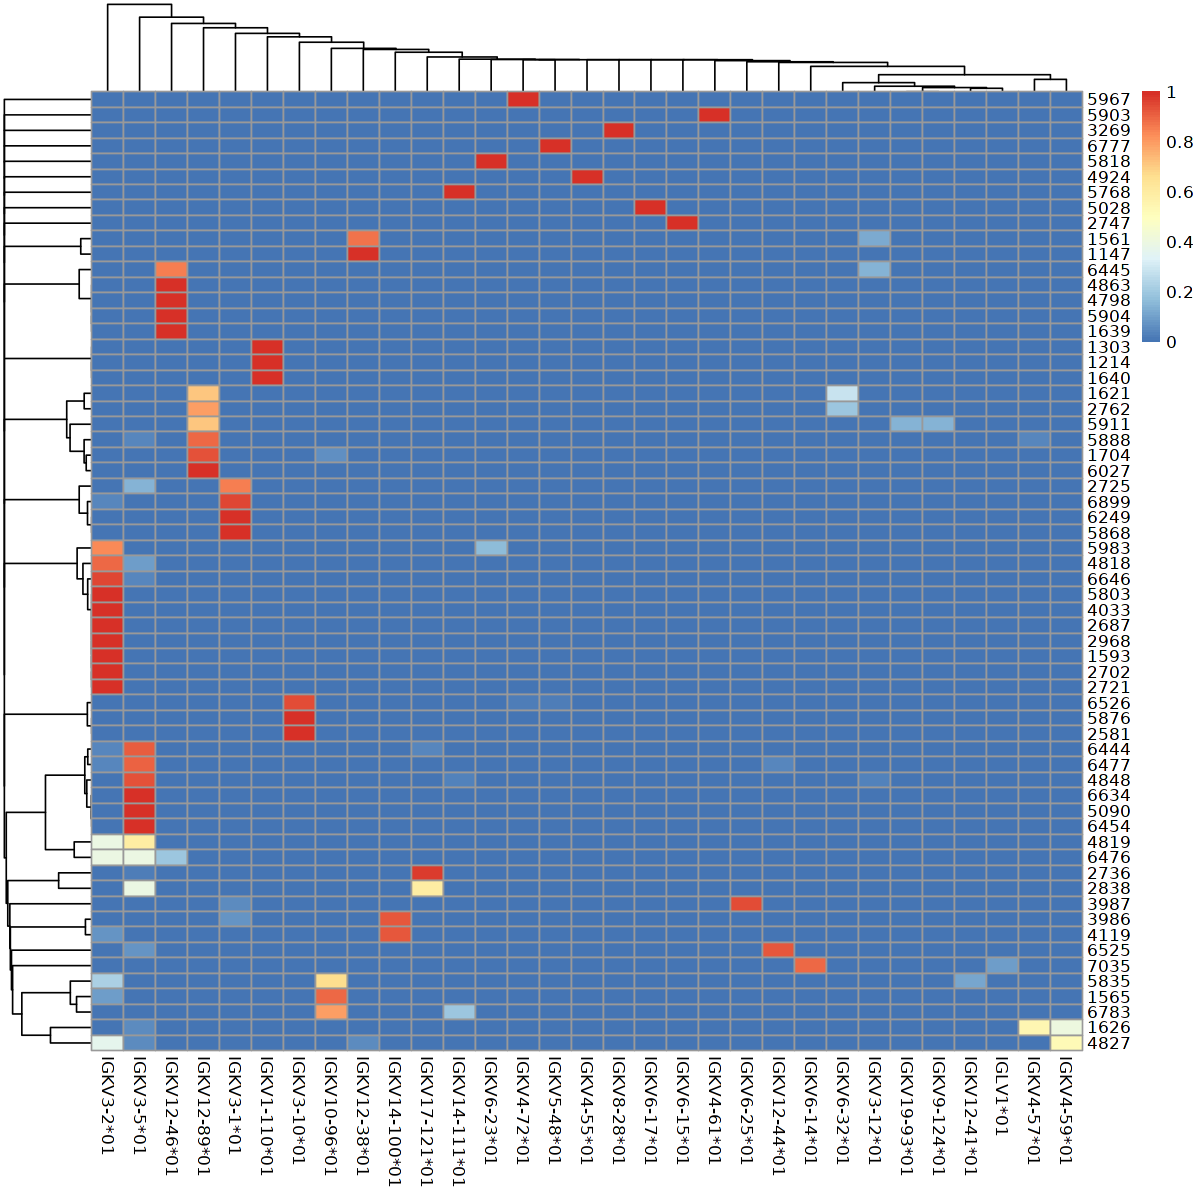

In [133]:
test = metadata %>% filter(Recovery==3) 
df = test %>% group_by(CLONE, IGL_V_CALL) %>% summarize(ncell.clone.igl=n()) %>% 
mutate(ncell.clone=sum(ncell.clone.igl)) %>% filter(ncell.clone>4) 

df2 = dcast(df,CLONE~IGL_V_CALL,value.var='ncell.clone.igl') %>% replace(is.na(.),0) 
rownames(df2) = df2$CLONE
mtx = df2 %>% select(-CLONE) %>% as.matrix()
mtx = mtx[order(rowSums(mtx),decreasing=TRUE),]
mtx2 = mtx/rowSums(mtx)
print(sprintf('clus.frac>=%.1f, conscount>=%d, ncell.per.clone>=%d',
              min(hc.match$R1_CLUSTER_FRACTION),min(hc.match$R1CONSCOUNT),min(df$ncell.clone)))
options(repr.plot.height=10, repr.plot.width=10)
pheatmap::pheatmap(mtx2, cluster_rows=T)

`summarise()` has grouped output by 'CLONE'. You can override using the
`.groups` argument.


[1] "clus.frac>=0.5, conscount>=8, ncell.per.clone>=5"


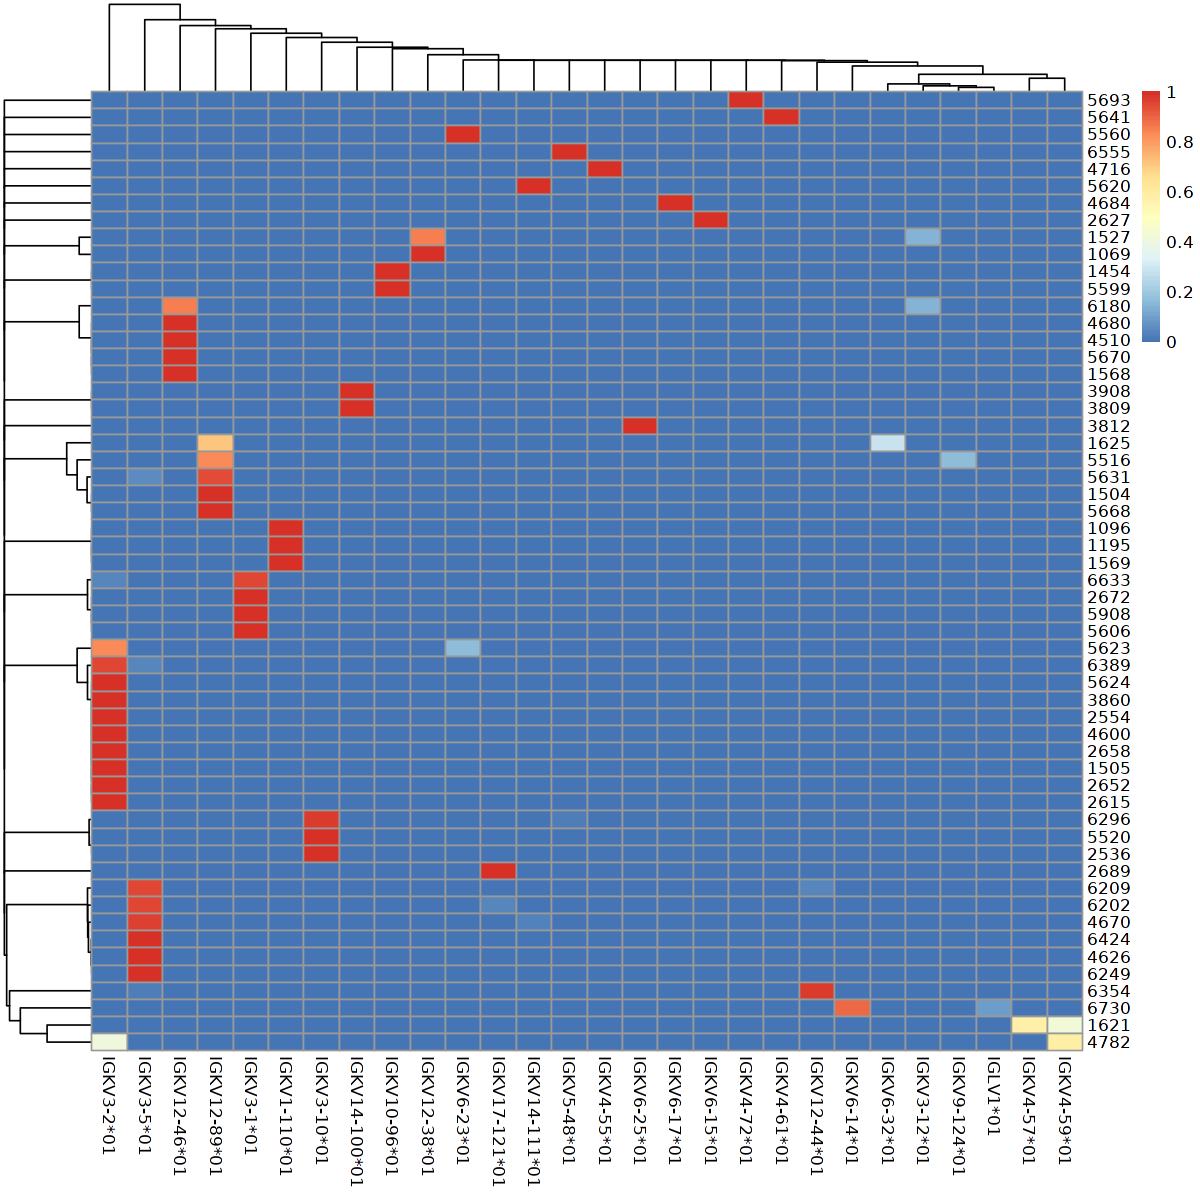

In [156]:
test = metadata %>% filter(Recovery==3) 
df = test %>% group_by(CLONE, IGL_V_CALL) %>% summarize(ncell.clone.igl=n()) %>% 
mutate(ncell.clone=sum(ncell.clone.igl)) %>% filter(ncell.clone>4) 

df2 = dcast(df,CLONE~IGL_V_CALL,value.var='ncell.clone.igl') %>% replace(is.na(.),0) 
rownames(df2) = df2$CLONE
mtx = df2 %>% select(-CLONE) %>% as.matrix()
mtx = mtx[order(rowSums(mtx),decreasing=TRUE),]
mtx2 = mtx/rowSums(mtx)
print(sprintf('clus.frac>=%.1f, conscount>=%d, ncell.per.clone>=%d',
              min(hc.match$R1_CLUSTER_FRACTION),min(hc.match$R1CONSCOUNT),min(df$ncell.clone)))
options(repr.plot.height=10, repr.plot.width=10)
pheatmap::pheatmap(mtx2, cluster_rows=T)

## metaclones

In [ ]:
gc = readRDS('md39/seurat_objects/06_md39_labeled_gc2.RDS')
gc

In [8]:
srat = readRDS('md39/seurat_objects/04_md39_singlet_bcells.RDS')
srat

An object of class Seurat 
16002 features across 38027 samples within 2 assays 
Active assay: RNA (15992 features, 2000 variable features)
 1 other assay present: HTO
 2 dimensional reductions calculated: pca, umap

In [17]:
hc = read.table('md39/processed_repertoire_data/06_hc_private_clones_germ-pass.tab',
                stringsAsFactors = FALSE, header = TRUE, sep = '\t')
dim(hc)
lc = read.table('md39/processed_repertoire_data/04_lc_translated.tab',
                stringsAsFactors = FALSE, header = TRUE, sep = '\t')
dim(lc)

[1] 10936    96

[1] 16529    87

In [18]:
metadata = srat@meta.data
hc.match = hc %>% filter(hc$LANE_ID %in% metadata$id)
dim(hc)
lc.match = lc %>% filter(lc$LANE_ID %in% metadata$id)
dim(lc)
metadata$IGH_recovery = as.numeric(metadata$id %in% hc$LANE_ID) * 2
metadata$IGL_recovery = as.numeric(metadata$id %in% lc$LANE_ID)
metadata$Recovery = metadata$IGH_recovery + metadata$IGL_recovery

[1] 10936    96

[1] 16529    87

In [19]:
# add heavy chain info to metadata 
a = hc.match[c('LANE_ID','VPRIMER','ISOTYPE','CDR3NUC','CDR3',
               'CLONE','GERMLINE_V_CALL')]
colnames(a)<-paste('IGH',colnames(a),sep="_")
metadata = merge(metadata, a,by.x='id', by.y='IGH_LANE_ID', all.x=TRUE)
rownames(metadata)= metadata$id
# calculate clonal size 
clonal.size=countClones(metadata,clone = 'IGH_CLONE')
metadata$clonal.size = clonal.size$seq_count[match(metadata$IGH_CLONE,clonal.size$IGH_CLONE)]

Warning message in countClones(metadata, clone = "IGH_CLONE"):
“NA(s) found in 27091 row(s) of the IGH_CLONE column and excluded from tabulation”


In [20]:
# add light chain info to metadata 
b = lc.match[c('LANE_ID','VPRIMER','ISOTYPE','CDR3nuc','CDR3','V_CALL')]
colnames(b)<-paste('IGL',colnames(b),sep="_")
b = b %>% mutate(IGL_V_CALL = str_split_i(IGL_V_CALL,',',1))
metadata = merge(metadata, b,by.x='id', by.y='IGL_LANE_ID', all.x=TRUE)
rownames(metadata)= metadata$id


In [21]:
metadata=aminoAcidProperties(metadata,seq="IGH_CDR3",label="hcdr3",nt=FALSE,trim=FALSE)
metadata=aminoAcidProperties(metadata,seq="IGL_CDR3",label="lcdr3",nt=FALSE,trim=FALSE)

Warning message in aminoAcidProperties(metadata, seq = "IGH_CDR3", label = "hcdr3", :
“Found 27091 sequences with non valid amino acid symbols”
Warning message in aminoAcidProperties(metadata, seq = "IGL_CDR3", label = "lcdr3", :
“Found 21560 sequences with non valid amino acid symbols”


In [22]:
table(metadata$Group,metadata$Phenotype)

           
            Ag_neg   GC nonGC
  Naive       1051    0     0
  pSer         726  255  9408
  SMNP        3173 3052  6195
  pSer_SMNP    420 9870  3877

In [3]:
test = metadata %>% filter(Recovery==3) 
tab = table(test$IGH_CLONE,test$IGL_V_CALL)
tab =tab[rowSums(tab) > 3,]
tab = tab[,colSums(tab) > 0]
tab = tab/rowSums(tab)
dim(tab)

ERROR: Error in metadata %>% filter(Recovery == 3): could not find function "%>%"


In [2]:
options(repr.plot.height=10, repr.plot.width=10)
# hc R1 Clust Frac > 0.5, R2 Clust Frac > 0.5
# lc R1 Clust Frac > 0.5, R2 Clust Frac > 0.5
pheatmap::pheatmap(tab,cluster_row=FALSE)

ERROR: Error in rownames(mat): object 'tab' not found


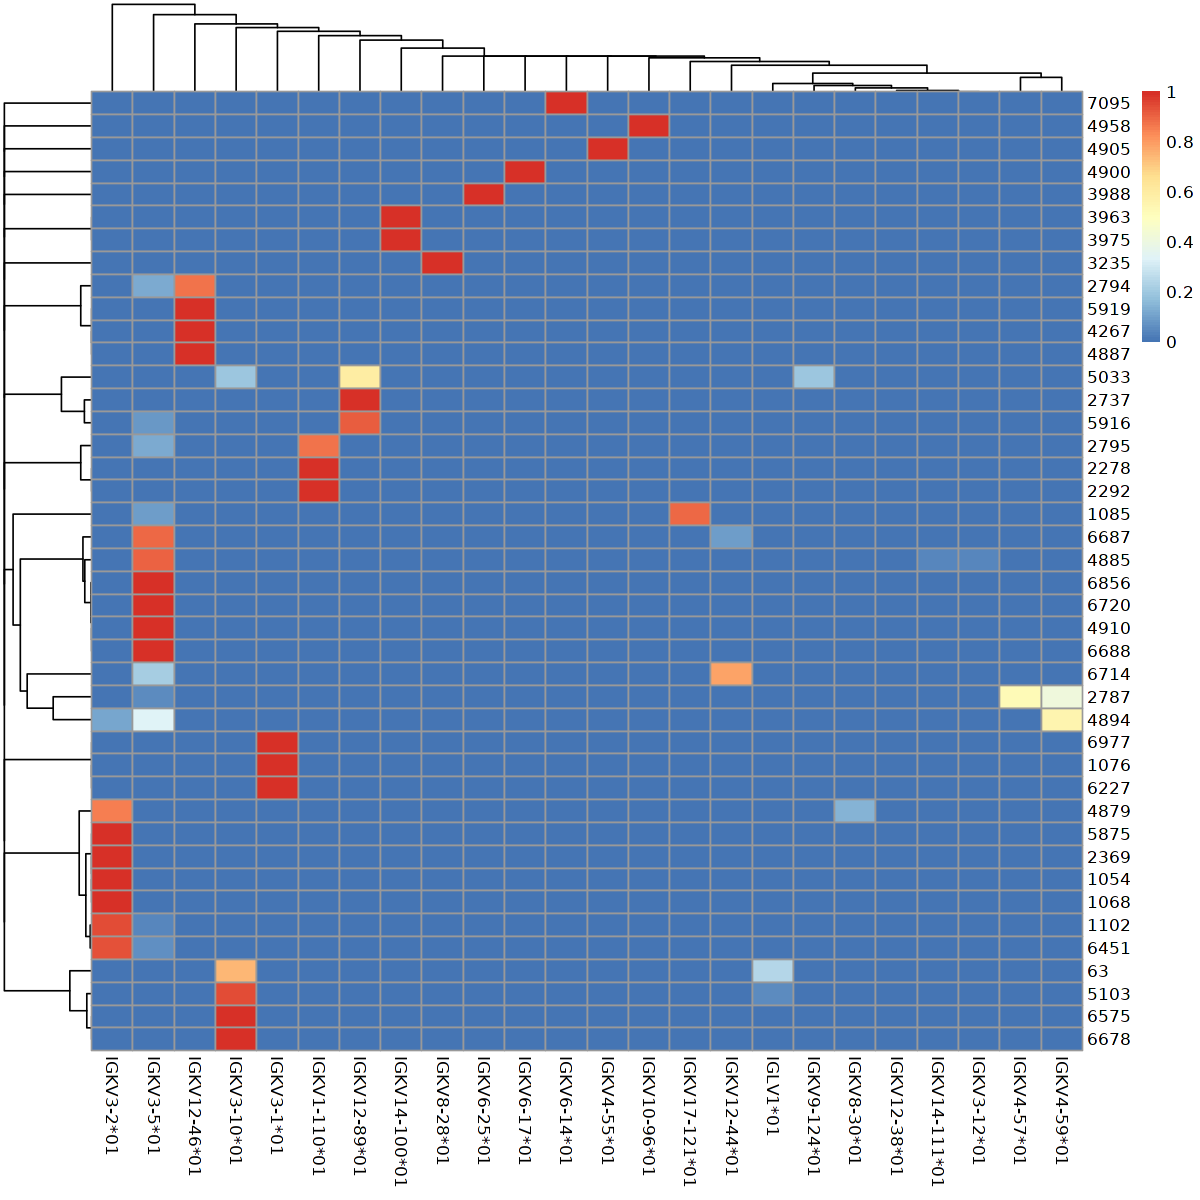

In [12]:
options(repr.plot.height=10, repr.plot.width=10)
# hc R1 Clust Frac > 0.5, R2 Clust Frac > 0.4
# lc R1 Clust Frac > 0.5, R2 Clust Frac > 0.5
pheatmap::pheatmap(tab)

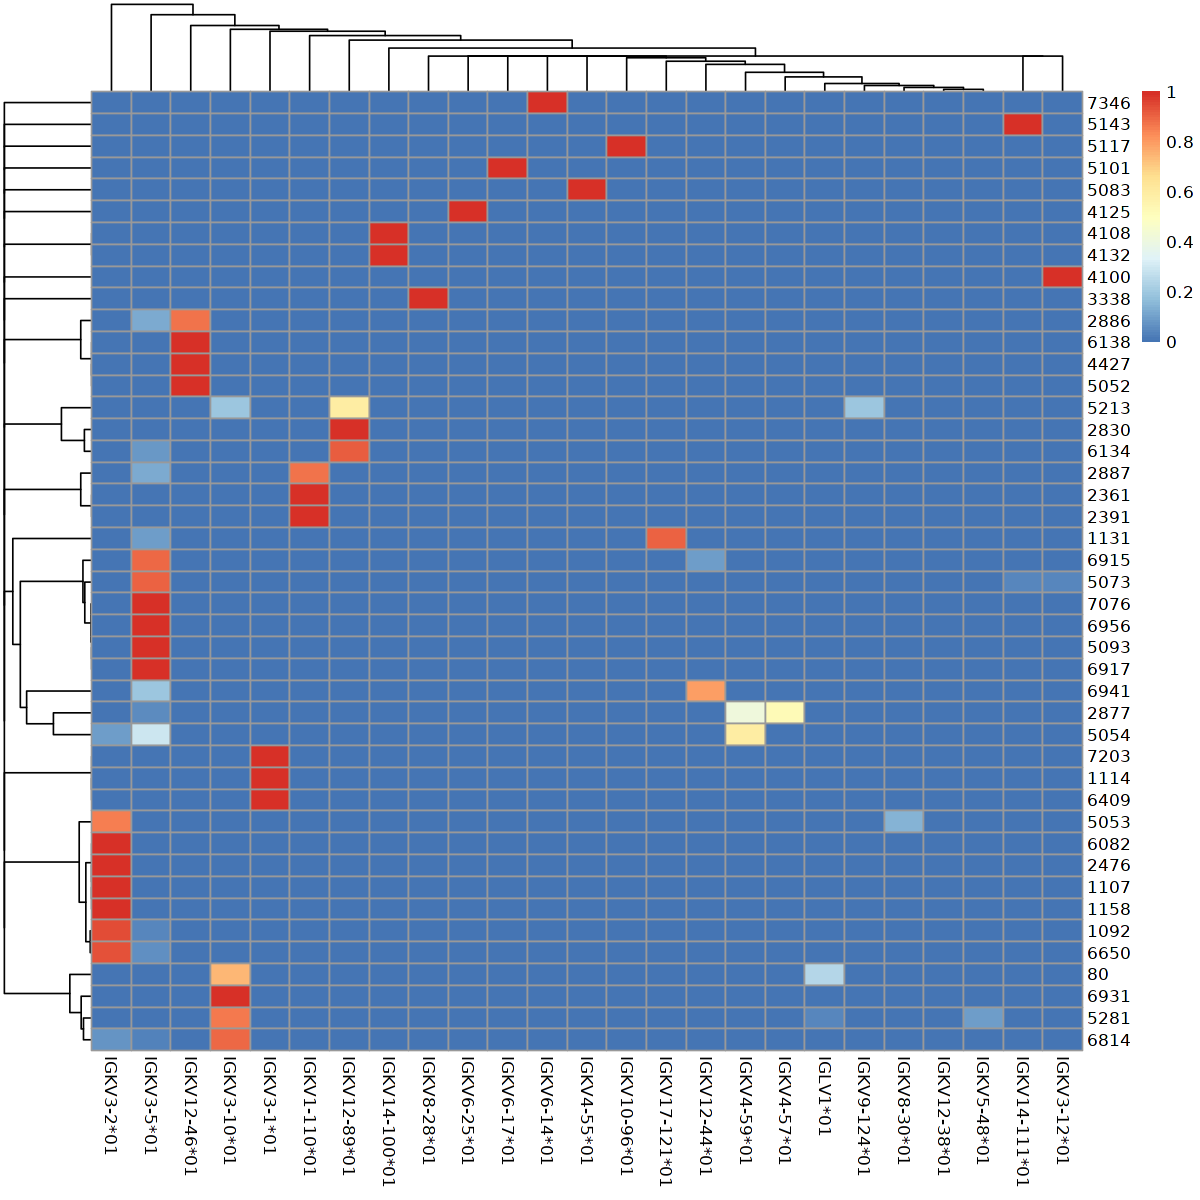

In [256]:
options(repr.plot.height=10, repr.plot.width=10)
# hc R1 Clust Frac > 0.4, R2 Clust Frac > 0.4
# lc R1 Clust Frac > 0.5, R2 Clust Frac > 0.5
pheatmap::pheatmap(tab)

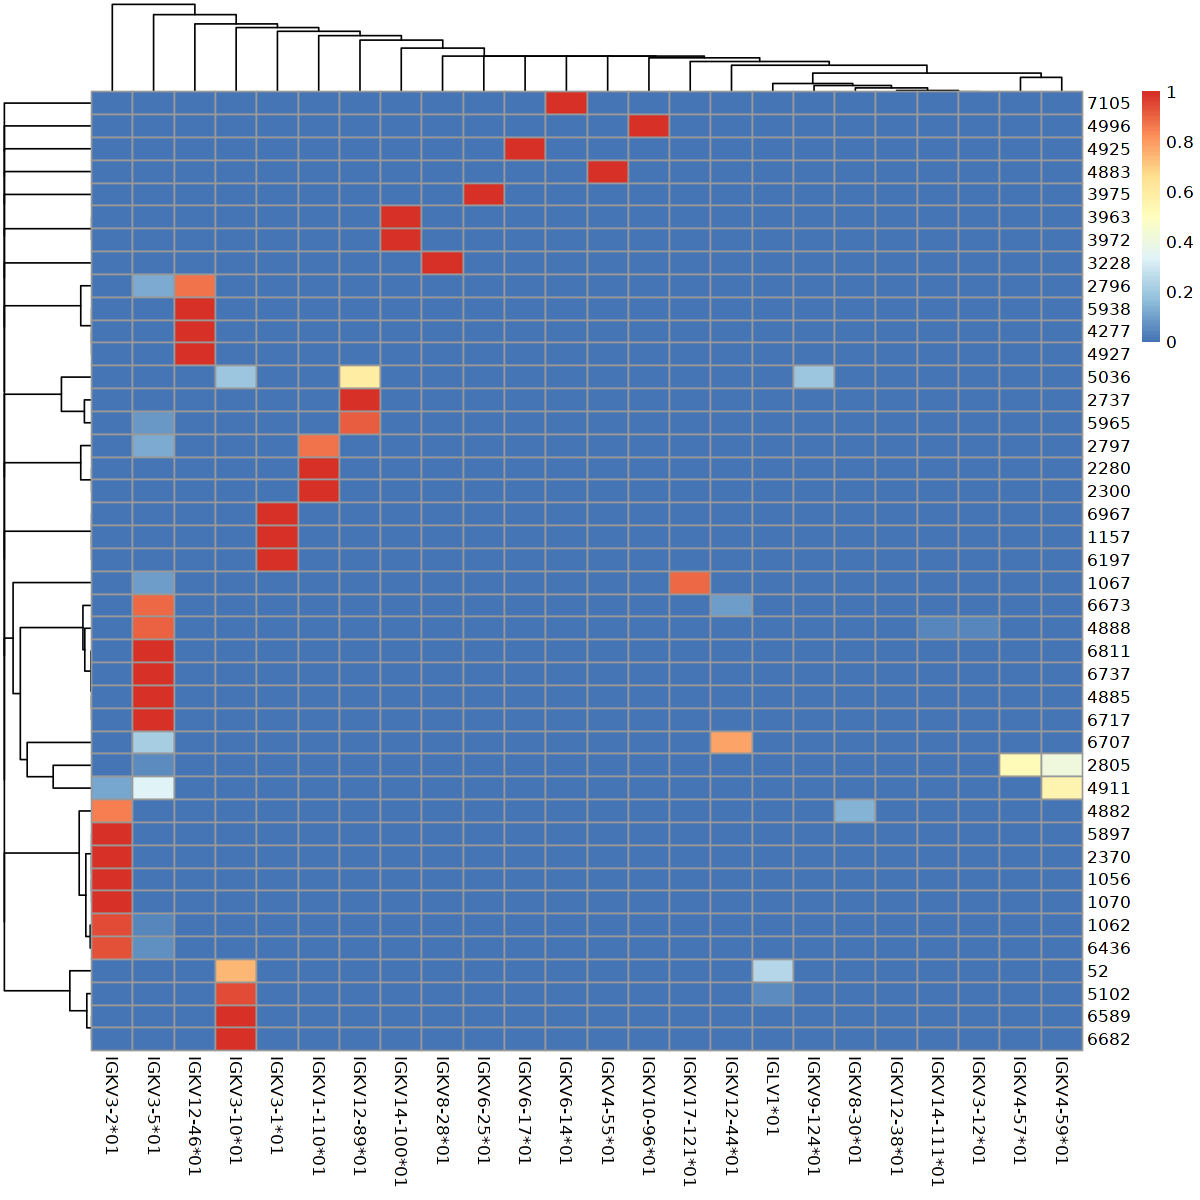

In [205]:
options(repr.plot.height=10, repr.plot.width=10)
# hc R1 Clust Frac > 0.4, R2 Clust Frac > 0.5
# lc R1 Clust Frac > 0.5, R1 Clust Frac > 0.5
pheatmap::pheatmap(tab)

[1] 67 68

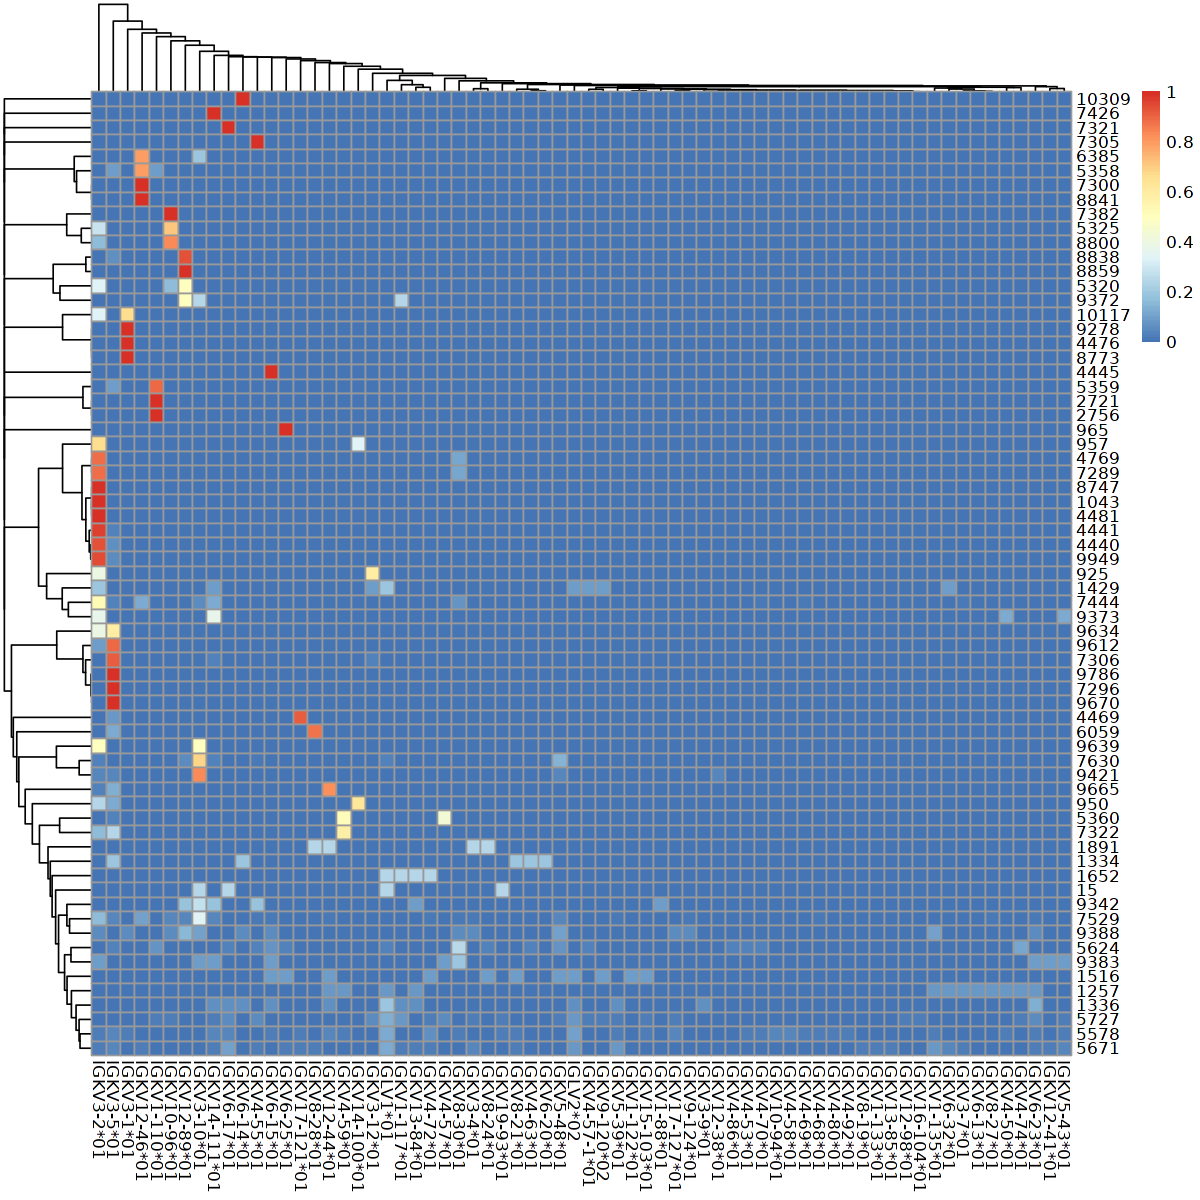

In [84]:
options(repr.plot.height=10, repr.plot.width=10)
# no filtering
pheatmap::pheatmap(tab)

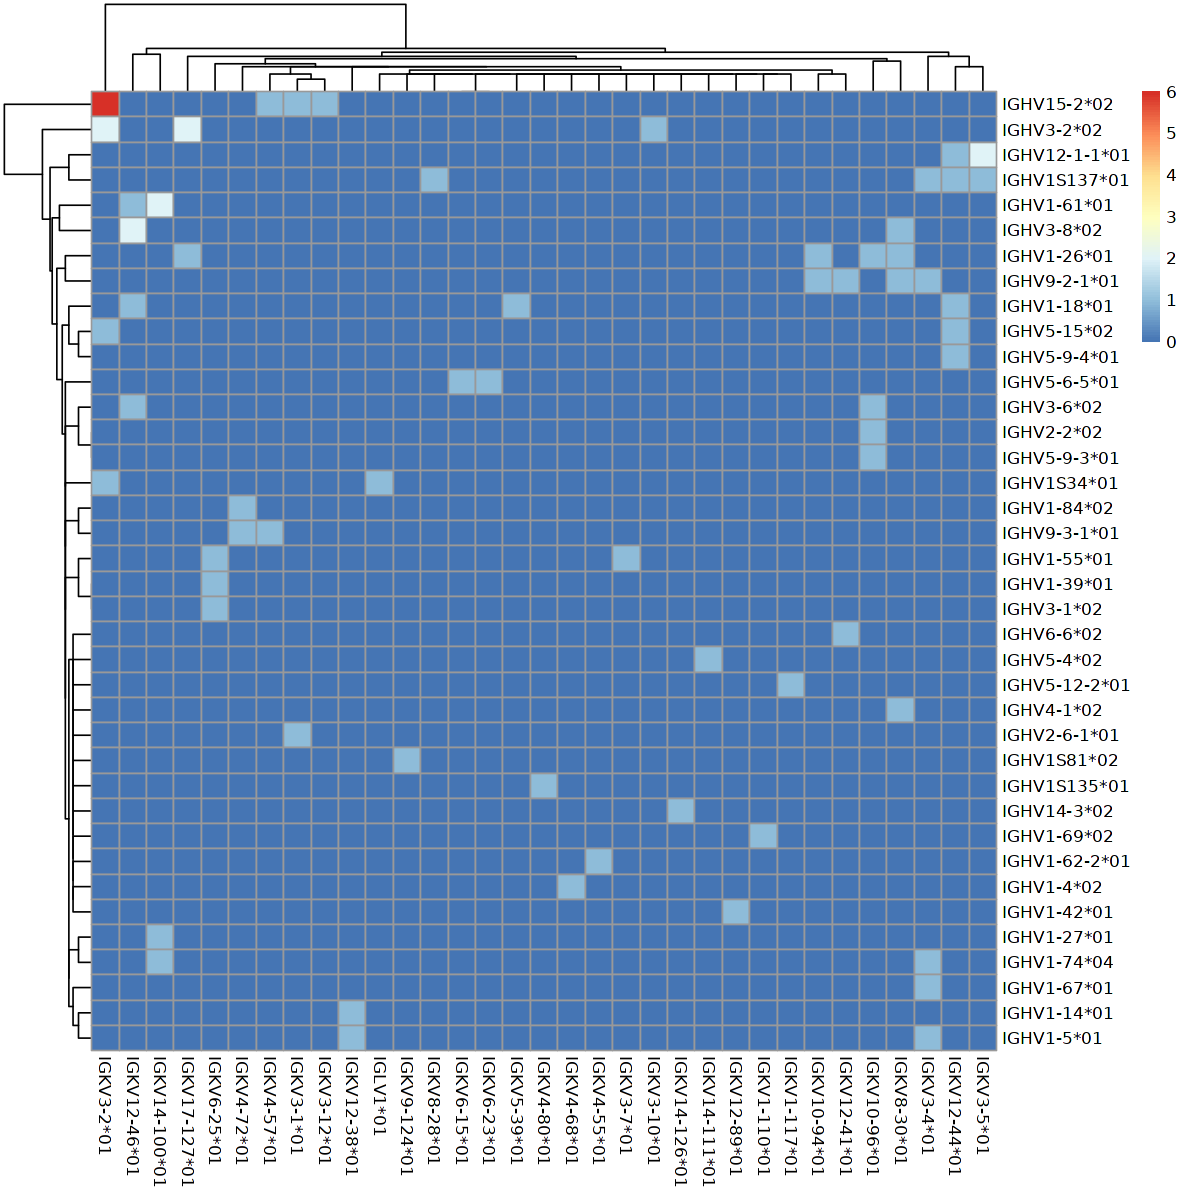

In [400]:
test = metadata %>% filter(Recovery==3) 
a = test %>% dplyr::select(Group,Phenotype,IGH_CLONE,IGH_GERMLINE_V_CALL,IGL_V_CALL) %>% unique() %>% 
filter(Group=='SMNP',Phenotype=='GC')
tab = table(a$IGH_GERMLINE_V_CALL,a$IGL_V_CALL)
pheatmap::pheatmap(tab)

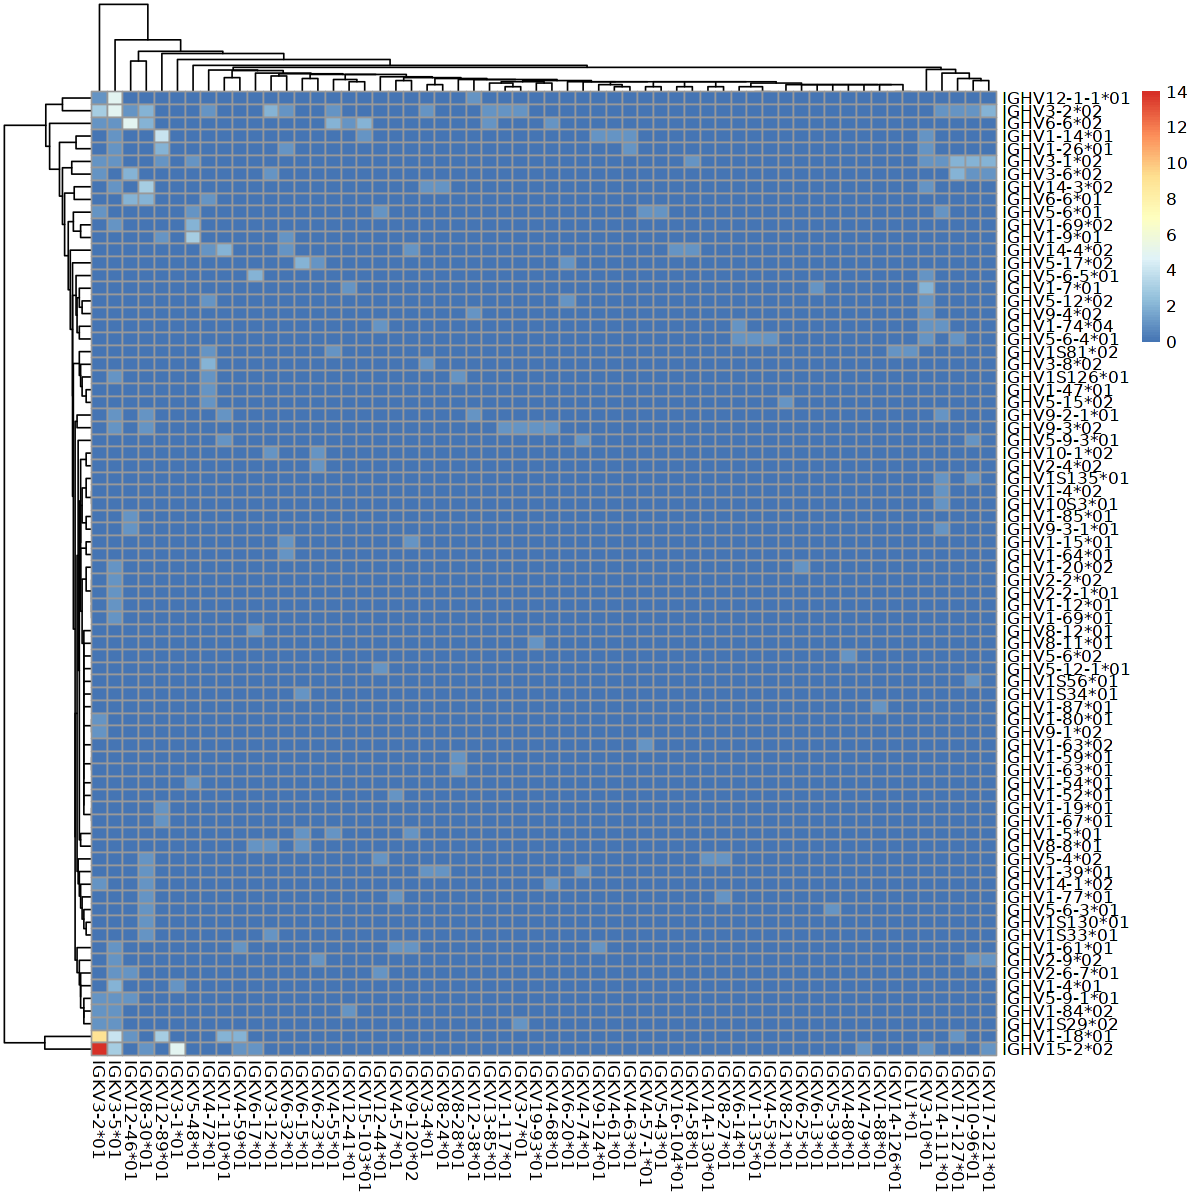

In [395]:
test = metadata %>% filter(Recovery==3) 
a = test %>% dplyr::select(Group,Phenotype,IGH_CLONE,IGH_GERMLINE_V_CALL,IGL_V_CALL) %>% unique() %>% 
filter(Group=='pSer_SMNP',Phenotype=='GC')
tab = table(a$IGH_GERMLINE_V_CALL,a$IGL_V_CALL)
pheatmap::pheatmap(tab)

## usage bias

Warning message in countGenes(., gene = "IGH_GERMLINE_V_CALL", groups = c("Phenotype"), :
“NA(s) found in 14660 row(s) of the IGH_GERMLINE_V_CALL column and excluded from tabulation”
Warning message:
“Removed 58 rows containing missing values (`geom_text()`).”


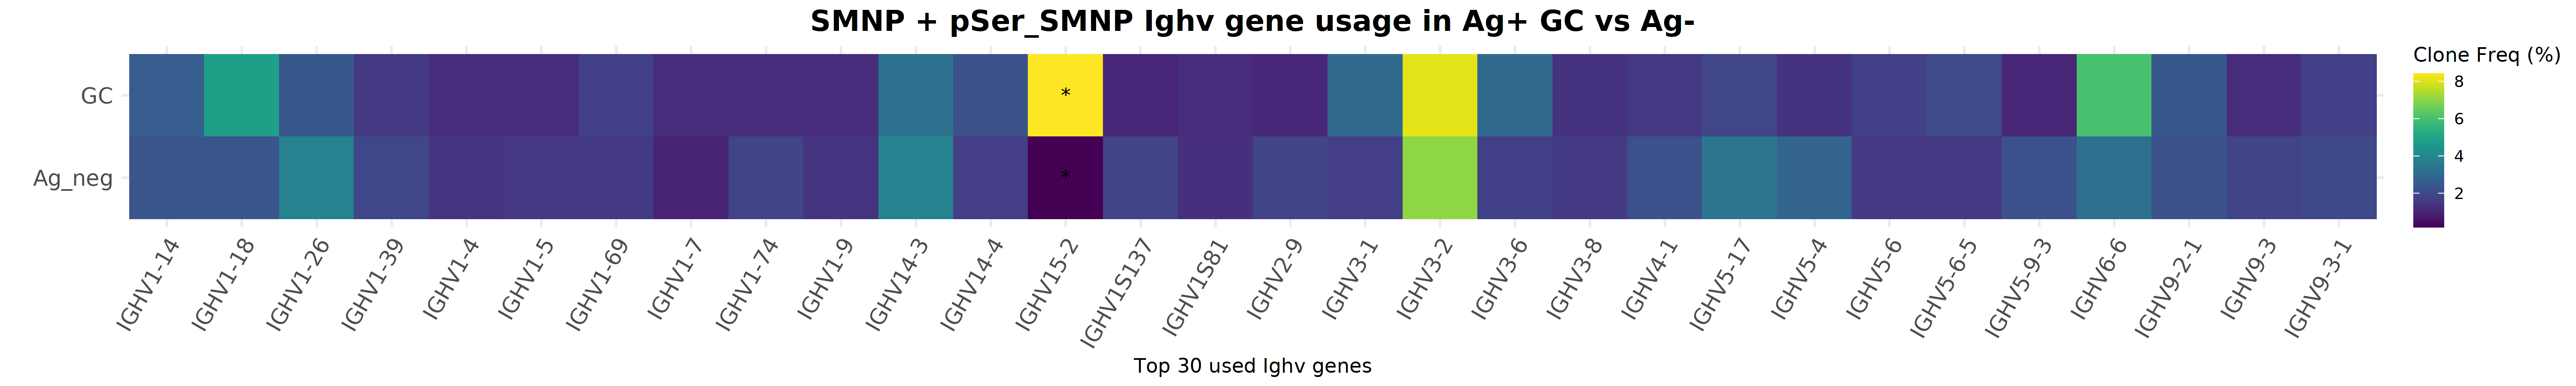

In [148]:
# count v genes
heavy.vcount = metadata %>% filter(Group !='pSer', Phenotype!='nonGC') %>% 
countGenes(.,gene='IGH_GERMLINE_V_CALL',groups = c('Phenotype'),clone = 'IGH_CLONE',fill = TRUE,mode='gene')

# keep top 30 used v genes
gene2keep = heavy.vcount %>% group_by(gene) %>% summarize(n = sum(clone_freq)) %>% arrange(desc(n)) %>% head(30)

# fischer's exact test 
a = heavy.vcount %>% filter(Phenotype=='GC', gene %in%  gene2keep$gene) 
b = heavy.vcount %>% filter(Phenotype=='Ag_neg', gene %in%  gene2keep$gene) 
genes = a$gene
results = jz.fischer.test(a$clone_count,b$clone_count,genes,side='greater',correction = 'BH')

# heatmap visualization
options(repr.plot.res=300,repr.plot.width=20,repr.plot.height=3)

df4gg = rbind(a,b)
df4gg$p.adj = results$p.adj[match(df4gg$gene,results$gene)]

df4gg %>% mutate(clone_freq = clone_freq *100) %>% 
mutate(label=ifelse(p.adj<0.05,'*',NA)) %>% 
ggplot(aes(x=gene,y=Phenotype, fill=clone_freq)) + theme_minimal()+
geom_tile() + geom_text(aes(label=label))+
scale_fill_viridis() + 
labs(x='Top 30 used Ighv genes', y='',fill='Clone Freq (%)',
     title='SMNP + pSer_SMNP Ighv gene usage in Ag+ GC vs Ag-')+
theme(axis.text.x=element_text(angle=60,hjust=1,size=12),
      plot.title=element_text(hjust=0.5,size=16, face='bold'),
      axis.text.y=element_text(size=12))

Warning message in countGenes(., gene = "IGL_V_CALL", groups = c("Phenotype"), clone = "IGH_CLONE", :
“NA(s) found in 8692 row(s) of the IGL_V_CALL column and excluded from tabulation”
Warning message:
“Removed 50 rows containing missing values (`geom_text()`).”


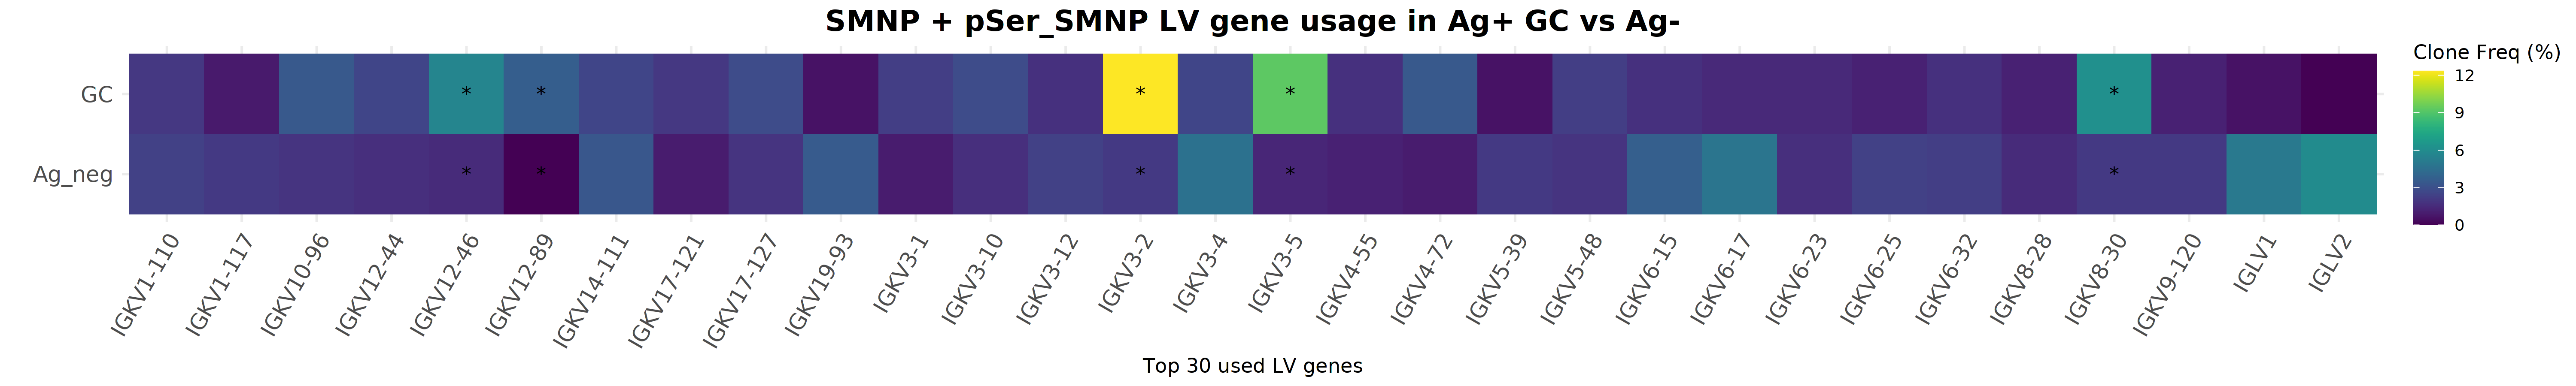

In [149]:
# count v genes
heavy.vcount = metadata %>% filter(Group !='pSer', Phenotype!='nonGC') %>% 
countGenes(.,gene='IGL_V_CALL',groups = c('Phenotype'),clone = 'IGH_CLONE',fill = TRUE,mode='gene')

# keep top 30 used v genes
gene2keep = heavy.vcount %>% group_by(gene) %>% summarize(n = sum(clone_freq)) %>% arrange(desc(n)) %>% head(30)

# fischer's exact test 
a = heavy.vcount %>% filter(Phenotype=='GC', gene %in%  gene2keep$gene) 
b = heavy.vcount %>% filter(Phenotype=='Ag_neg', gene %in%  gene2keep$gene) 
genes = a$gene
results = jz.fischer.test(a$clone_count,b$clone_count,genes,side='greater',correction = 'BH')

# heatmap visualization
options(repr.plot.res=300,repr.plot.width=20,repr.plot.height=3)

df4gg = rbind(a,b)
df4gg$p.adj = results$p.adj[match(df4gg$gene,results$gene)]

df4gg %>% mutate(clone_freq = clone_freq *100) %>% 
mutate(label=ifelse(p.adj<0.05,'*',NA)) %>% 
ggplot(aes(x=gene,y=Phenotype, fill=clone_freq)) + theme_minimal()+
geom_tile() + geom_text(aes(label=label))+
scale_fill_viridis() + 
labs(x='Top 30 used LV genes', y='',fill='Clone Freq (%)',
     title='SMNP + pSer_SMNP LV gene usage in Ag+ GC vs Ag-')+
theme(axis.text.x=element_text(angle=60,hjust=1,size=12),
      plot.title=element_text(hjust=0.5,size=16, face='bold'),
      axis.text.y=element_text(size=12))

Warning message in countGenes(metadata, gene = "IGH_GERMLINE_V_CALL", groups = c("Group", :
“NA(s) found in 29685 row(s) of the IGH_GERMLINE_V_CALL column and excluded from tabulation”
Warning message:
“Removed 60 rows containing missing values (`geom_text()`).”


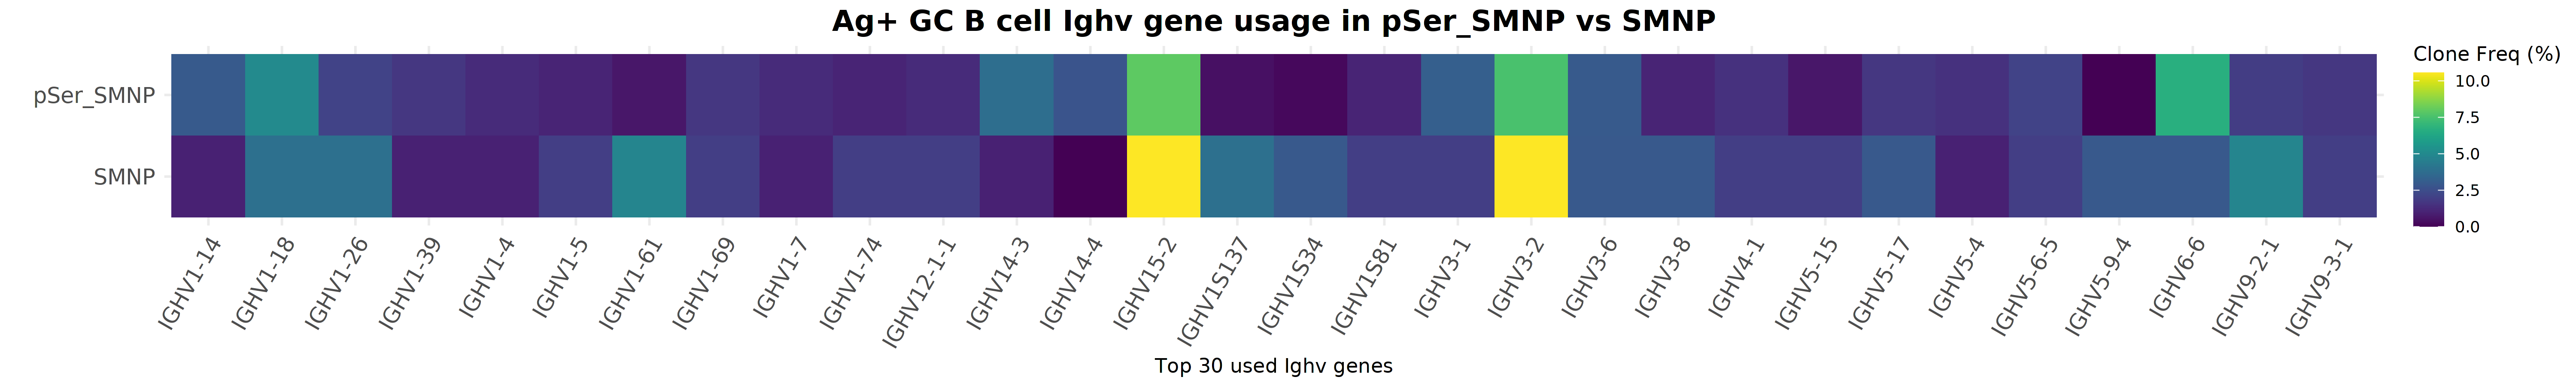

In [150]:
# count v genes
heavy.vcount = countGenes(metadata,gene='IGH_GERMLINE_V_CALL',groups = c('Group','Phenotype'),clone = 'IGH_CLONE',fill = TRUE,mode='gene') %>% 
filter(Group %in% c('SMNP','pSer_SMNP'), Phenotype=='GC') 

# keep top 30 used v genes
gene2keep = heavy.vcount %>% group_by(gene) %>% summarize(n = sum(clone_freq)) %>% arrange(desc(n)) %>% head(30)

# fischer's exact test 
a = heavy.vcount %>% filter(Phenotype=='GC', Group=='pSer_SMNP',gene %in%  gene2keep$gene) 
b = heavy.vcount %>% filter(Phenotype=='GC', Group=='SMNP',gene %in%  gene2keep$gene) 
genes = a$gene
results = jz.fischer.test(a$clone_count,b$clone_count,genes,side='two.sided',correction = 'BH')

# heatmap visualization
options(repr.plot.res=300,repr.plot.width=20,repr.plot.height=3)

df4gg = rbind(a,b)
df4gg$p.adj = results$p.adj[match(df4gg$gene,results$gene)]

df4gg %>% mutate(clone_freq = clone_freq *100) %>% 
mutate(label=ifelse(p.adj<0.05,'*',NA)) %>% 
ggplot(aes(x=gene,y=Group, fill=clone_freq)) + theme_minimal()+
geom_tile() + geom_text(aes(label=label))+
scale_fill_viridis() + 
labs(x='Top 30 used Ighv genes', y='',fill='Clone Freq (%)',
     title='Ag+ GC B cell Ighv gene usage in pSer_SMNP vs SMNP')+
theme(axis.text.x=element_text(angle=60,hjust=1,size=12),
      plot.title=element_text(hjust=0.5,size=16, face='bold'),
      axis.text.y=element_text(size=12))

Warning message in countGenes(metadata, gene = "IGL_V_CALL", groups = c("Group", :
“NA(s) found in 22038 row(s) of the IGL_V_CALL column and excluded from tabulation”
Warning message:
“Removed 60 rows containing missing values (`geom_text()`).”


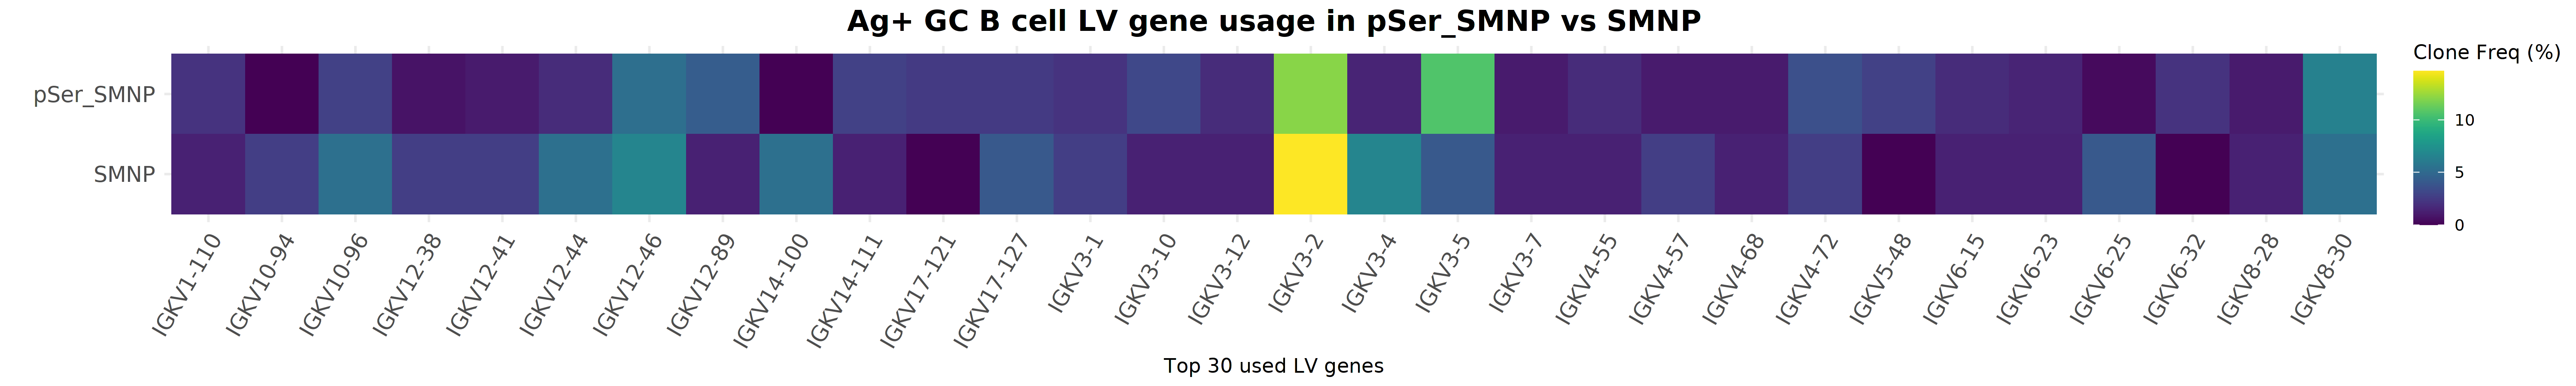

In [151]:
# count v genes
heavy.vcount = countGenes(metadata,gene='IGL_V_CALL',groups = c('Group','Phenotype'),clone = 'IGH_CLONE',fill = TRUE,mode='gene') %>% 
filter(Group %in% c('SMNP','pSer_SMNP'), Phenotype=='GC') 

# keep top 30 used v genes
gene2keep = heavy.vcount %>% group_by(gene) %>% summarize(n = sum(clone_freq)) %>% arrange(desc(n)) %>% head(30)

# fischer's exact test 
a = heavy.vcount %>% filter(Phenotype=='GC', Group=='pSer_SMNP',gene %in%  gene2keep$gene) 
b = heavy.vcount %>% filter(Phenotype=='GC', Group=='SMNP',gene %in%  gene2keep$gene) 
genes = a$gene
results = jz.fischer.test(a$clone_count,b$clone_count,genes,side='two.sided',correction = 'BH')

# heatmap visualization
options(repr.plot.res=300,repr.plot.width=20,repr.plot.height=3)

df4gg = rbind(a,b)
df4gg$p.adj = results$p.adj[match(df4gg$gene,results$gene)]

df4gg %>% mutate(clone_freq = clone_freq *100) %>% 
mutate(label=ifelse(p.adj<0.05,'*',NA)) %>% 
ggplot(aes(x=gene,y=Group, fill=clone_freq)) + theme_minimal()+
geom_tile() + geom_text(aes(label=label))+
scale_fill_viridis() + 
labs(x='Top 30 used LV genes', y='',fill='Clone Freq (%)',
     title='Ag+ GC B cell LV gene usage in pSer_SMNP vs SMNP')+
theme(axis.text.x=element_text(angle=60,hjust=1,size=12),
      plot.title=element_text(hjust=0.5,size=16, face='bold'),
      axis.text.y=element_text(size=12))

In [87]:
# remove allele info and keep the matched first v gene
df4gg = metadata %>% filter(IGH_CLONE>0, !is.na(IGL_V_CALL)) %>% 
mutate(IGH_GERMLINE_V_CALL = str_split_i(IGH_GERMLINE_V_CALL,'\\*',1)) %>% 
mutate(IGL_V_CALL = str_split_i(IGL_V_CALL,'\\*',1)) %>% 
mutate(IGH_GERMLINE_V_CALL = str_split_i(IGH_GERMLINE_V_CALL,',',1)) %>% 
mutate(IGL_V_CALL = str_split_i(IGL_V_CALL,',',1))


In [83]:
# populate light chain based on clone 
a = df4gg %>% 
group_by(IGH_CLONE,IGH_GERMLINE_V_CALL,IGL_V_CALL) %>% summarize(count=n()) %>%
mutate(clonal.size=sum(count),freq=count/clonal.size) %>%  arrange(desc(clonal.size)) %>% 
mutate(max_freq=max(freq) #, max_freq_igl = 
       ) # cons_IGL_V_CALL = ifelse(IGL_V_CALL=='NA' & freq == max_freq, )

`summarise()` has grouped output by 'IGH_CLONE', 'IGH_GERMLINE_V_CALL'. You can
override using the `.groups` argument.


In [88]:
# combine heavy and light chain 
df4gg$ig.pair = paste(df4gg$IGH_GERMLINE_V_CALL,df4gg$IGL_V_CALL,sep='_')


In [96]:
gene2keep = df4gg %>% group_by(ig.pair) %>% summarize(count= n()) %>%
arrange(desc(count)) %>% head(40)

In [102]:
#df4gg %>% group_by(Group,Phenotype,IGH_CLONE, IGL_V_CALL, ig.pair) %>% summarize(count= n()) %>%
#arrange(desc(count)) %>% head(40)

In [16]:
colnames(metadata)

[1] "id"                        "orig"                     
 [3] "nCount_RNA"                "nFeature_RNA"             
 [5] "bc"                        "Batch"                    
 [7] "Group"                     "Phenotype"                
 [9] "SeqFile"                   "HTOFile"                  
[11] "percent.mt"                "nCount_HTO"               
[13] "nFeature_HTO"              "HTO_maxID"                
[15] "HTO_secondID"              "HTO_margin"               
[17] "HTO_classification"        "HTO_classification.global"
[19] "hash.ID"                   "RNA_snn_res.0.1"          
[21] "RNA_snn_res.0.2"           "RNA_snn_res.0.3"          
[23] "RNA_snn_res.0.4"           "RNA_snn_res.0.5"          
[25] "RNA_snn_res.0.6"           "RNA_snn_res.0.7"          
[27] "RNA_snn_res.0.8"           "seurat_clusters"          
[29] "UMAP1"                     "UMAP2"                    
[31] "S.Score"                   "G2M.Score"                
[33] "Phase"                     "Mouse"                    
[35] "IGH_recovery"              "IGL_recovery"             
[37] "Recovery"                  "IGH_VPRIMER"              
[39] "IGH_ISOTYPE"               "IGH_CDR3NUC"              
[41] "IGH_CDR3"                  "IGH_CLONE"                
[43] "IGH_GERMLINE_V_CALL"       "clonal.size"              
[45] "IGL_VPRIMER"               "IGL_ISOTYPE"              
[47] "IGL_CDR3nuc"               "IGL_CDR3"                 
[49] "IGL_V_CALL"                "hcdr3_aa_length"          
[51] "hcdr3_aa_gravy"            "hcdr3_aa_bulk"            
[53] "hcdr3_aa_aliphatic"        "hcdr3_aa_polarity"        
[55] "hcdr3_aa_charge"           "hcdr3_aa_basic"           
[57] "hcdr3_aa_acidic"           "hcdr3_aa_aromatic"        
[59] "lcdr3_aa_length"           "lcdr3_aa_gravy"           
[61] "lcdr3_aa_bulk"             "lcdr3_aa_aliphatic"       
[63] "lcdr3_aa_polarity"         "lcdr3_aa_charge"          
[65] "lcdr3_aa_basic"            "lcdr3_aa_acidic"          
[67] "lcdr3_aa_aromatic"

In [65]:
df4gg = metadata %>% filter(startsWith(IGH_GERMLINE_V_CALL,'IGHV15-2'), IGH_CLONE>0,!is.na(IGL_V_CALL)) %>% 
arrange(desc(clonal.size))
df4gg = df4gg %>% dplyr::select(Group,Phenotype,IGH_CLONE,IGH_GERMLINE_V_CALL,IGL_V_CALL,hcdr3_aa_length,lcdr3_aa_length) %>% 
unique()

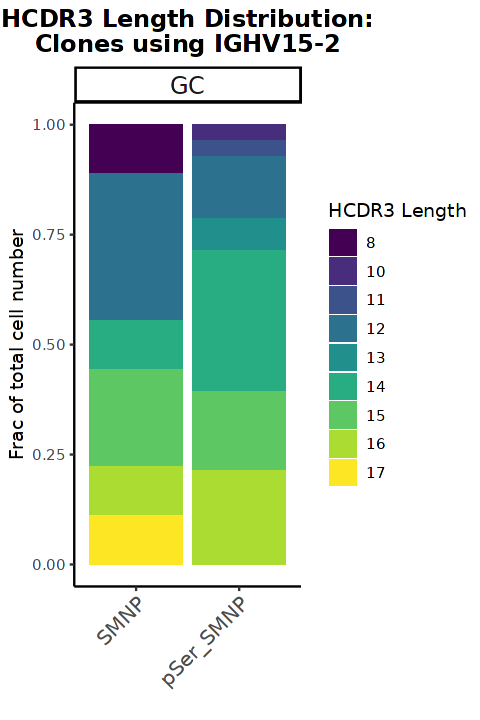

In [136]:
options(repr.plot.width=4,repr.plot.height=6)
df4gg %>% filter(Phenotype=='GC',Group!='pSer') %>% 
ggplot(aes(x=Group,fill=factor(hcdr3_aa_length))) + theme_classic() + 
geom_bar(position='fill') + facet_wrap('Phenotype') + scale_fill_viridis(discrete=TRUE) + 
labs(x='',y='Frac of total cell number',
     title='HCDR3 Length Distribution:\nClones using IGHV15-2',fill='HCDR3 Length')+
theme(axis.text.x=element_text(angle=45,hjust=1,size=12),
      strip.text=element_text(size=14),
      plot.title=element_text(size=14,face='bold',hjust=0.5))

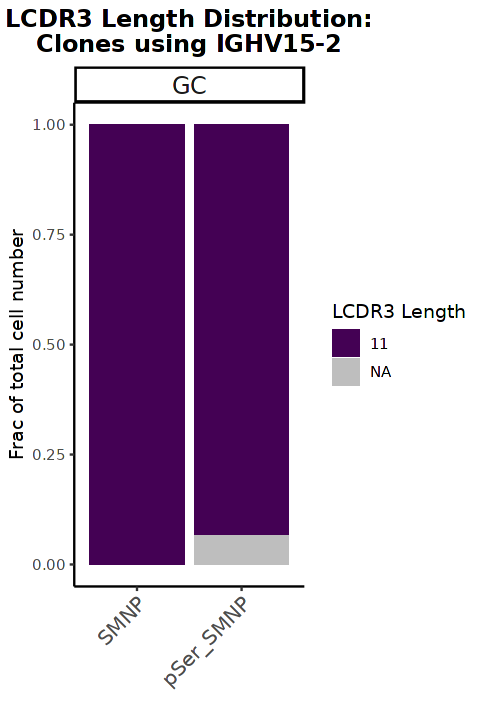

In [42]:
options(repr.plot.width=4,repr.plot.height=6)
df4gg %>% filter(Phenotype=='GC',Group!='pSer') %>% 
ggplot(aes(x=Group,fill=factor(lcdr3_aa_length))) + theme_classic() + 
geom_bar(position='fill') + facet_wrap('Phenotype') + scale_fill_viridis(discrete=TRUE,na.value='grey') + 
labs(x='',y='Frac of total cell number',
     title='LCDR3 Length Distribution:\nClones using IGHV15-2',fill='LCDR3 Length')+
theme(axis.text.x=element_text(angle=45,hjust=1,size=12),
      strip.text=element_text(size=14),
      plot.title=element_text(size=14,face='bold',hjust=0.5))

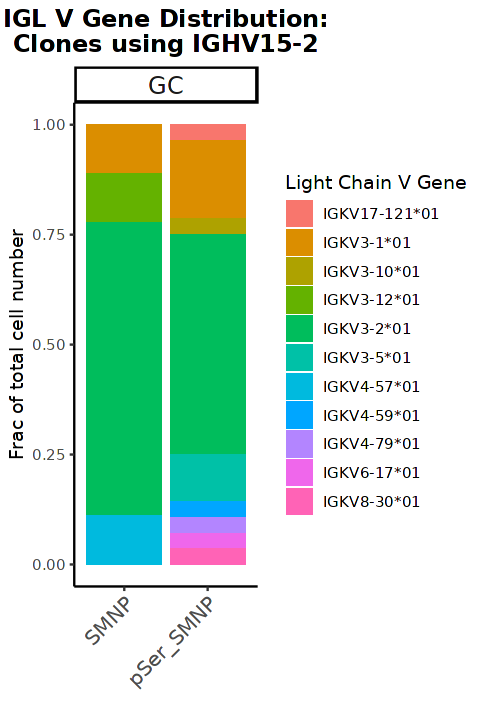

In [137]:
options(repr.plot.width=4,repr.plot.height=6)

df4gg %>% filter(Phenotype=='GC',Group!='pSer') %>% 
ggplot(aes(x=Group,fill=factor(IGL_V_CALL))) + theme_classic() + 
geom_bar(position='fill') + facet_wrap('Phenotype') + 
labs(x='',y='Frac of total cell number',
     title='IGL V Gene Distribution:\nClones using IGHV15-2',fill='Light Chain V Gene')+
theme(axis.text.x=element_text(angle=45,hjust=1,size=12),
      strip.text=element_text(size=14),
      plot.title=element_text(size=14,face='bold',hjust=0.5))

In [13]:
#install.packages("ggseqlogo")

Installing package into ‘/home/jupyter/packages’
(as ‘lib’ is unspecified)



In [16]:
library(ggseqlogo)

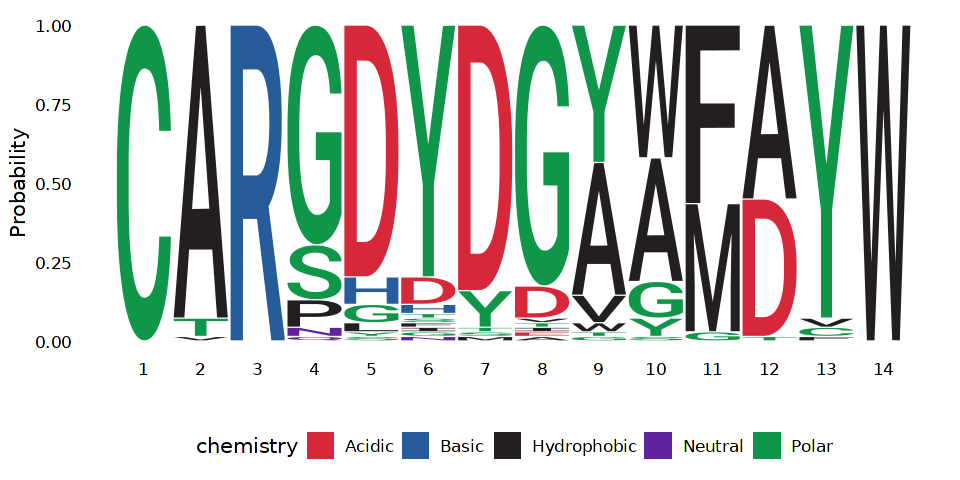

In [25]:
options(repr.plot.width=8,repr.plot.height=4)
a = metadata %>% filter(IGH_CLONE>0,startsWith(IGH_GERMLINE_V_CALL,'IGHV15-2'),Phenotype=='GC',
                        hcdr3_aa_length==14,Group!='pSer')
ggseqlogo( a$IGH_CDR3, method = 'prob')

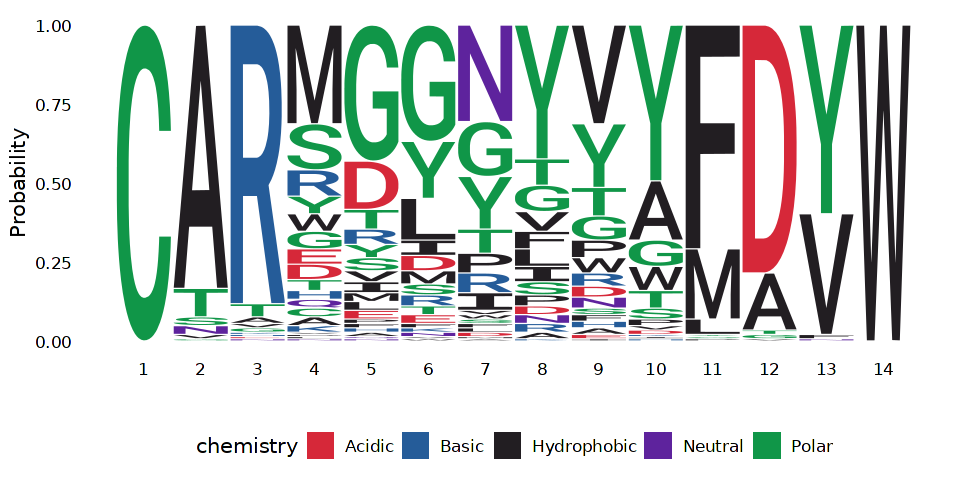

In [24]:
options(repr.plot.width=8,repr.plot.height=4)
a = metadata %>% filter(IGH_CLONE>0,!startsWith(IGH_GERMLINE_V_CALL,'IGHV15-2'),Phenotype=='GC',
                        hcdr3_aa_length==14)
ggseqlogo( a$IGH_CDR3, method = 'prob')

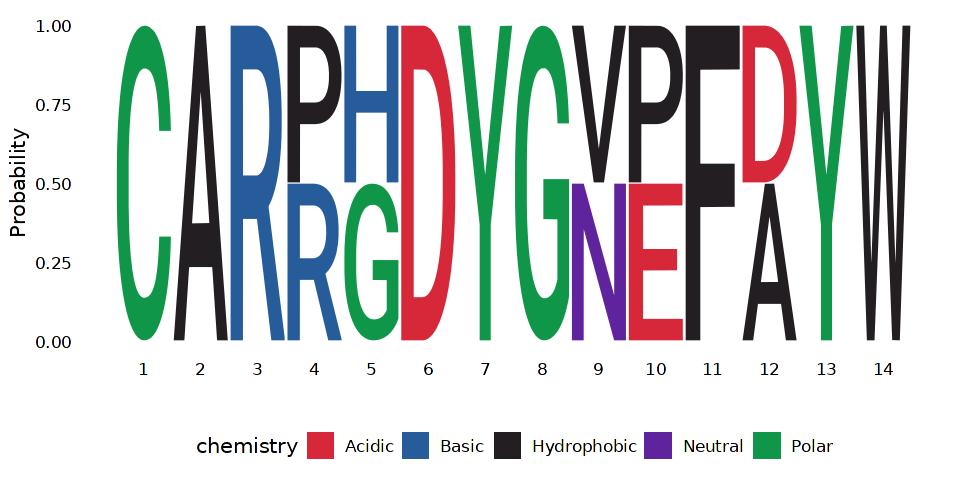

In [33]:
options(repr.plot.width=8,repr.plot.height=4)
a = metadata %>% filter(IGH_CLONE>0,startsWith(IGH_GERMLINE_V_CALL,'IGHV15-2'),Phenotype=='Ag_neg',
                        hcdr3_aa_length==14)
ggseqlogo( a$IGH_CDR3, method = 'prob')

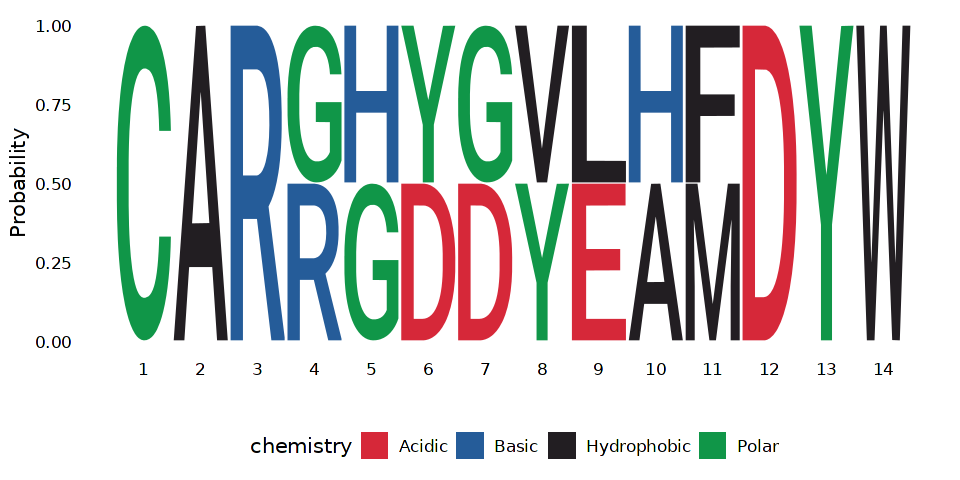

In [34]:
options(repr.plot.width=8,repr.plot.height=4)
a = metadata %>% filter(IGH_CLONE>0,startsWith(IGH_GERMLINE_V_CALL,'IGHV15-2'),Phenotype=='nonGC',
                        hcdr3_aa_length==14)
ggseqlogo( a$IGH_CDR3, method = 'prob')

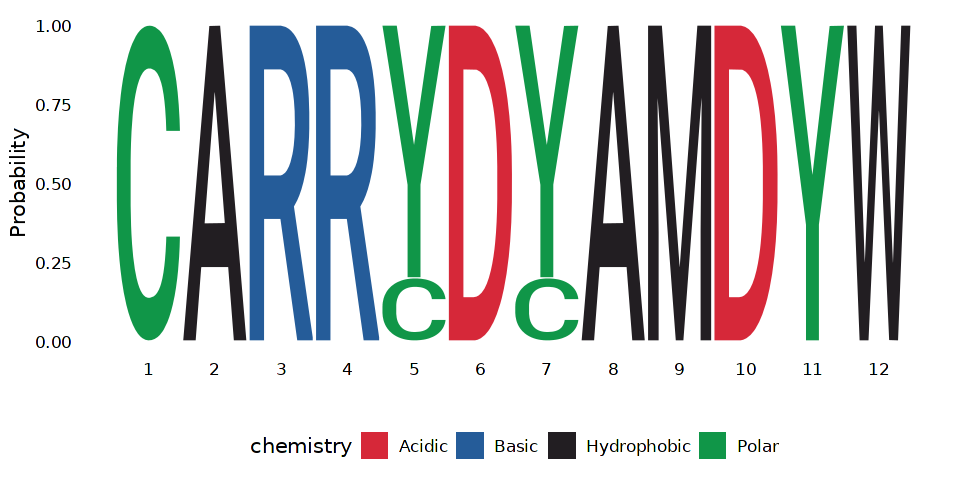

In [40]:
options(repr.plot.width=8,repr.plot.height=4)
a = metadata %>% filter(IGH_CLONE>0,IGH_GERMLINE_V_CALL=='IGHV15-2*02',hcdr3_aa_length==12,Group=='SMNP')
ggseqlogo( a$IGH_CDR3, method = 'prob')

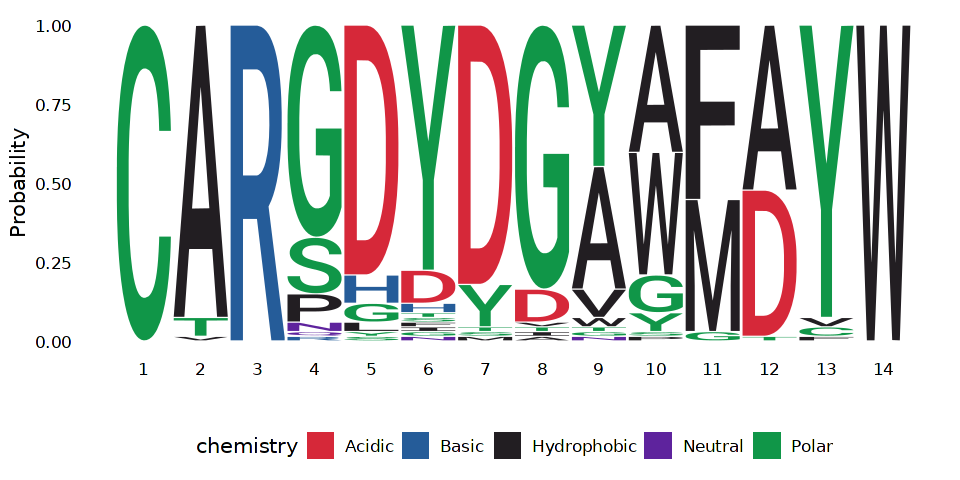

In [39]:
options(repr.plot.width=8,repr.plot.height=4)
a = metadata %>% filter(IGH_CLONE>0,!startsWith(IGH_GERMLINE_V_CALL,'IGHV15-2'),
                        hcdr3_aa_length==14)
ggseqlogo( a$IGH_CDR3, method = 'prob')

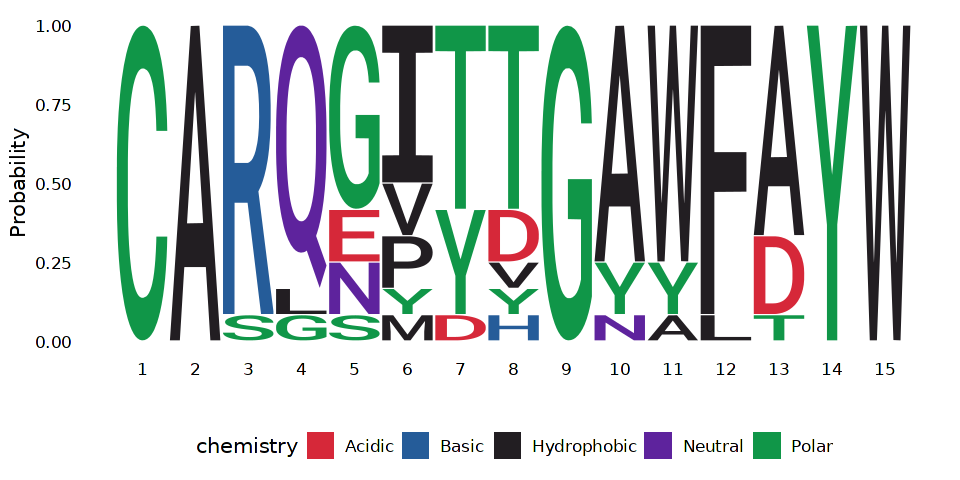

In [47]:
options(repr.plot.width=8,repr.plot.height=4)
a = metadata %>% filter(IGH_CLONE>0,IGH_GERMLINE_V_CALL=='IGHV15-2*02',hcdr3_aa_length==15,Group=='pSer_SMNP')
ggseqlogo( a$IGH_CDR3, method = 'prob' )

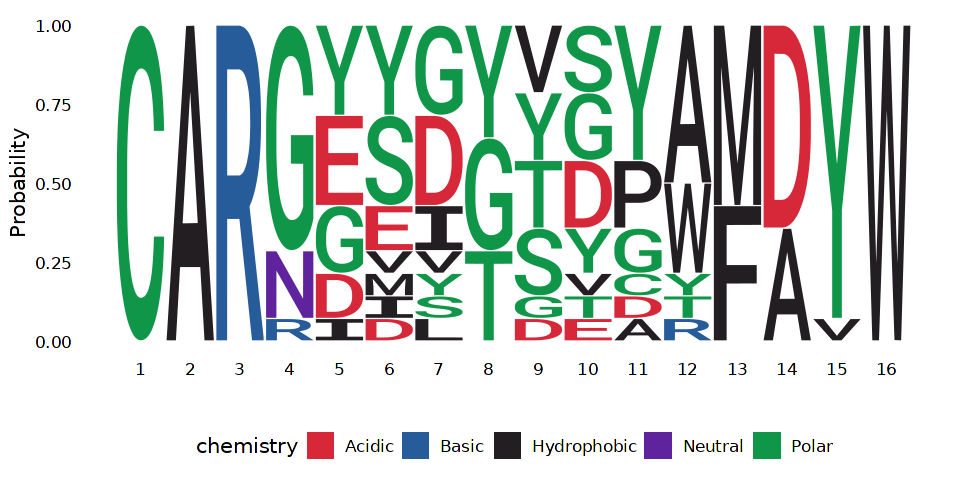

In [48]:
options(repr.plot.width=8,repr.plot.height=4)
a = metadata %>% filter(IGH_CLONE>0,IGH_GERMLINE_V_CALL=='IGHV15-2*02',hcdr3_aa_length==16,Group=='pSer_SMNP')
ggseqlogo( a$IGH_CDR3, method = 'prob' )

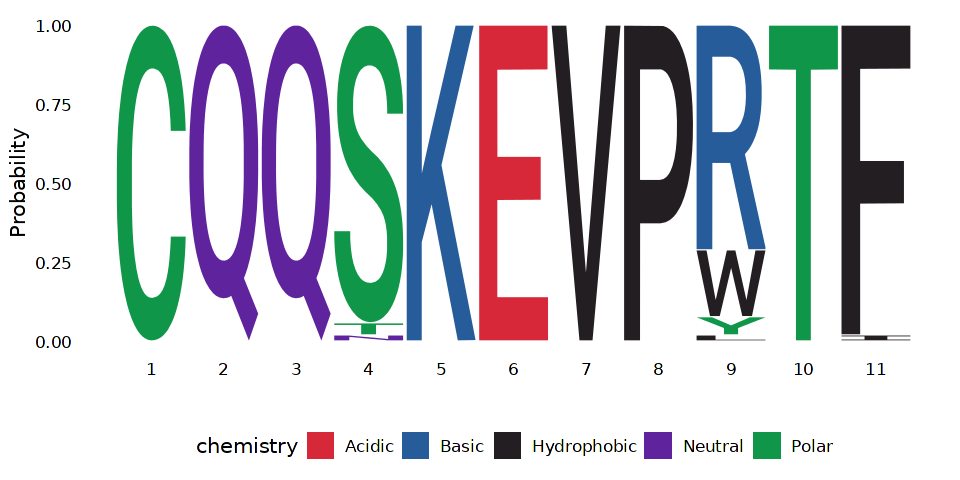

In [54]:
options(repr.plot.width=8,repr.plot.height=4)
a = metadata %>% filter(!is.na(IGL_CDR3),IGH_GERMLINE_V_CALL=='IGHV15-2*02',IGL_V_CALL=='IGKV3-2*01',Group=='pSer_SMNP')
ggseqlogo( a$IGL_CDR3, method = 'prob' )

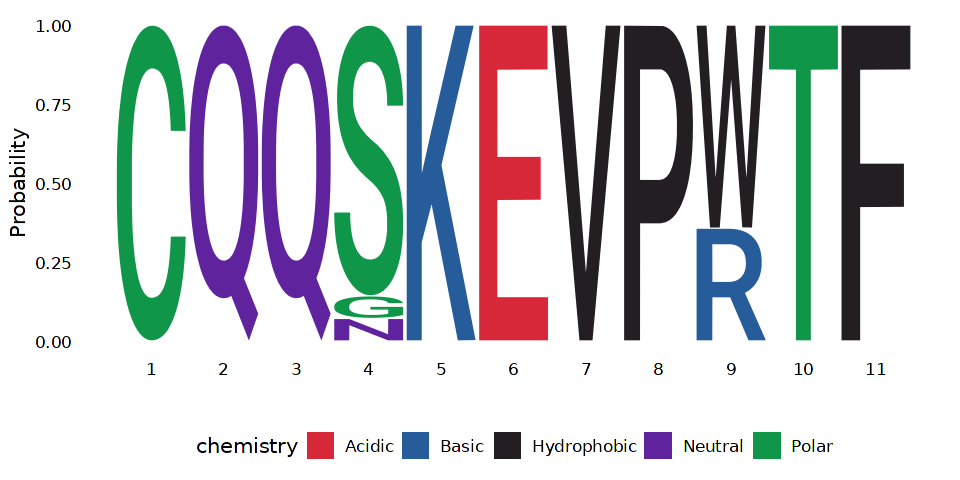

In [55]:
options(repr.plot.width=8,repr.plot.height=4)
a = metadata %>% filter(!is.na(IGL_CDR3),IGH_GERMLINE_V_CALL=='IGHV15-2*02',IGL_V_CALL=='IGKV3-2*01',Group=='SMNP')
ggseqlogo( a$IGL_CDR3, method = 'prob' )

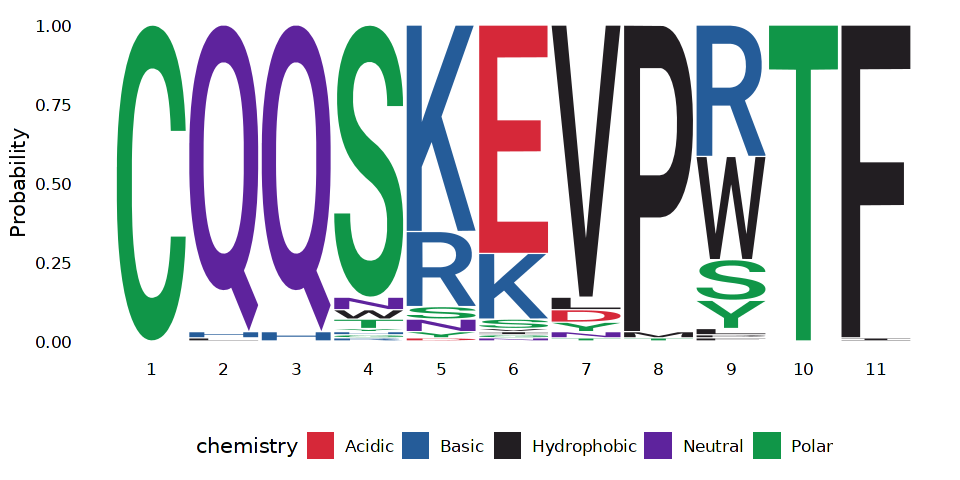

In [19]:
options(repr.plot.width=8,repr.plot.height=4)
a = metadata %>% filter(!is.na(IGL_CDR3),Group!='pSer',Phenotype=='GC',
                        startsWith(IGH_GERMLINE_V_CALL,'IGHV15-2'))
ggseqlogo( a$IGL_CDR3, method = 'prob' )

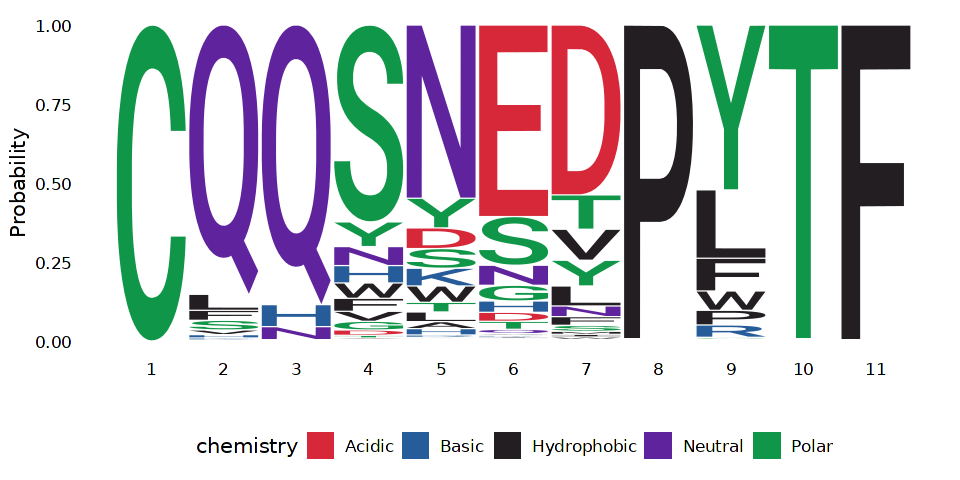

In [22]:
options(repr.plot.width=8,repr.plot.height=4)
a = metadata %>% filter(!is.na(IGL_CDR3),Group!='pSer',Phenotype=='GC',
                        !startsWith(IGH_GERMLINE_V_CALL,'IGHV15-2'),lcdr3_aa_length==11)
ggseqlogo( a$IGL_CDR3, method = 'prob' )

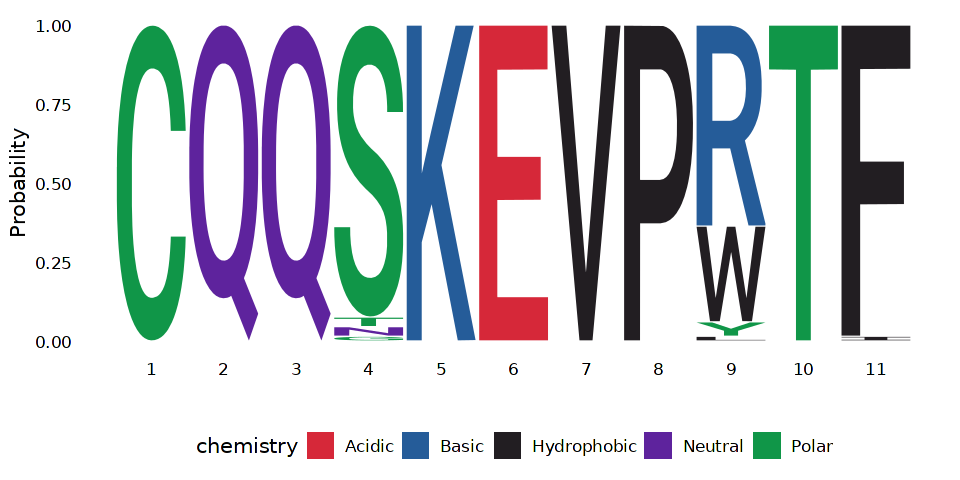

In [17]:
options(repr.plot.width=8,repr.plot.height=4)
a = metadata %>% filter(!is.na(IGL_CDR3),Group!='pSer',Phenotype=='GC',
                        startsWith(IGH_GERMLINE_V_CALL,'IGHV15-2'),startsWith(IGL_V_CALL,'IGKV3-2')
                        )
ggseqlogo( a$IGL_CDR3, method = 'prob' )

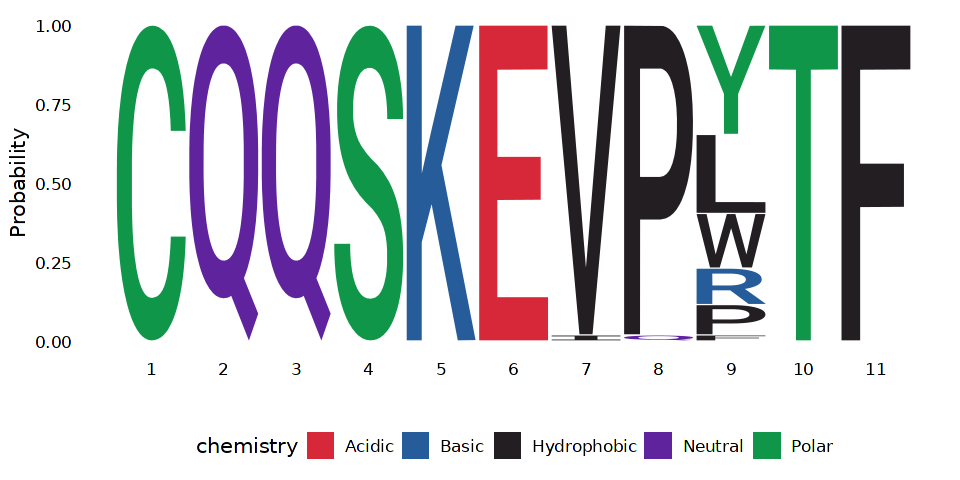

In [18]:
options(repr.plot.width=8,repr.plot.height=4)
a = metadata %>% filter(!is.na(IGL_CDR3),Group!='pSer',Phenotype=='GC',
                        !startsWith(IGH_GERMLINE_V_CALL,'IGHV15-2'),startsWith(IGL_V_CALL,'IGKV3-2')
                        )
ggseqlogo( a$IGL_CDR3, method = 'prob' )

## older stuff

In [48]:
hc$Phenotype = metadata$Phenotype[match(hc$LANE_ID, metadata$id)]
hc$Group = metadata$Group[match(hc$LANE_ID, metadata$id)]

In [63]:
library(alakazam)
vgenes = countGenes(hc %>% group_by(CLONE) %>% slice(1), gene="GERMLINE_V_CALL", groups=c("Phenotype"), mode="gene")

In [64]:
dat = vgenes
dat$Phenotype = as.character(dat$Phenotype)
# dat$Phenotype[dat$Phenotype=='2D'] = 'TD'
# Get the number of rows in the data frame
nrows <- nrow(dat)

# Initialize the 'id' column
dat$id = numeric(nrows)

# Vectorize the operations on the 'Sample' and 'id' columns
dat$id <- ave(dat$Phenotype, dat$Phenotype, FUN = seq_along)

# Use the 'dcast()' function to create the final data frame
freq.df = dcast(dat,gene~Phenotype, value.var = 'seq_freq') %>% replace(is.na(.), 0)
count.df = dcast(dat, gene~Phenotype, value.var = 'seq_count') %>% replace(is.na(.), 0)

Warning message:
“Removed 131 rows containing missing values (`geom_text_repel()`).”


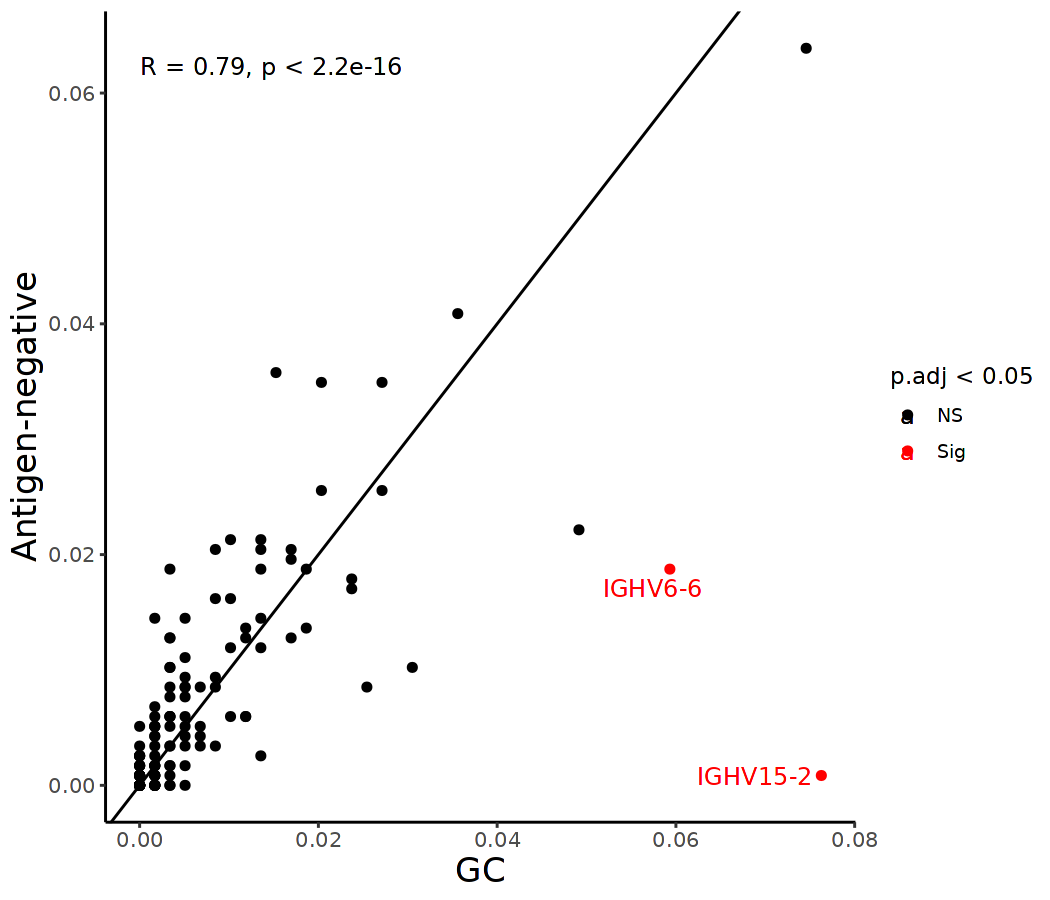

In [65]:
options(repr.plot.height=6,repr.plot.width=7, repr.plot.res=150)

df4gg = freq.df %>% select('gene','Antigen-negative','GC') ### change 

results = jz.fischer.test(count.df$GC,count.df$`Antigen-negative`, count.df$gene) ### change 

df4gg = merge(df4gg, results, by = "gene")

threshold = 0.05

df4gg$label = df4gg$gene
df4gg$label[df4gg$p.adj>threshold] = NA

df4gg %>% mutate(bias.color=ifelse(p.adj<threshold, 'Sig', 'NS')) %>% 
ggplot(aes(x=GC, y= `Antigen-negative`, color=bias.color)) + ###### change 
geom_point() + 
scale_colour_manual(name=sprintf("p.adj < %.2f", threshold), 
                    values = c( 'Sig' ="red", "NS" = "black"))+ 
geom_text_repel(aes(label = label), size=4,max.overlaps = 10) +
theme_classic() + 
geom_abline(slope =1) + 
# geom_smooth(aes(color = NULL),method="lm") + 
# ylim(0,0.15) +
ggpubr::stat_cor(method = 'spearman', aes(color = NULL))+
theme(axis.text.x=element_text(size=10),
      axis.text.y=element_text(size=10),
      axis.title.y=element_text(size=16),
      axis.title.x=element_text(size=16),)

Warning message:
“Removed 133 rows containing missing values (`geom_text_repel()`).”


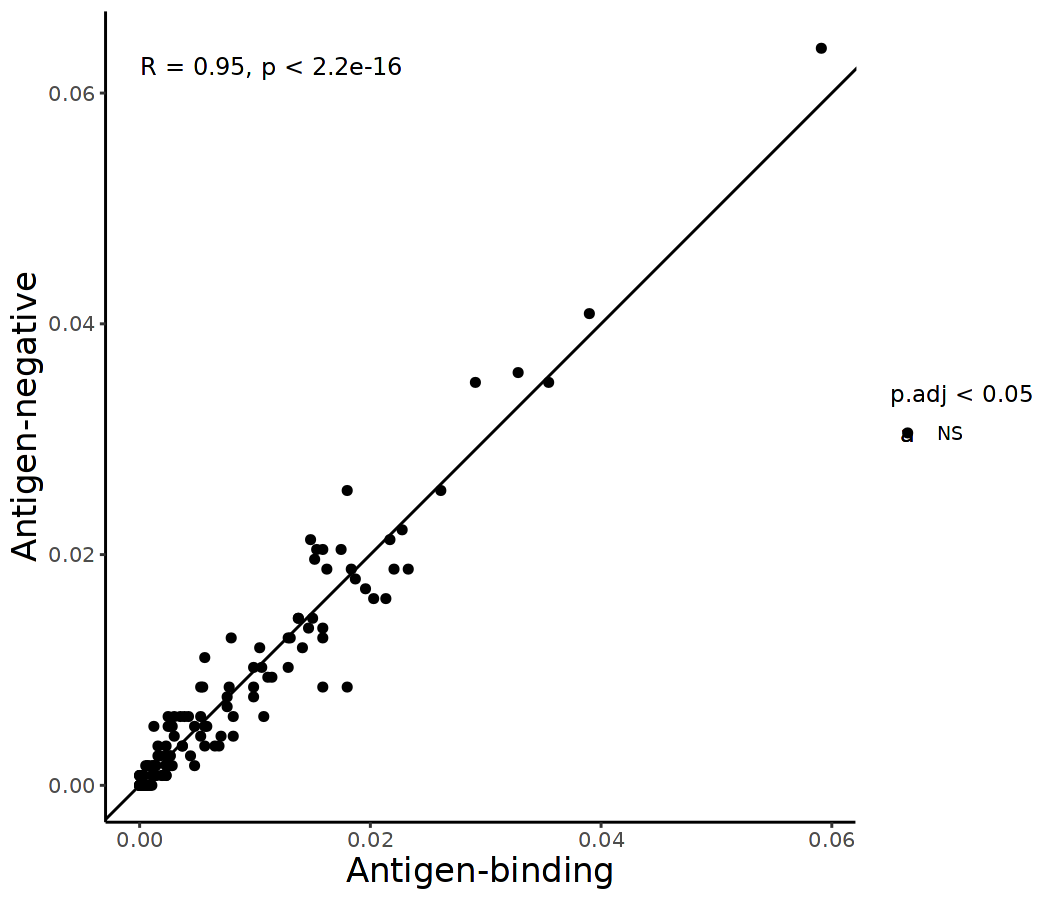

In [67]:
options(repr.plot.height=6,repr.plot.width=7, repr.plot.res=150)

df4gg = freq.df %>% select('gene','Antigen-negative','Antigen-binding') ### change 

results = jz.fischer.test(count.df$`Antigen-negative`,count.df$`Antigen-binding`, count.df$gene) ### change 

df4gg = merge(df4gg, results, by = "gene")

threshold = 0.05

df4gg$label = df4gg$gene
df4gg$label[df4gg$p.adj>threshold] = NA

df4gg %>% mutate(bias.color=ifelse(p.adj<threshold, 'Sig', 'NS')) %>% 
ggplot(aes(x=`Antigen-binding`, y= `Antigen-negative`, color=bias.color)) + ###### change 
geom_point() + 
scale_colour_manual(name=sprintf("p.adj < %.2f", threshold), 
                    values = c( 'Sig' ="red", "NS" = "black"))+ 
geom_text_repel(aes(label = label), size=4,max.overlaps = 10) +
theme_classic() + 
geom_abline(slope =1) + 
# geom_smooth(aes(color = NULL),method="lm") + 
# ylim(0,0.15) +
ggpubr::stat_cor(method = 'spearman', aes(color = NULL))+
theme(axis.text.x=element_text(size=10),
      axis.text.y=element_text(size=10),
      axis.title.y=element_text(size=16),
      axis.title.x=element_text(size=16),)

In [68]:
library(alakazam)
vgenes = countGenes(hc %>% group_by(CLONE) %>% slice(1), gene="GERMLINE_V_CALL", groups=c("Group"), mode="gene")

In [69]:
dat = vgenes
dat$Group = as.character(dat$Group)
dat$Group[dat$Group=='2D'] = 'TD'
# Get the number of rows in the data frame
nrows <- nrow(dat)

# Initialize the 'id' column
dat$id = numeric(nrows)

# Vectorize the operations on the 'Sample' and 'id' columns
dat$id <- ave(dat$Group, dat$Group, FUN = seq_along)

# Use the 'dcast()' function to create the final data frame
freq.df = dcast(dat,gene~Group, value.var = 'seq_freq') %>% replace(is.na(.), 0)
count.df = dcast(dat, gene~Group, value.var = 'seq_count') %>% replace(is.na(.), 0)

Warning message:
“Removed 132 rows containing missing values (`geom_text_repel()`).”


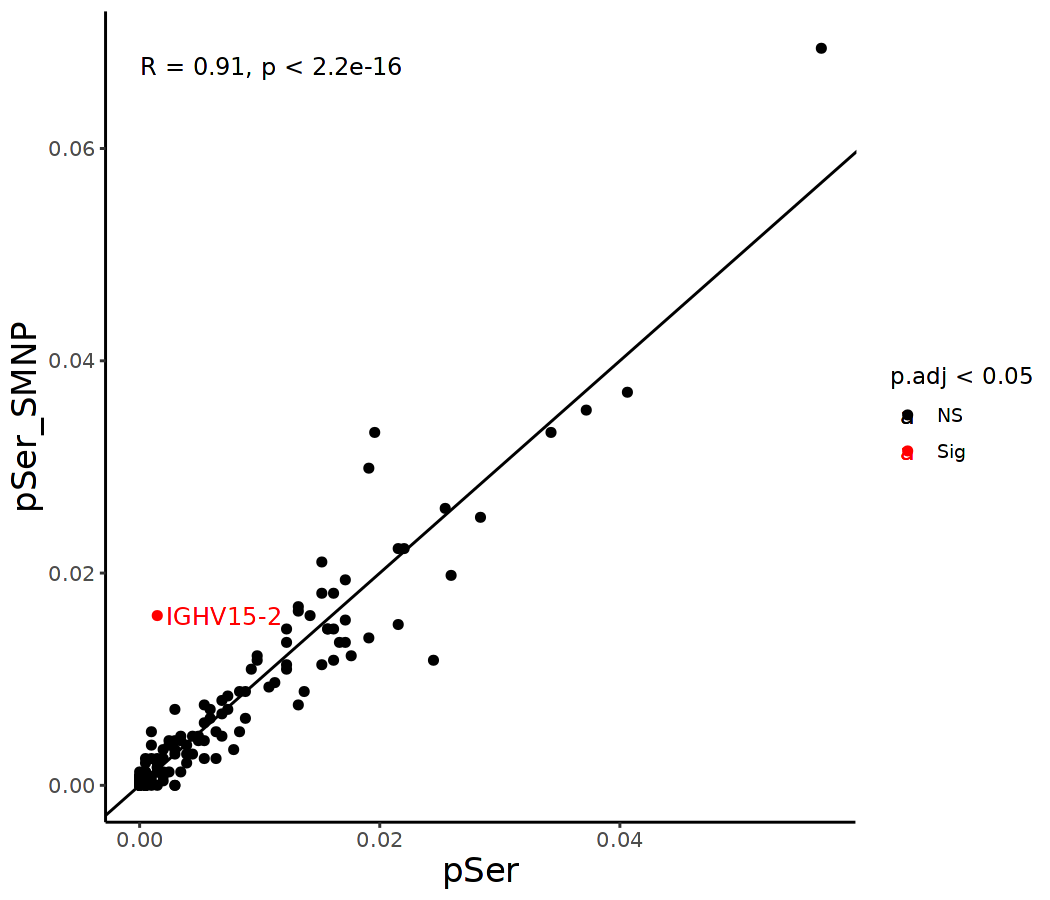

In [70]:
options(repr.plot.height=6,repr.plot.width=7, repr.plot.res=150)

df4gg = freq.df %>% select('gene','pSer','pSer_SMNP') ### change 

results = jz.fischer.test(count.df$pSer,count.df$pSer_SMNP, count.df$gene) ### change 

df4gg = merge(df4gg, results, by = "gene")

threshold = 0.05

df4gg$label = df4gg$gene
df4gg$label[df4gg$p.adj>threshold] = NA

df4gg %>% mutate(bias.color=ifelse(p.adj<threshold, 'Sig', 'NS')) %>% 
ggplot(aes(x=pSer, y= pSer_SMNP, color=bias.color)) + ###### change 
geom_point() + 
scale_colour_manual(name=sprintf("p.adj < %.2f", threshold), 
                    values = c( 'Sig' ="red", "NS" = "black"))+ 
geom_text_repel(aes(label = label), size=4,max.overlaps = 10) +
theme_classic() + 
geom_abline(slope =1) + 
# geom_smooth(aes(color = NULL),method="lm") + 
# ylim(0,0.15) +
ggpubr::stat_cor(method = 'spearman', aes(color = NULL))+
theme(axis.text.x=element_text(size=10),
      axis.text.y=element_text(size=10),
      axis.title.y=element_text(size=16),
      axis.title.x=element_text(size=16),)

Warning message:
“Removed 132 rows containing missing values (`geom_text_repel()`).”


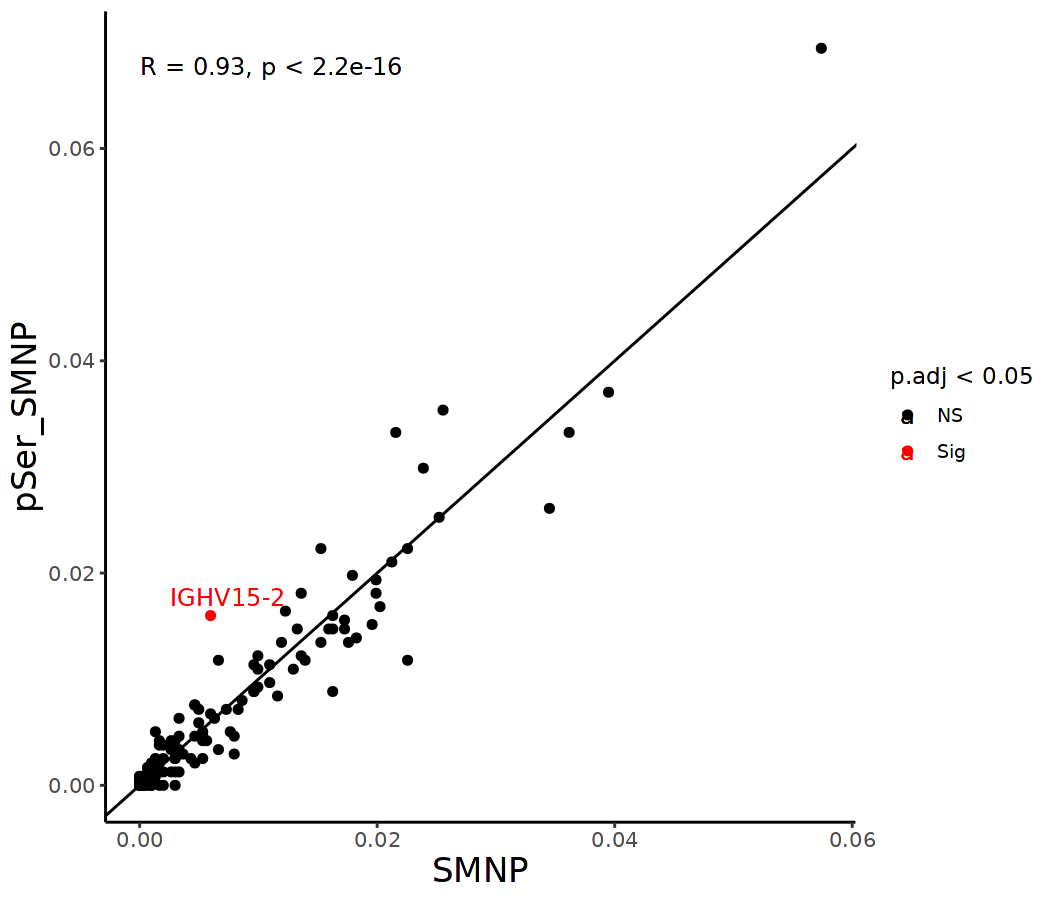

In [71]:
options(repr.plot.height=6,repr.plot.width=7, repr.plot.res=150)

df4gg = freq.df %>% select('gene','SMNP','pSer_SMNP') ### change 

results = jz.fischer.test(count.df$SMNP,count.df$pSer_SMNP, count.df$gene) ### change 

df4gg = merge(df4gg, results, by = "gene")

threshold = 0.05

df4gg$label = df4gg$gene
df4gg$label[df4gg$p.adj>threshold] = NA

df4gg %>% mutate(bias.color=ifelse(p.adj<threshold, 'Sig', 'NS')) %>% 
ggplot(aes(x=SMNP, y= pSer_SMNP, color=bias.color)) + ###### change 
geom_point() + 
scale_colour_manual(name=sprintf("p.adj < %.2f", threshold), 
                    values = c( 'Sig' ="red", "NS" = "black"))+ 
geom_text_repel(aes(label = label), size=4,max.overlaps = 10) +
theme_classic() + 
geom_abline(slope =1) + 
# geom_smooth(aes(color = NULL),method="lm") + 
# ylim(0,0.15) +
ggpubr::stat_cor(method = 'spearman', aes(color = NULL))+
theme(axis.text.x=element_text(size=10),
      axis.text.y=element_text(size=10),
      axis.title.y=element_text(size=16),
      axis.title.x=element_text(size=16),)

## check nonfunctional BCR and apoptosis

In [87]:
b.seurat = readRDS('md39/seurat_objects/04_md39_singlet_bcells.RDS')
metadata = b.seurat@meta.data
metadata$id = paste(metadata$orig, metadata$bc, sep='_')
dim(metadata)

[1] 38027    34

In [ ]:
data = readRDS('md39/processed_repertoire_data/00_md39_HC_LC_combined.RDS')
dim(data)

In [88]:
non.func.bcr = data %>% filter(FUNCTIONAL==FALSE, N_count<5, R2CONSCOUNT>3)
non.func.bcr = non.func.bcr %>% filter(LANE_ID %in% metadata$id, LOCUS=='IGH')
dim(non.func.bcr)

[1] 3533   71

In [89]:
b.seurat@meta.data=b.seurat@meta.data %>% mutate(functional.bcr = ifelse(id %in% non.func.bcr$LANE_ID, 'Nonfunctional','NA'))

In [98]:
library(msigdbr)
all_gene_sets = msigdbr(species = "Mus musculus")

In [105]:
jz.gsea <- function(seurat.obj,gs.name) {
    features=all_gene_sets %>% filter(gs_name == gs.name) %>% select('gene_symbol') 
    # print(as.vector(features))
    seurat.obj=AddModuleScore(seurat.obj, features, name=gs.name)
    return (seurat.obj)
}

Warning message:
“The following features are not present in the object: Aifm3, Avpr1a, Bcl2l10, Bmp2, Cav1, Ccna1, Erbb2, Ereg, F2, Fez1, Gpx3, Gstm2, Ifnb1, Igfbp6, Il1a, Il6, Lum, Plat, Plppr4, Timp1, not searching for symbol synonyms”


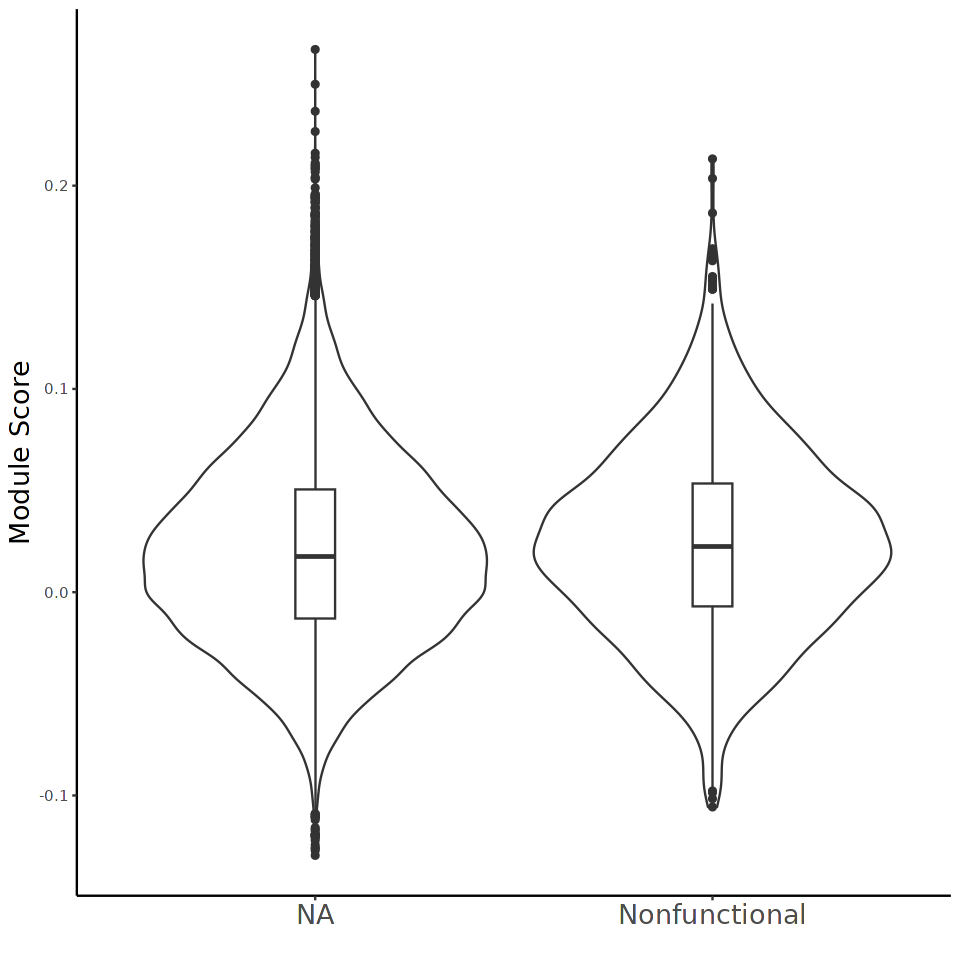

In [106]:
b.seurat=jz.gsea(b.seurat,'HALLMARK_APOPTOSIS')
b.seurat@meta.data %>% 
ggplot(aes(x=functional.bcr,y=HALLMARK_APOPTOSIS1)) + 
geom_violin() + # geom_quasirandom(size=0.1, alpha=0.8)+
geom_boxplot(width=0.1) + theme_classic() + 
labs(x='', y='Module Score') + 
theme(plot.title=element_text(hjust=0.5,size=16,face='bold'),
      axis.text.x=element_text(size=16),
      axis.title.y=element_text(size=16)) 

Warning message:
“The following features are not present in the object: Bmx, Dcc, Dsg1a, Dsg3, Gsdme, H1f1, H1f2, H1f3, H1f4, H1f5, Ocln, Pkp1, Psmb11, Sem1, Septin4, Stk26, Tjp1, Trp63, Unc5b, not searching for symbol synonyms”


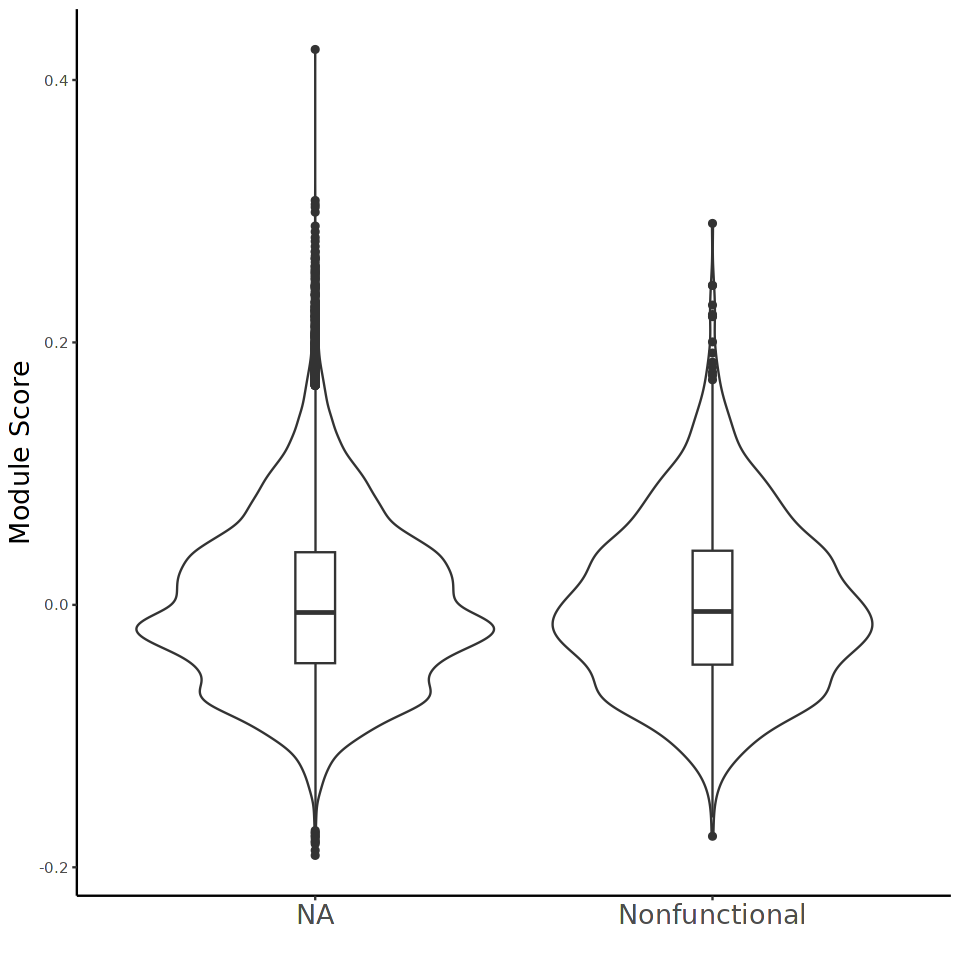

In [108]:
b.seurat=jz.gsea(b.seurat,'REACTOME_APOPTOSIS')
b.seurat@meta.data %>% 
ggplot(aes(x=functional.bcr,y=GOBP_EXECUTION_PHASE_OF_APOPTOSIS1)) + 
geom_violin() + # geom_quasirandom(size=0.1, alpha=0.8)+
geom_boxplot(width=0.1) + theme_classic() + 
labs(x='', y='Module Score') + 
theme(plot.title=element_text(hjust=0.5,size=16,face='bold'),
      axis.text.x=element_text(size=16),
      axis.title.y=element_text(size=16)) 

In [90]:
b.seurat=AddModuleScore(b.seurat, list(c('Casp3','Casp7')), name='Caspase3_7')

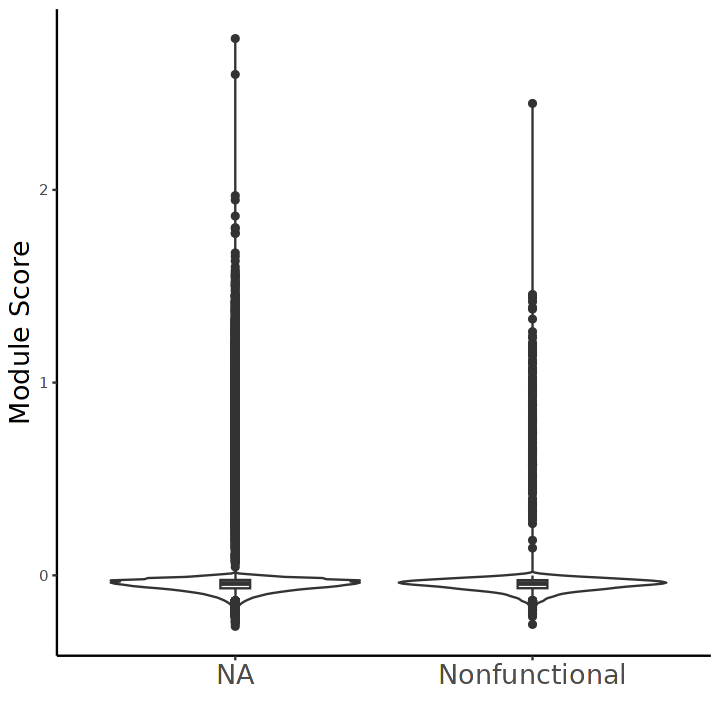

In [92]:
b.seurat@meta.data %>% 
ggplot(aes(x=functional.bcr,y=Caspase3_71)) + 
geom_violin() + # geom_quasirandom(size=0.1, alpha=0.8)+
geom_boxplot(width=0.1) + theme_classic() + 
labs(x='', y='Module Score') + 
theme(plot.title=element_text(hjust=0.5,size=16,face='bold'),
      axis.text.x=element_text(size=16),
      axis.title.y=element_text(size=16)) 